# Modules

In [1]:
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from community import community_louvain
import matplotlib.cm as cm
import csv
import random

%matplotlib inline

# Functions

In [2]:
def create_kegg_graph(data_df, include_reactions = True):
    
    G = nx.MultiDiGraph()  # At first create multigraph, later it can be converted
    
    unique_entries = []  # List of unique entries. Each gene, ompound, etc needs to be stored as 1 node
    
    # Iterate data to create all nodes
    for index, entry in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and entry['link type']=='reaction':
            continue            
        
        # -- Handle node for Head --
        n1 = entry['head id']
        if n1 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n1)
            
            #Add node n1
            G.add_node(n1)
            # Assign node type
            if n1[0:3] == 'hsa':
                t = 'gene'
            elif n1[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n1.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['head full name'] == '':
                full_name = n1
            else:
                full_name = entry['head full name']
            pathway = str(entry['pathway'])
            attr = {n1: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n1]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n1]['pathways'] = temp

        # -- Handle node for Tail --
        n2 = entry['tail id']
        if n2 not in unique_entries:  # If there is no node for this id yet
            
            unique_entries.append(n2)
            
            #Add node n2
            G.add_node(n2)
            # Assign node type
            if n2[0:3] == 'hsa':
                t = 'gene'
            elif n2[0:3] == 'cpd':
                t = 'compound'
            else:
                temp = n2.split(":")
                t = temp[0]
            # Assign rest of node attributes
            if entry['tail full name'] == '':
                full_name = n2
            else:
                full_name = entry['tail full name']
            pathway = str(entry['pathway'])
            attr = {n2: {'type':t, 'full name': full_name, 'pathways': [pathway]}}
            nx.set_node_attributes(G, attr)
            
        else:  # If there is a node for this id already
            # Add the pathway info (if different pathway)
            temp = G.nodes[n2]['pathways']
            if entry['pathway'] not in temp:
                temp.append(entry['pathway'])
                G.nodes[n2]['pathways'] = temp
        
        
     # Iterate data to find all relations           
    for index, row in tqdm(data_df.iterrows(), total=data_df.shape[0]):
        
        if not include_reactions and row['link type']=='reaction':
            continue 
        
        head = str(row['head id'])
        tail = str(row['tail id'])
        pathway = str(row['pathway'])
        link_type = str(row['link type'])
        rel_name = str(row['relation name'])
        if head in G.nodes and tail in G.nodes:
            G.add_edge(head, tail,pathway = pathway, link_type= link_type, relation_name= rel_name)
        else:
            print('node not found @row '+str(index))
        
    return G
    

# Exploratory Data Analysis

In [3]:
# === load data ===
df_relations = pd.read_csv('../KEGG Pathways Dataset Collection/All_relations-Curated-full_names.csv')
G_directed = create_kegg_graph(df_relations)
G_undirected = nx.Graph(G_directed)
print(G_undirected)

100%|█████████████████████████████████████████████████████████████████████████| 17389/17389 [00:01<00:00, 12939.15it/s]


Graph with 5185 nodes and 11766 edges


In [4]:
# Keep main component only. Prevent biased zeros to unconnected nodes
largest_cc = max(nx.connected_components(G_undirected), key=len)
lsmain = list(largest_cc)

G_undirected_main = G_undirected.copy()
remove = []
for node in G_undirected_main.nodes:
    if node not in lsmain:
        remove.append(node)
        
for node in remove:        
    G_undirected_main.remove_node(node)
        
print(G_undirected_main)

Graph with 4812 nodes and 11539 edges


Partitions :31


<Figure size 1872x432 with 0 Axes>

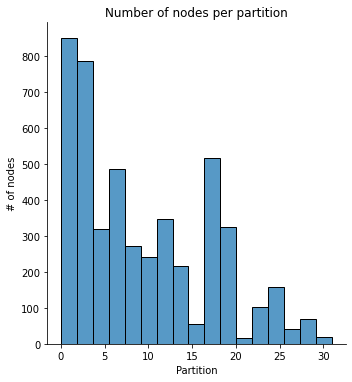

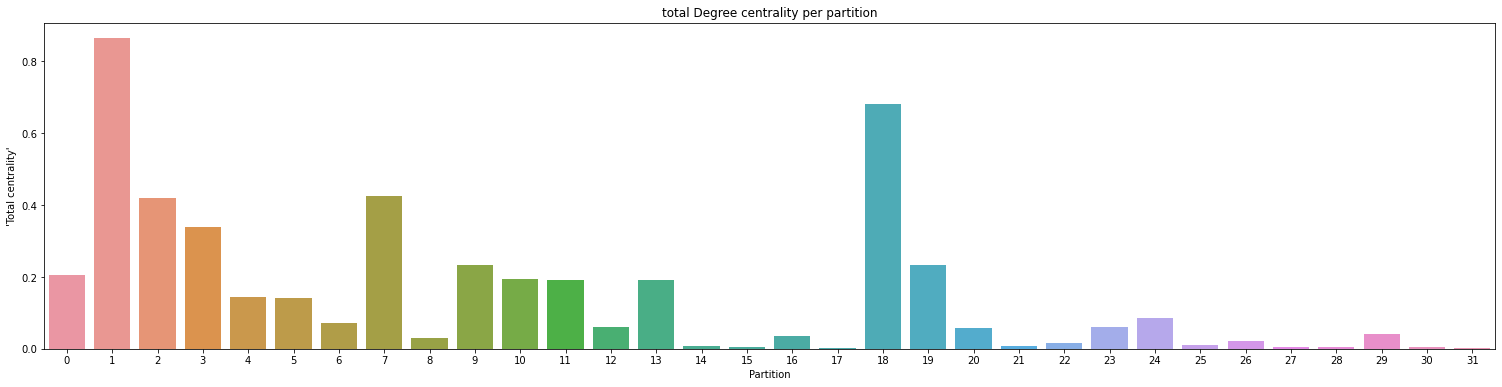

In [5]:
# Find Louvain partitions
partition = community_louvain.best_partition(G_undirected_main,resolution=1.01)
num_partitions = max(partition.values())
print("Partitions :" + str(num_partitions))

plt.figure(figsize=(26,6))
ax = sns.displot(list(partition.values()))
ax.set(xlabel="Partition", ylabel = "# of nodes", title = "Number of nodes per partition")
plt.show()

centrality = nx.degree_centrality(G_undirected_main)
centrality_dict = {}
for i in range(0,num_partitions+1):
    centrality_dict[i] = 0
for node in partition.keys():
    centrality_dict[partition[node]] += centrality[node]

plt.figure(figsize=(26,6))  
ax = sns.barplot(x=list(centrality_dict.keys()), y = list(centrality_dict.values()))
ax.set(xlabel="Partition", ylabel = "'Total centrality'", title = "total Degree centrality per partition")
plt.show()

  0%|▎                                                                              | 95/30000 [00:09<44:49, 11.12it/s]

Graph A:
Graph with 2619 nodes and 6317 edges
Graph B:
Graph with 2193 nodes and 4012 edges
[0, 2, 6, 7, 10, 11, 15, 16, 19, 24, 25, 29, 32, 33, 35, 36, 37, 38]


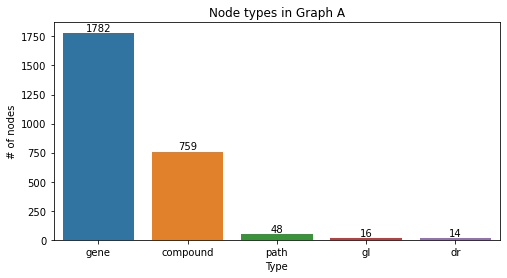

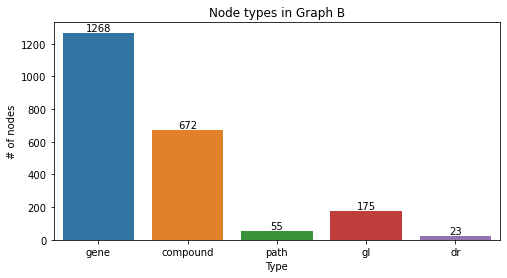

  1%|▌                                                                             | 229/30000 [00:23<51:19,  9.67it/s]

Graph A:
Graph with 2442 nodes and 5434 edges
Graph B:
Graph with 2370 nodes and 4903 edges
[0, 2, 4, 5, 6, 9, 10, 16, 17, 18, 21, 22, 24, 25, 29, 33, 36]


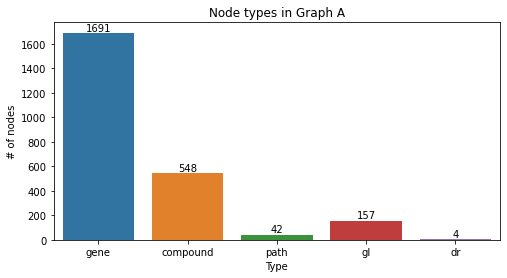

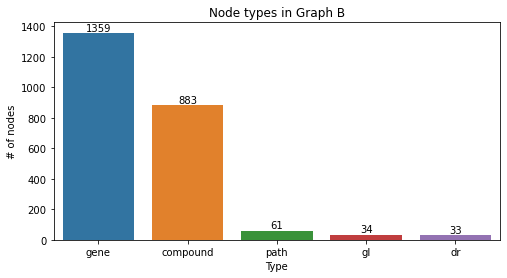

  1%|█▏                                                                            | 445/30000 [00:46<54:52,  8.98it/s]

Graph A:
Graph with 3126 nodes and 7410 edges
Graph B:
Graph with 1686 nodes and 3067 edges
[0, 4, 5, 6, 9, 13, 19, 20, 23, 24, 25, 26, 29, 32, 33, 37, 38]


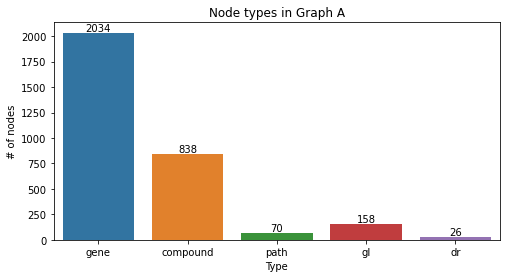

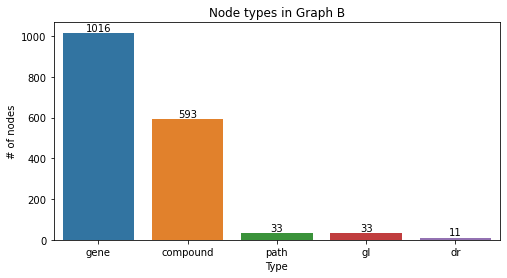

  2%|█▎                                                                            | 526/30000 [00:55<50:33,  9.72it/s]

Graph A:
Graph with 2034 nodes and 5232 edges
Graph B:
Graph with 2778 nodes and 5478 edges
[0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 16, 19, 21, 22, 24, 29, 32, 35, 36, 37, 39]


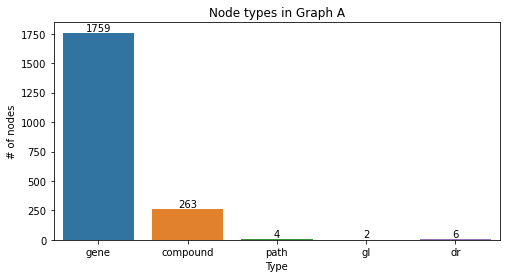

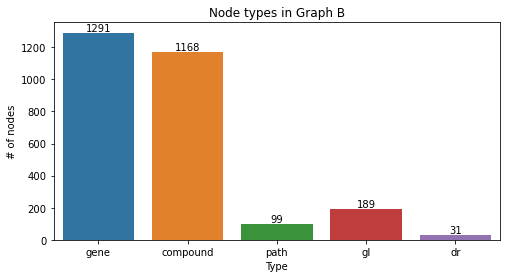

  2%|█▍                                                                            | 546/30000 [00:57<47:14, 10.39it/s]

Graph A:
Graph with 1882 nodes and 3745 edges
Graph B:
Graph with 2930 nodes and 6912 edges
[1, 2, 4, 5, 7, 8, 12, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38]


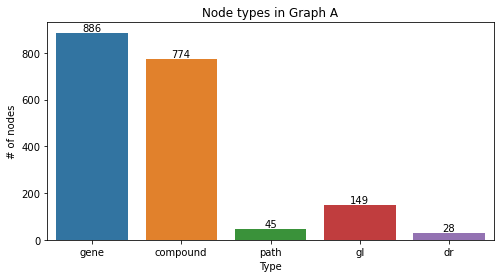

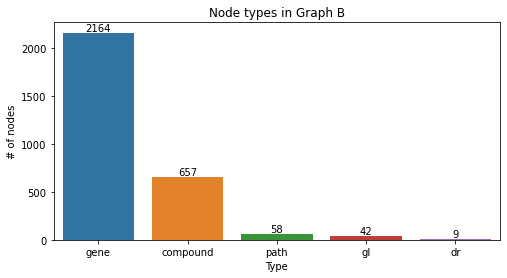

  2%|█▌                                                                            | 594/30000 [01:03<45:53, 10.68it/s]

Graph A:
Graph with 1192 nodes and 2250 edges
Graph B:
Graph with 3620 nodes and 8546 edges
[0, 1, 2, 4, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, 25, 26, 27, 28, 29, 30, 31, 36, 37, 38]


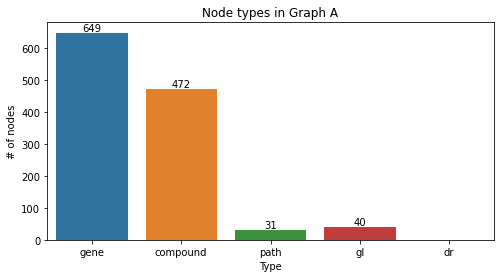

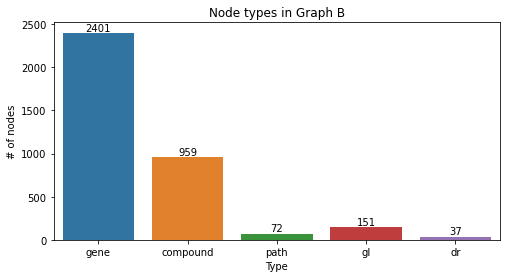

  3%|██▌                                                                          | 1012/30000 [01:46<45:26, 10.63it/s]

Graph A:
Graph with 1476 nodes and 2697 edges
Graph B:
Graph with 3336 nodes and 7916 edges
[0, 1, 3, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 25, 27, 28, 29, 30, 31, 32, 35, 36, 38]


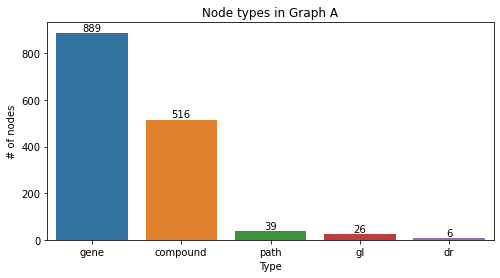

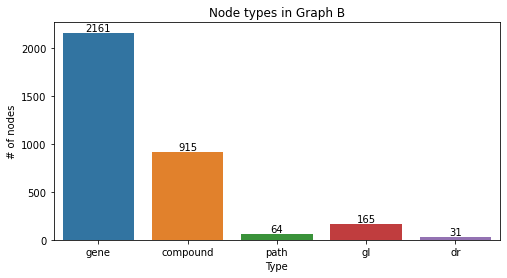

  4%|███▍                                                                         | 1348/30000 [02:21<50:29,  9.46it/s]

Graph A:
Graph with 2526 nodes and 5375 edges
Graph B:
Graph with 2286 nodes and 4887 edges
[1, 2, 3, 4, 5, 6, 14, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 38]


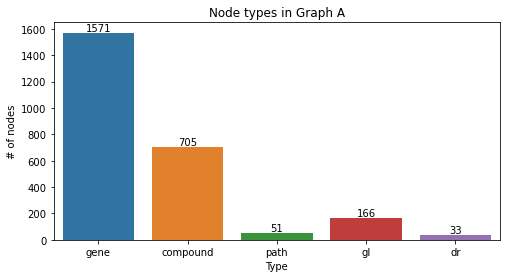

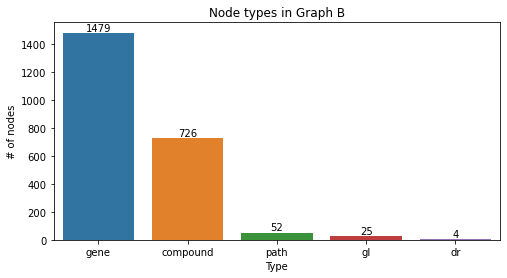

  5%|███▋                                                                         | 1439/30000 [02:30<47:36, 10.00it/s]

Graph A:
Graph with 2283 nodes and 4358 edges
Graph B:
Graph with 2529 nodes and 6050 edges
[1, 2, 3, 4, 8, 12, 14, 16, 17, 18, 21, 22, 23, 26, 27, 28, 29, 30, 31, 33, 35, 38]


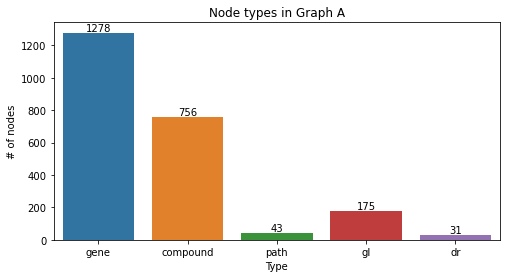

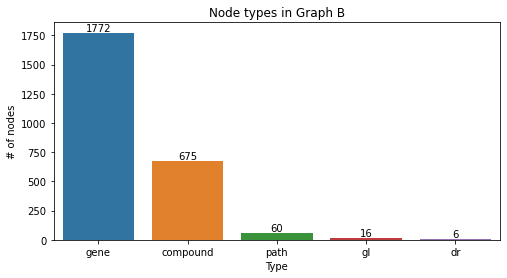

  5%|███▊                                                                         | 1473/30000 [02:34<58:52,  8.08it/s]

Graph A:
Graph with 1491 nodes and 3074 edges
Graph B:
Graph with 3321 nodes and 7395 edges
[1, 2, 3, 4, 5, 7, 9, 10, 11, 13, 14, 15, 21, 22, 24, 25, 27, 28, 30, 31, 32, 33, 35, 38, 39]


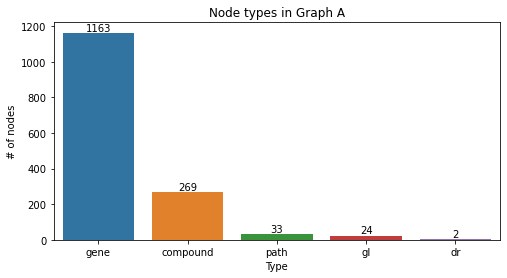

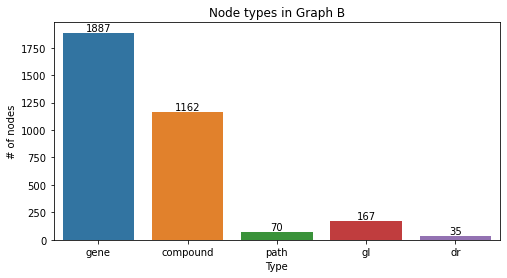

  5%|███▉                                                                         | 1557/30000 [02:43<43:37, 10.87it/s]

Graph A:
Graph with 2917 nodes and 6307 edges
Graph B:
Graph with 1895 nodes and 3997 edges
[0, 1, 4, 6, 8, 10, 12, 13, 14, 16, 22, 23, 26, 27, 28, 30, 31, 32, 33, 39]


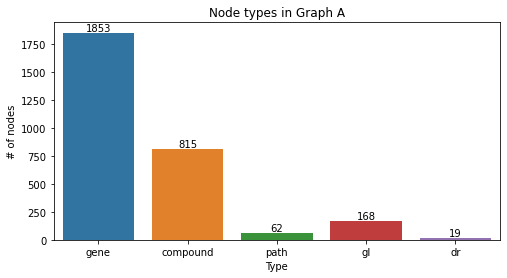

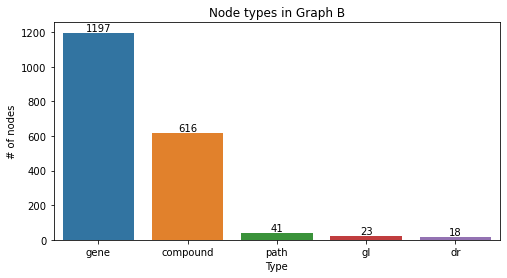

  5%|████▏                                                                        | 1628/30000 [02:50<48:32,  9.74it/s]

Graph A:
Graph with 2269 nodes and 4880 edges
Graph B:
Graph with 2543 nodes and 5481 edges
[1, 3, 4, 5, 8, 10, 11, 12, 13, 14, 16, 19, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 38, 39]


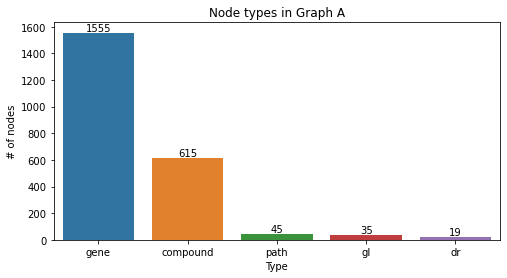

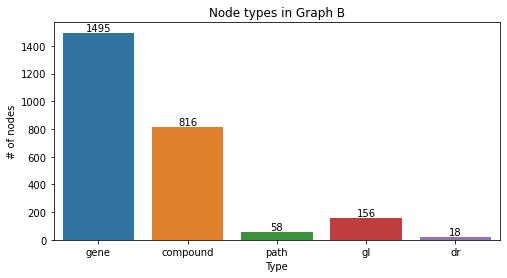

  6%|████▌                                                                        | 1778/30000 [03:05<46:39, 10.08it/s]

Graph A:
Graph with 1617 nodes and 3556 edges
Graph B:
Graph with 3195 nodes and 6818 edges
[2, 3, 5, 6, 7, 8, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 29, 32, 33, 35, 37, 38]


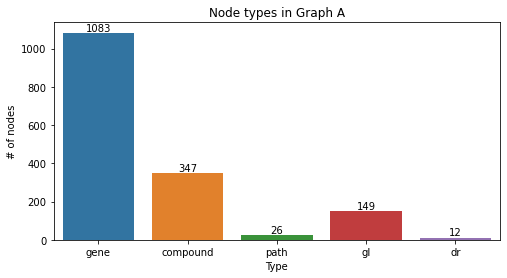

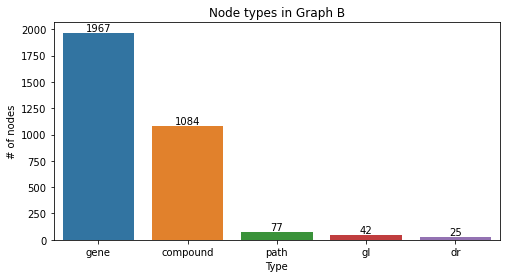

  7%|█████▍                                                                       | 2107/30000 [03:39<46:38,  9.97it/s]

Graph A:
Graph with 2704 nodes and 5459 edges
Graph B:
Graph with 2108 nodes and 4659 edges
[1, 3, 4, 5, 6, 9, 13, 14, 16, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 36, 38]


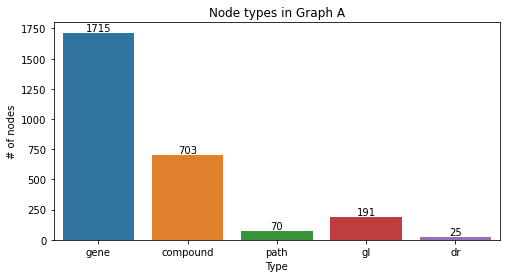

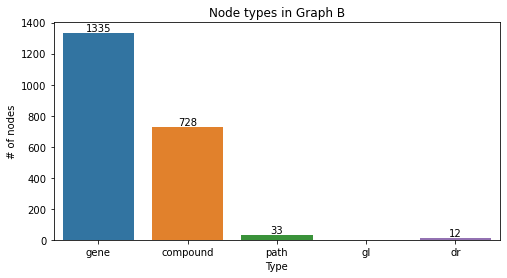

  7%|█████▌                                                                       | 2160/30000 [03:44<47:47,  9.71it/s]

Graph A:
Graph with 2141 nodes and 4513 edges
Graph B:
Graph with 2671 nodes and 5814 edges
[1, 3, 4, 9, 10, 11, 12, 13, 14, 16, 19, 21, 24, 26, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38]


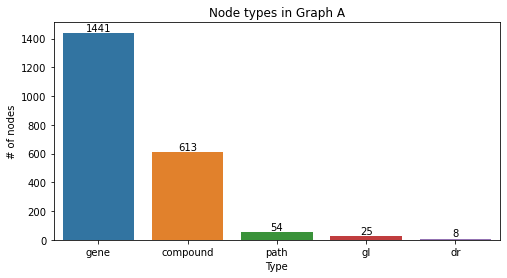

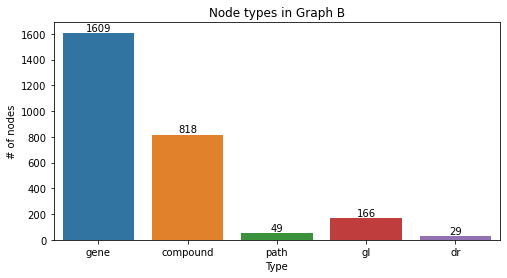

  8%|█████▊                                                                       | 2266/30000 [03:56<45:34, 10.14it/s]

Graph A:
Graph with 2096 nodes and 3759 edges
Graph B:
Graph with 2716 nodes and 6618 edges
[0, 1, 3, 6, 9, 10, 13, 14, 16, 17, 18, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37, 39]


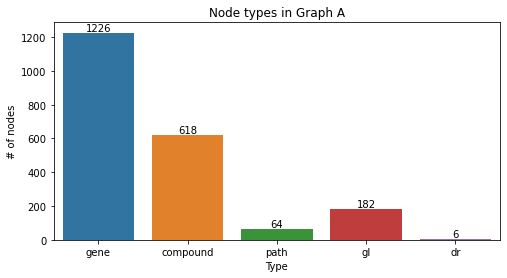

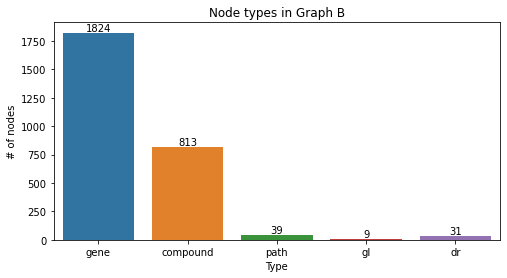

  8%|█████▉                                                                       | 2293/30000 [04:00<53:48,  8.58it/s]

Graph A:
Graph with 2061 nodes and 4467 edges
Graph B:
Graph with 2751 nodes and 5955 edges
[0, 2, 3, 4, 5, 8, 9, 10, 13, 16, 17, 18, 20, 25, 26, 32, 33, 34, 36, 38, 39]


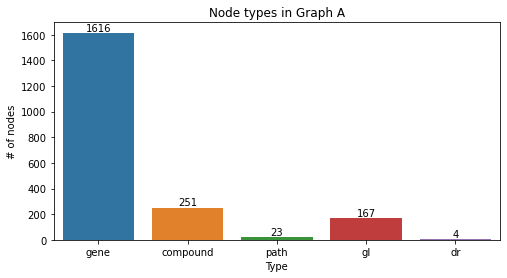

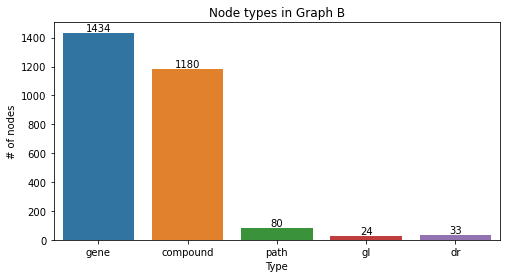

  8%|██████▍                                                                      | 2532/30000 [04:24<45:04, 10.16it/s]

Graph A:
Graph with 3136 nodes and 7802 edges
Graph B:
Graph with 1676 nodes and 2895 edges
[2, 6, 8, 10, 11, 12, 16, 19, 20, 21, 22, 23, 34, 39]


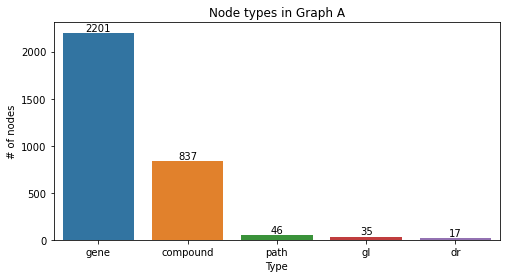

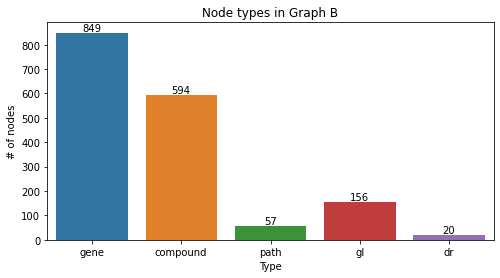

  9%|██████▋                                                                      | 2592/30000 [04:30<52:12,  8.75it/s]

Graph A:
Graph with 1412 nodes and 2669 edges
Graph B:
Graph with 3400 nodes and 8083 edges
[0, 1, 2, 3, 6, 7, 8, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 37, 38]


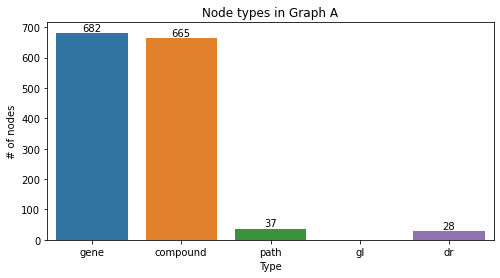

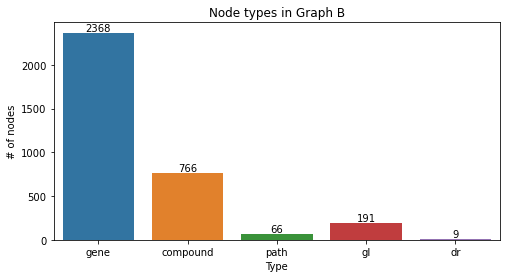

  9%|██████▉                                                                      | 2696/30000 [04:40<36:51, 12.35it/s]

Graph A:
Graph with 2648 nodes and 6402 edges
Graph B:
Graph with 2164 nodes and 4310 edges
[2, 3, 5, 6, 9, 11, 13, 19, 21, 22, 24, 25, 26, 33, 34, 37, 38]


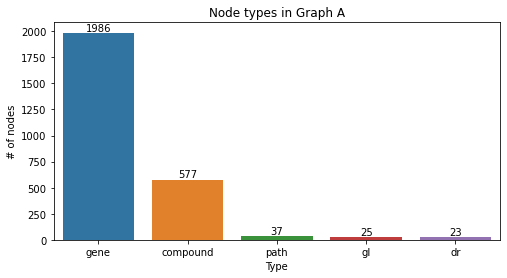

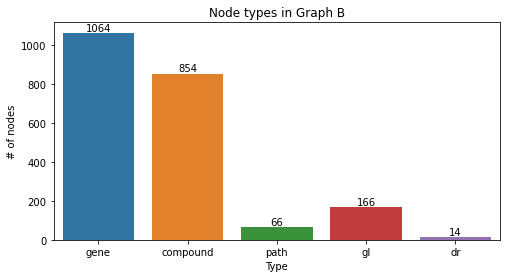

 10%|███████▍                                                                     | 2913/30000 [05:01<46:14,  9.76it/s]

Graph A:
Graph with 2343 nodes and 5013 edges
Graph B:
Graph with 2469 nodes and 5288 edges
[0, 1, 4, 5, 7, 8, 9, 12, 14, 15, 16, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 39]


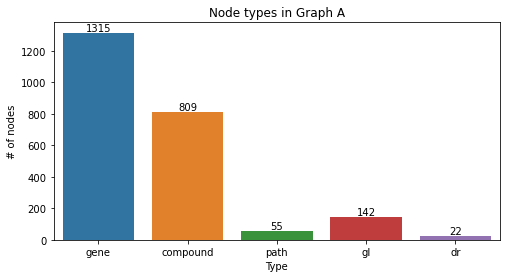

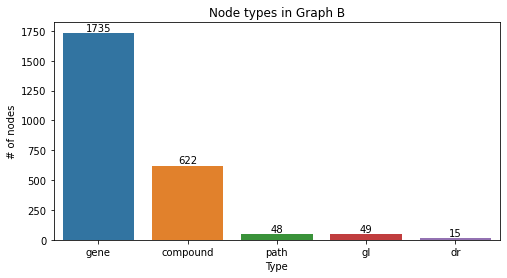

 11%|████████▋                                                                    | 3361/30000 [05:46<45:29,  9.76it/s]

Graph A:
Graph with 2338 nodes and 4956 edges
Graph B:
Graph with 2474 nodes and 5344 edges
[1, 3, 5, 6, 8, 9, 10, 12, 14, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38]


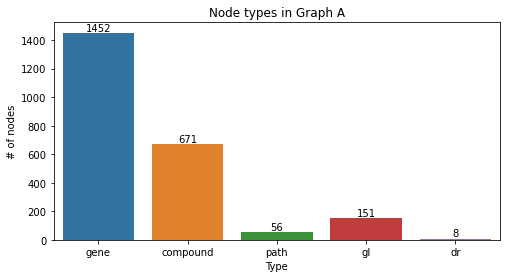

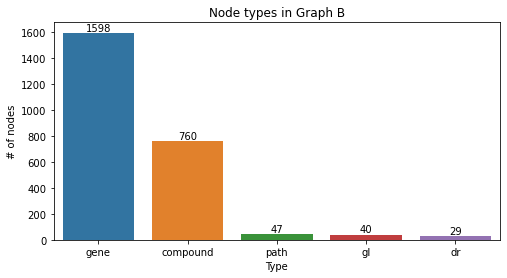

 12%|████████▉                                                                    | 3477/30000 [05:57<42:05, 10.50it/s]

Graph A:
Graph with 3059 nodes and 6666 edges
Graph B:
Graph with 1753 nodes and 3622 edges
[1, 2, 4, 8, 11, 14, 16, 20, 27, 28, 30, 31, 32, 34, 38, 39]


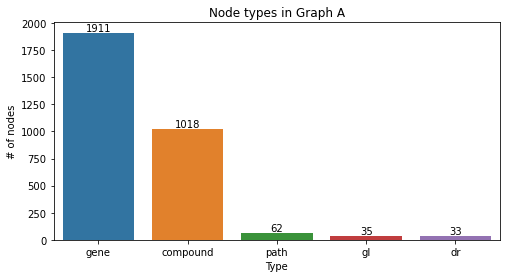

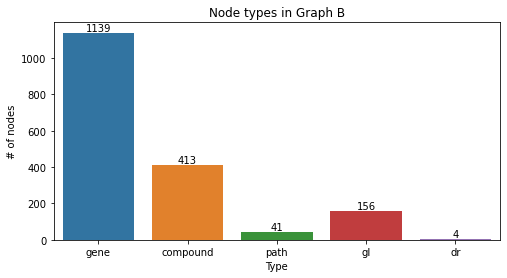

 14%|██████████▍                                                                  | 4084/30000 [06:57<41:16, 10.47it/s]

Graph A:
Graph with 3423 nodes and 7391 edges
Graph B:
Graph with 1389 nodes and 2951 edges
[1, 2, 8, 14, 16, 21, 23, 25, 26, 27, 28, 30, 31, 33, 34, 36]


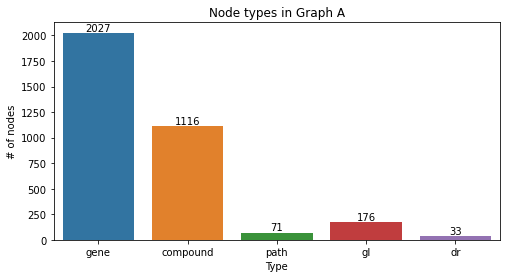

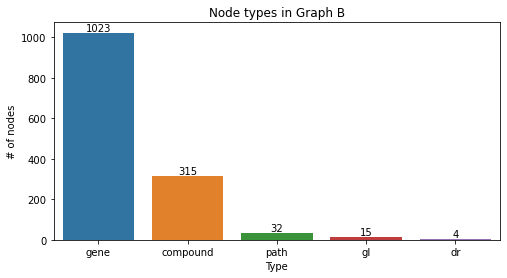

 15%|███████████▊                                                                 | 4585/30000 [07:49<36:28, 11.61it/s]

Graph A:
Graph with 1300 nodes and 2432 edges
Graph B:
Graph with 3512 nodes and 8559 edges
[0, 1, 2, 4, 7, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 37, 38, 39]


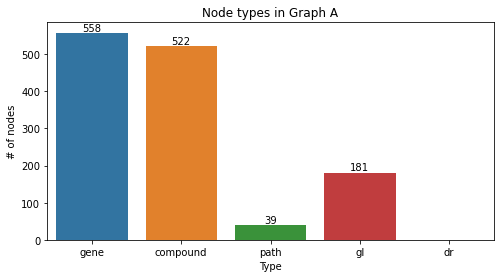

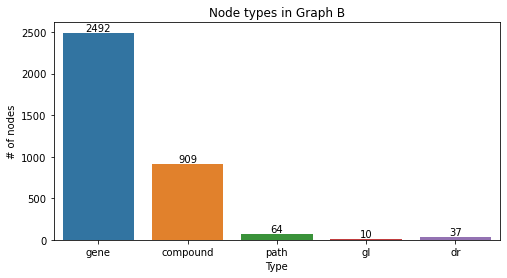

 16%|████████████▏                                                                | 4729/30000 [08:04<44:40,  9.43it/s]

Graph A:
Graph with 3507 nodes and 7847 edges
Graph B:
Graph with 1305 nodes and 2703 edges
[6, 11, 12, 17, 18, 19, 20, 21, 26, 33, 37]


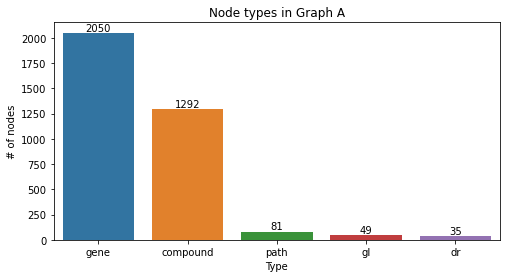

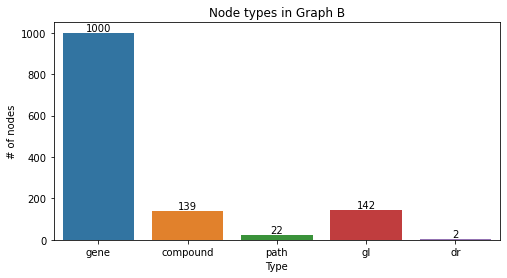

 16%|████████████▏                                                                | 4741/30000 [08:06<51:36,  8.16it/s]

Graph A:
Graph with 2639 nodes and 6612 edges
Graph B:
Graph with 2173 nodes and 4093 edges
[2, 3, 4, 5, 10, 11, 19, 20, 22, 24, 25, 29, 33, 36, 37, 38]


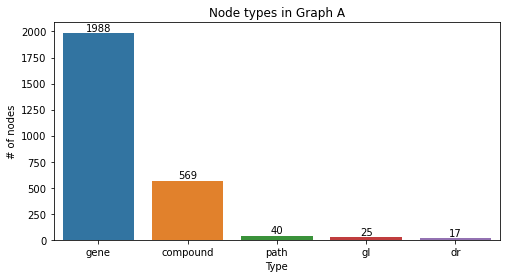

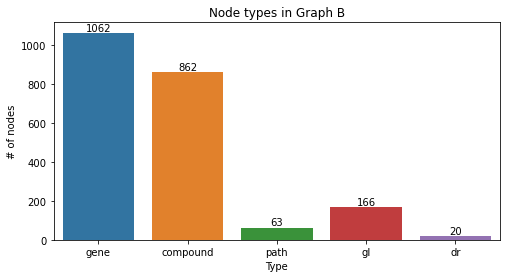

 16%|████████████▏                                                                | 4750/30000 [08:07<46:32,  9.04it/s]

Graph A:
Graph with 1944 nodes and 4065 edges
Graph B:
Graph with 2868 nodes and 6172 edges
[1, 2, 4, 6, 7, 9, 11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38]


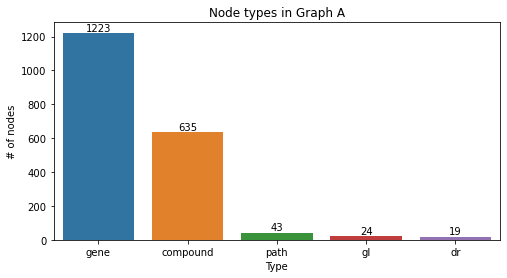

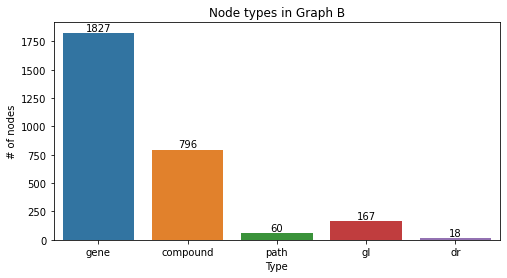

 17%|█████████████▏                                                               | 5139/30000 [08:47<35:46, 11.58it/s]

Graph A:
Graph with 3227 nodes and 6923 edges
Graph B:
Graph with 1585 nodes and 3394 edges
[1, 6, 9, 10, 11, 14, 16, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38]


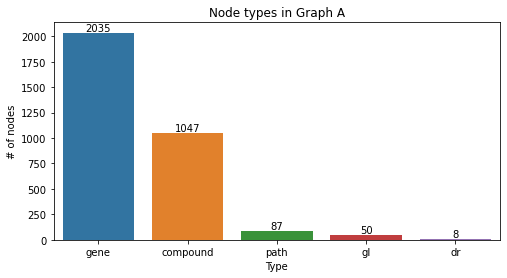

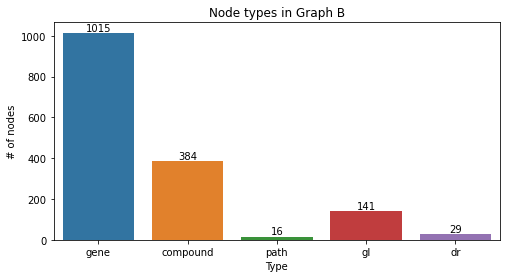

 18%|█████████████▌                                                               | 5275/30000 [09:02<37:08, 11.09it/s]

Graph A:
Graph with 2656 nodes and 5167 edges
Graph B:
Graph with 2156 nodes and 5211 edges
[1, 4, 5, 6, 8, 9, 12, 14, 16, 17, 18, 21, 23, 25, 27, 28, 29, 30, 31, 33, 34, 35, 37, 38]


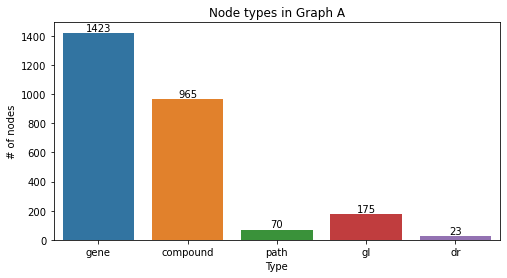

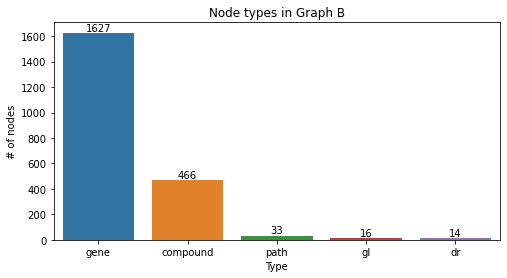

 20%|███████████████▌                                                             | 6050/30000 [10:23<46:28,  8.59it/s]

Graph A:
Graph with 3696 nodes and 8919 edges
Graph B:
Graph with 1116 nodes and 1870 edges
[4, 6, 8, 12, 13, 19, 20, 23, 24, 32, 33, 34, 38]


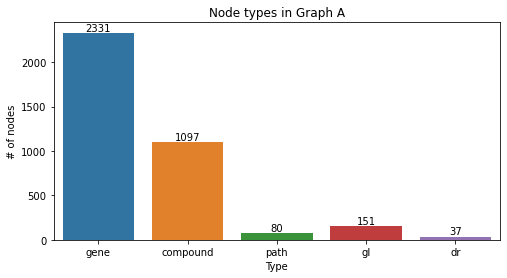

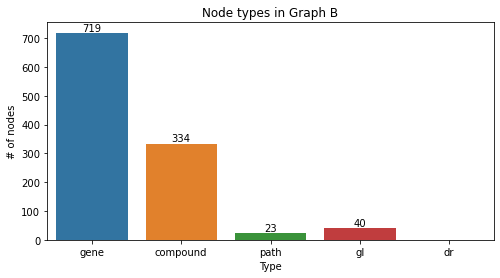

 21%|████████████████▏                                                            | 6314/30000 [10:51<42:58,  9.19it/s]

Graph A:
Graph with 2197 nodes and 4916 edges
Graph B:
Graph with 2615 nodes and 5531 edges
[0, 2, 3, 4, 6, 8, 9, 11, 17, 18, 20, 21, 22, 24, 29, 32, 33, 35, 36, 37, 39]


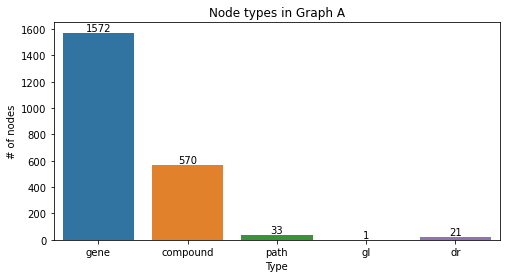

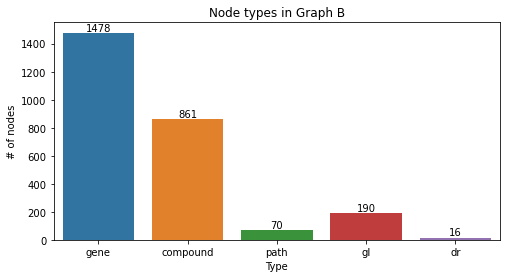

 22%|████████████████▌                                                            | 6473/30000 [11:08<38:57, 10.07it/s]

Graph A:
Graph with 3036 nodes and 6842 edges
Graph B:
Graph with 1776 nodes and 3569 edges
[2, 6, 10, 11, 16, 17, 18, 23, 26, 29, 34, 35, 36, 37, 38, 39]


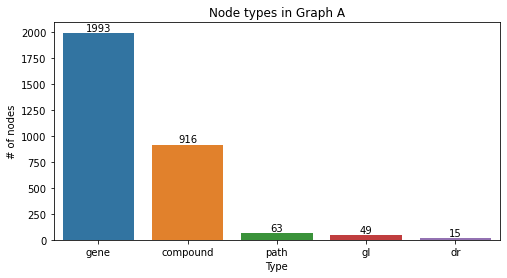

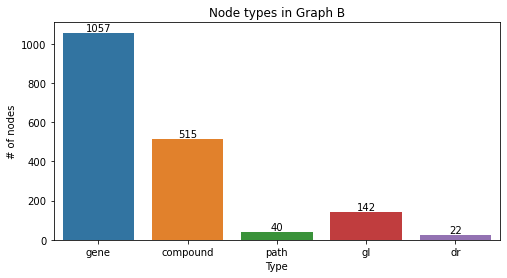

 23%|█████████████████▌                                                           | 6838/30000 [11:46<33:35, 11.49it/s]

Graph A:
Graph with 2713 nodes and 6542 edges
Graph B:
Graph with 2099 nodes and 3967 edges
[0, 3, 4, 5, 8, 9, 10, 12, 16, 19, 20, 21, 23, 24, 25, 26, 32, 34, 36, 37]


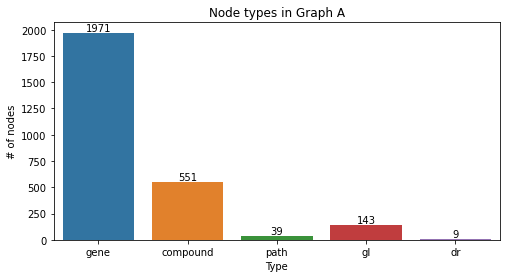

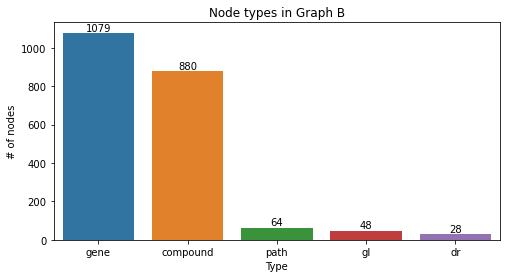

 23%|█████████████████▊                                                           | 6930/30000 [11:56<38:02, 10.11it/s]

Graph A:
Graph with 2498 nodes and 5437 edges
Graph B:
Graph with 2314 nodes and 4871 edges
[1, 2, 3, 5, 11, 12, 14, 16, 21, 23, 24, 25, 27, 28, 29, 30, 31, 33, 34, 35, 37, 39]


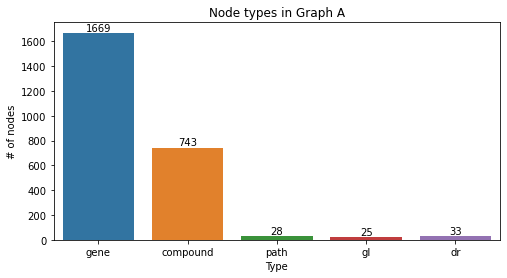

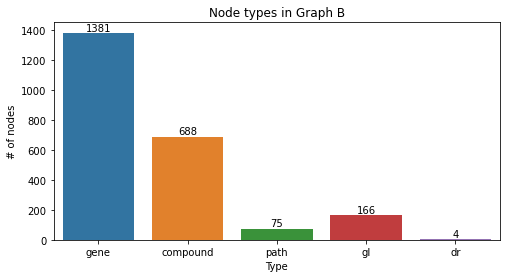

 24%|██████████████████▏                                                          | 7099/30000 [12:14<43:31,  8.77it/s]

Graph A:
Graph with 1654 nodes and 3397 edges
Graph B:
Graph with 3158 nodes and 7170 edges
[1, 2, 4, 5, 10, 11, 12, 14, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 38, 39]


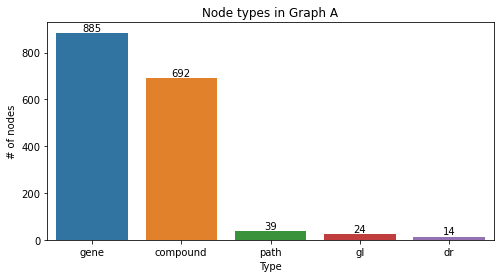

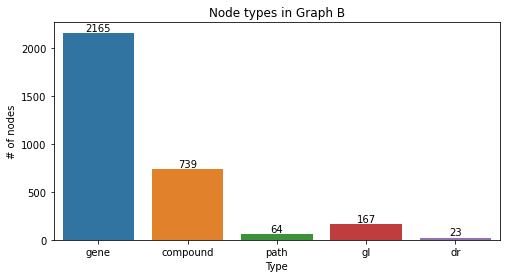

 24%|██████████████████▍                                                          | 7162/30000 [12:21<39:34,  9.62it/s]

Graph A:
Graph with 2937 nodes and 6264 edges
Graph B:
Graph with 1875 nodes and 4073 edges
[6, 7, 9, 11, 12, 15, 17, 18, 19, 21, 22, 25, 32, 33, 35, 39]


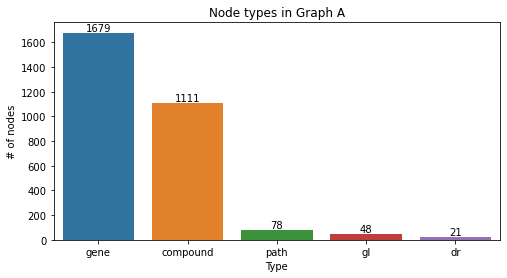

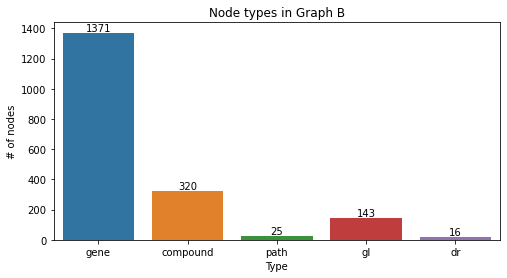

 24%|██████████████████▍                                                          | 7186/30000 [12:24<44:33,  8.53it/s]

Graph A:
Graph with 2353 nodes and 4730 edges
Graph B:
Graph with 2459 nodes and 6017 edges
[0, 1, 6, 7, 11, 14, 15, 16, 17, 18, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39]


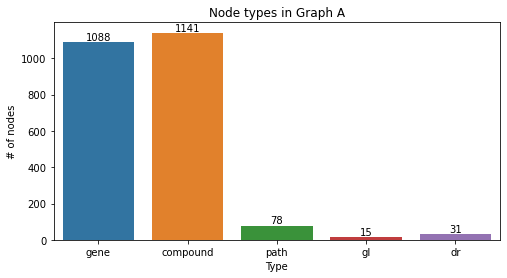

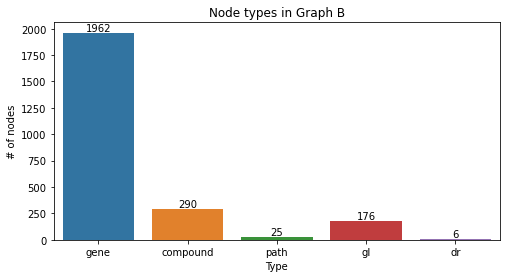

 24%|██████████████████▌                                                          | 7223/30000 [12:28<41:09,  9.22it/s]

Graph A:
Graph with 2980 nodes and 6379 edges
Graph B:
Graph with 1832 nodes and 3942 edges
[3, 5, 6, 12, 13, 16, 17, 18, 19, 21, 22, 23, 25, 29, 32, 33, 35, 37, 38, 39]


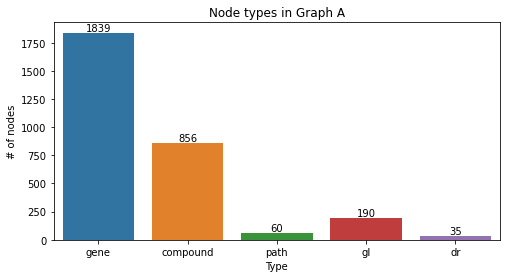

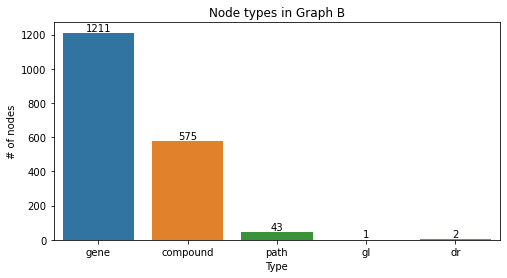

 26%|███████████████████▊                                                         | 7738/30000 [13:18<36:36, 10.14it/s]

Graph A:
Graph with 2426 nodes and 5398 edges
Graph B:
Graph with 2386 nodes and 4878 edges
[0, 2, 6, 9, 11, 12, 17, 18, 19, 20, 21, 24, 29, 34, 38]


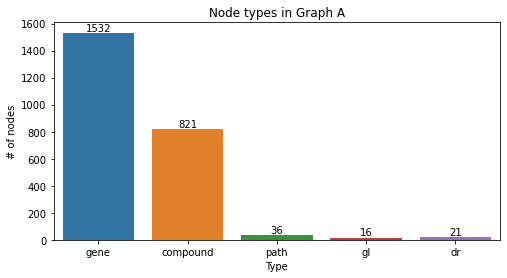

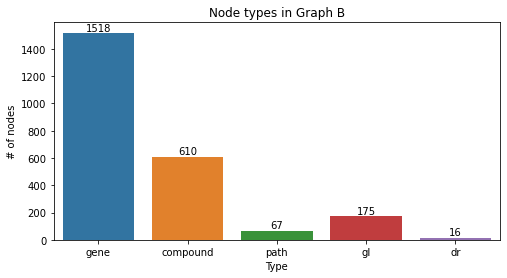

 26%|████████████████████                                                         | 7803/30000 [13:25<39:37,  9.34it/s]

Graph A:
Graph with 3005 nodes and 7217 edges
Graph B:
Graph with 1807 nodes and 3329 edges
[0, 2, 4, 5, 6, 13, 19, 20, 22, 23, 25, 29, 32, 35, 38, 39]


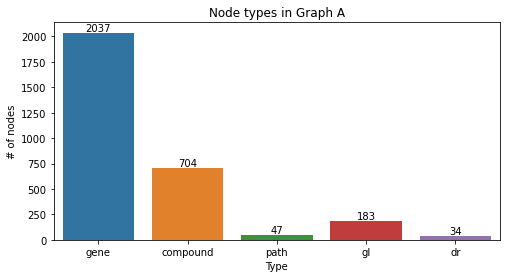

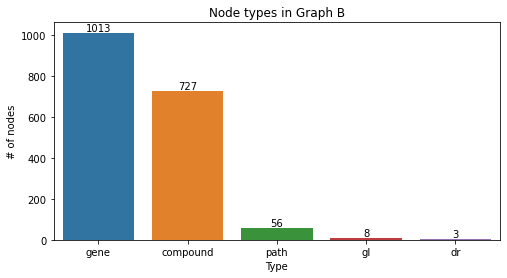

 28%|█████████████████████▍                                                       | 8349/30000 [14:21<35:45, 10.09it/s]

Graph A:
Graph with 1013 nodes and 1751 edges
Graph B:
Graph with 3799 nodes and 9098 edges
[0, 1, 2, 3, 6, 7, 9, 10, 11, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38]


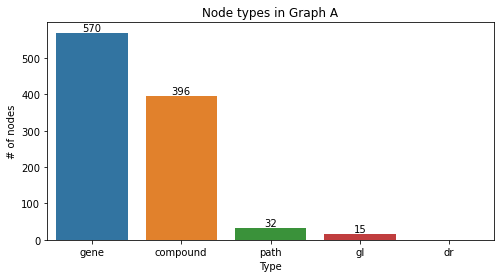

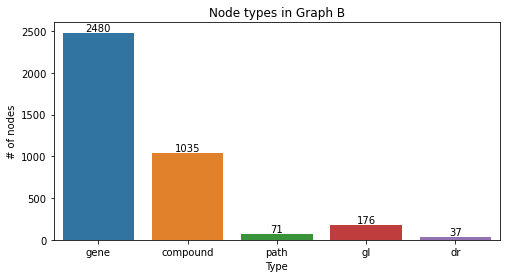

 28%|█████████████████████▌                                                       | 8387/30000 [14:25<32:36, 11.04it/s]

Graph A:
Graph with 3079 nodes and 7441 edges
Graph B:
Graph with 1733 nodes and 3040 edges
[4, 6, 7, 8, 10, 11, 12, 15, 19, 20, 22, 25, 29, 32, 33, 35, 36]


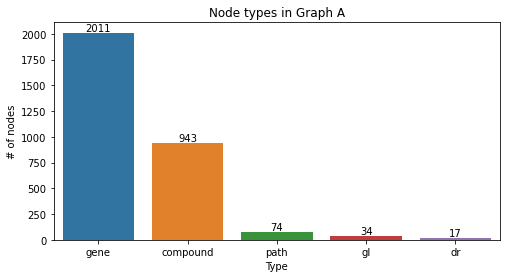

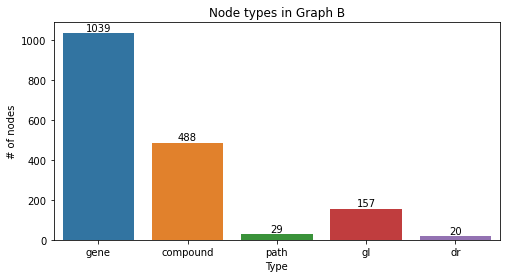

 28%|█████████████████████▋                                                       | 8461/30000 [14:33<39:51,  9.01it/s]

Graph A:
Graph with 2089 nodes and 3780 edges
Graph B:
Graph with 2723 nodes and 6593 edges
[1, 2, 3, 4, 6, 10, 13, 14, 16, 17, 18, 22, 27, 28, 30, 31, 32, 33, 34, 35]


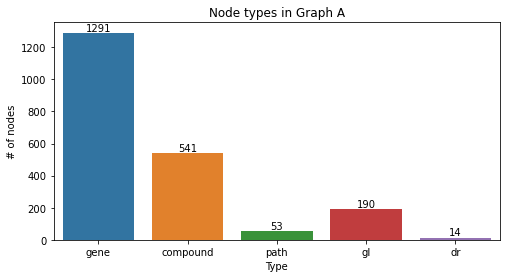

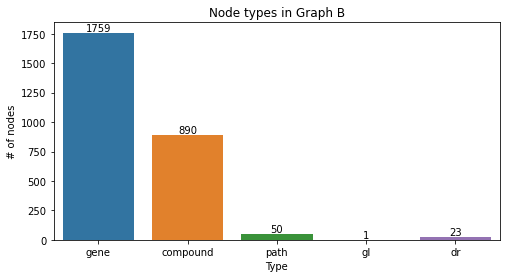

 28%|█████████████████████▋                                                       | 8466/30000 [14:33<43:57,  8.16it/s]

Graph A:
Graph with 2702 nodes and 5804 edges
Graph B:
Graph with 2110 nodes and 4647 edges
[1, 7, 11, 13, 14, 15, 16, 19, 23, 24, 27, 28, 29, 30, 31, 32, 34, 35, 36, 38, 39]


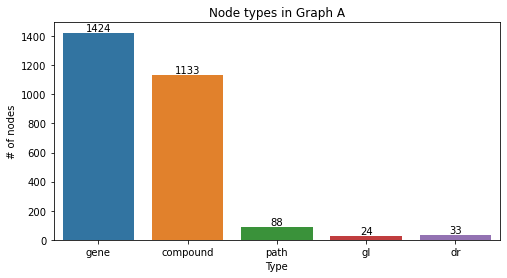

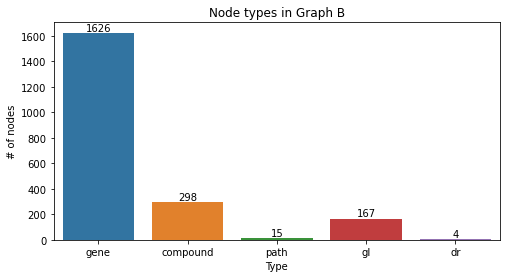

 29%|██████████████████████▎                                                      | 8670/30000 [14:54<33:37, 10.57it/s]

Graph A:
Graph with 2549 nodes and 5555 edges
Graph B:
Graph with 2263 nodes and 4826 edges
[0, 1, 4, 5, 6, 8, 11, 12, 13, 14, 16, 19, 22, 27, 28, 29, 30, 31, 33, 34, 35, 37, 39]


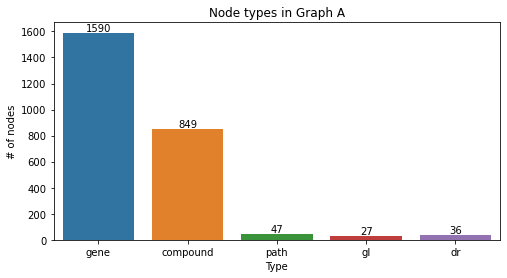

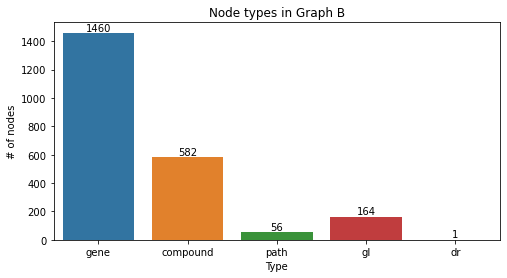

 31%|███████████████████████▊                                                     | 9275/30000 [15:54<32:12, 10.72it/s]

Graph A:
Graph with 2750 nodes and 5893 edges
Graph B:
Graph with 2062 nodes and 4541 edges
[0, 1, 9, 11, 12, 13, 14, 16, 19, 22, 26, 27, 28, 29, 30, 31, 35, 36, 37]


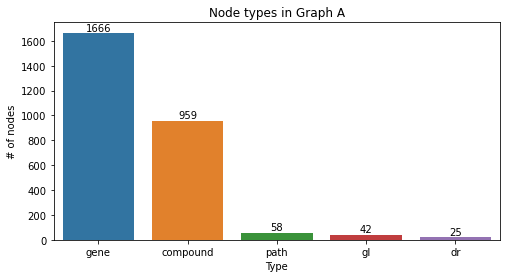

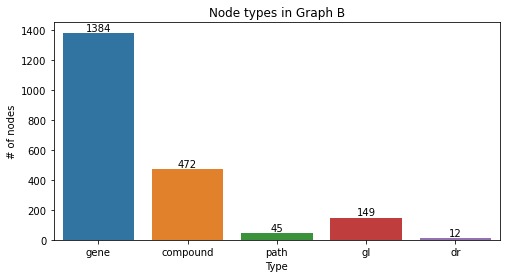

 31%|████████████████████████▏                                                    | 9444/30000 [16:11<31:28, 10.88it/s]

Graph A:
Graph with 1333 nodes and 2370 edges
Graph B:
Graph with 3479 nodes and 8517 edges
[0, 1, 2, 3, 5, 7, 9, 12, 14, 15, 16, 17, 18, 20, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 37]


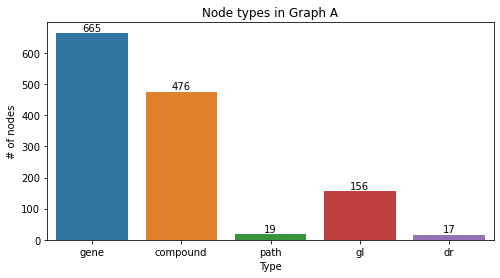

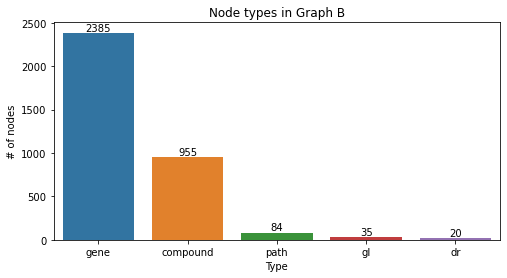

 32%|████████████████████████▊                                                    | 9654/30000 [16:33<38:46,  8.75it/s]

Graph A:
Graph with 2395 nodes and 5217 edges
Graph B:
Graph with 2417 nodes and 5082 edges
[5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 22, 24, 26, 32, 38, 39]


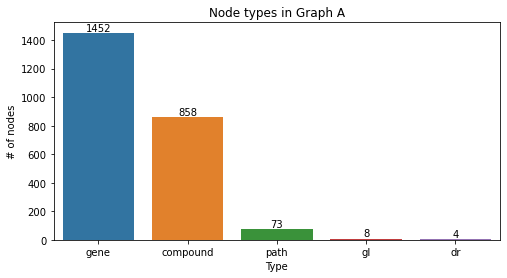

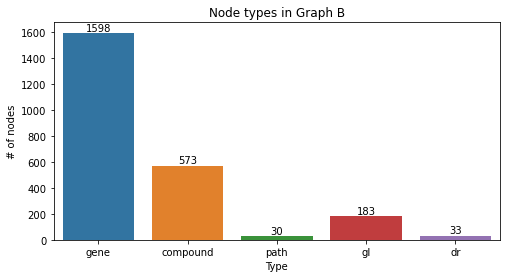

 33%|█████████████████████████▏                                                   | 9833/30000 [16:52<31:43, 10.59it/s]

Graph A:
Graph with 2259 nodes and 4640 edges
Graph B:
Graph with 2553 nodes and 5673 edges
[0, 1, 3, 4, 8, 9, 11, 13, 14, 16, 19, 21, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


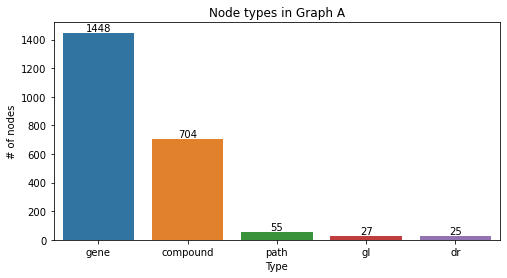

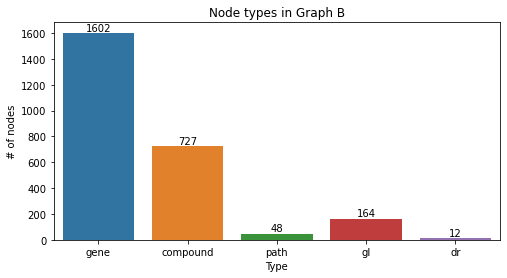

 33%|█████████████████████████▍                                                   | 9895/30000 [16:59<30:17, 11.06it/s]

Graph A:
Graph with 2244 nodes and 4850 edges
Graph B:
Graph with 2568 nodes and 5427 edges
[2, 3, 4, 5, 6, 12, 13, 17, 18, 19, 20, 21, 23, 24, 26, 32, 33, 34, 37, 39]


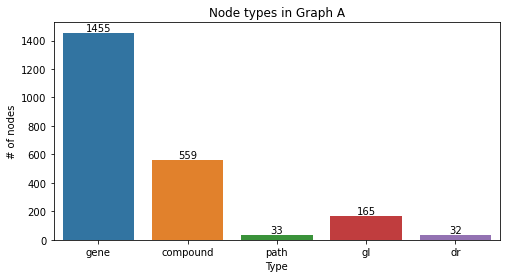

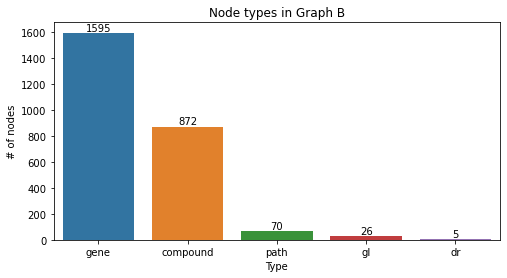

 33%|█████████████████████████▎                                                  | 10011/30000 [17:11<31:51, 10.46it/s]

Graph A:
Graph with 2276 nodes and 4925 edges
Graph B:
Graph with 2536 nodes and 5292 edges
[0, 3, 5, 8, 9, 10, 11, 12, 17, 18, 19, 20, 21, 23, 25, 26, 34, 35, 36, 39]


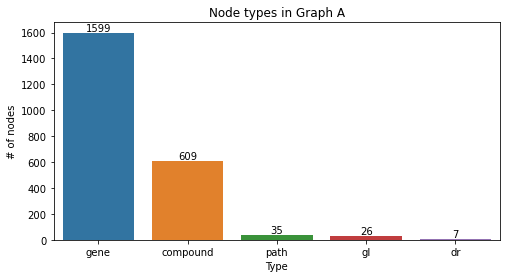

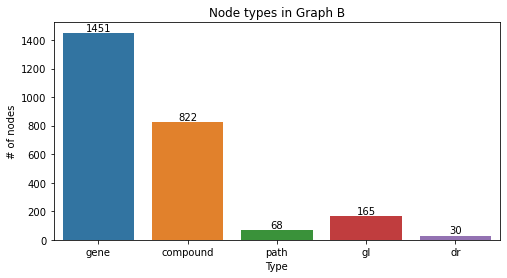

 37%|███████████████████████████▉                                                | 11028/30000 [18:56<29:05, 10.87it/s]

Graph A:
Graph with 2093 nodes and 4484 edges
Graph B:
Graph with 2719 nodes and 5769 edges
[0, 3, 4, 5, 6, 7, 8, 11, 15, 17, 18, 19, 20, 22, 24, 25, 26, 32, 34, 36, 38]


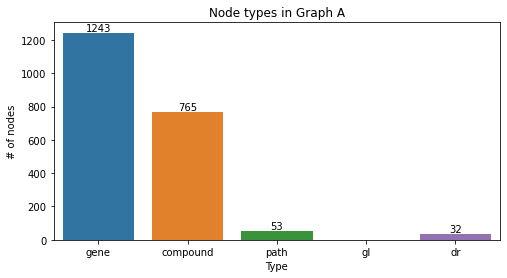

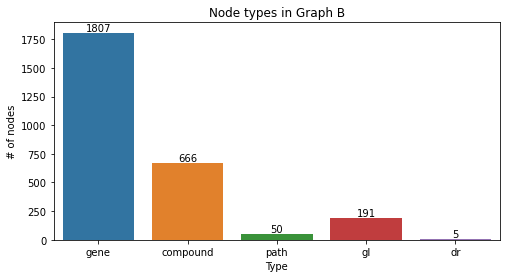

 37%|████████████████████████████                                                | 11055/30000 [18:59<36:06,  8.74it/s]

Graph A:
Graph with 2213 nodes and 4597 edges
Graph B:
Graph with 2599 nodes and 5749 edges
[0, 1, 2, 4, 5, 7, 9, 14, 15, 20, 21, 24, 26, 27, 28, 30, 31, 35, 36, 38, 39]


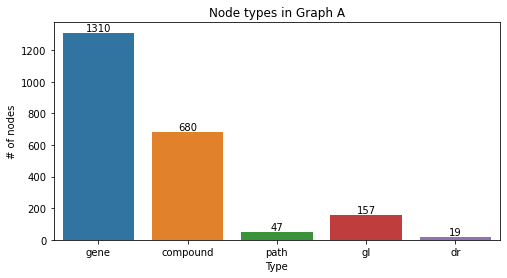

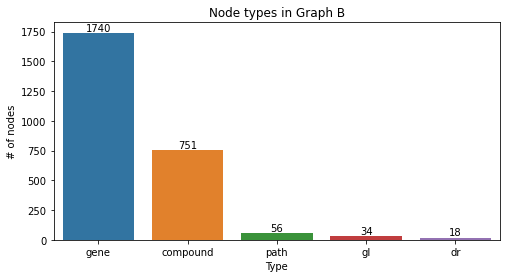

 37%|████████████████████████████▏                                               | 11131/30000 [19:07<32:52,  9.56it/s]

Graph A:
Graph with 2631 nodes and 5658 edges
Graph B:
Graph with 2181 nodes and 4700 edges
[0, 1, 2, 5, 6, 12, 14, 16, 19, 20, 22, 23, 25, 27, 28, 30, 31, 32, 33, 35, 38, 39]


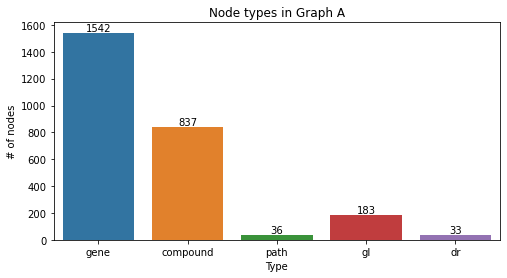

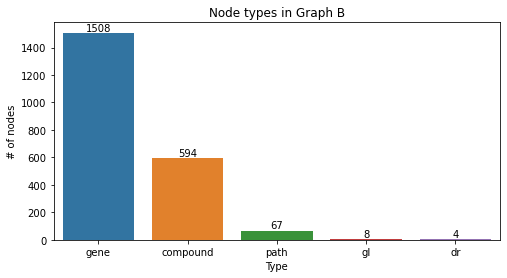

 38%|████████████████████████████▋                                               | 11339/30000 [19:30<31:57,  9.73it/s]

Graph A:
Graph with 1494 nodes and 2895 edges
Graph B:
Graph with 3318 nodes and 7611 edges
[0, 1, 2, 3, 4, 8, 11, 12, 13, 14, 17, 18, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 38, 39]


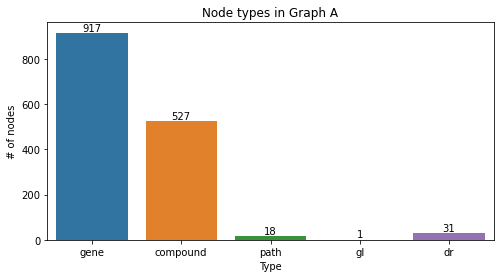

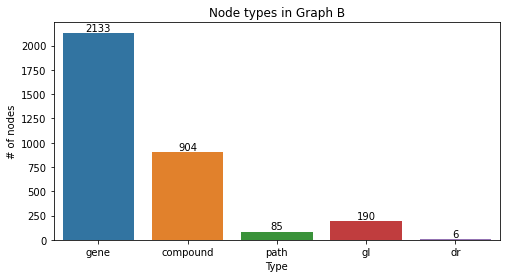

 39%|█████████████████████████████▎                                              | 11559/30000 [19:52<32:06,  9.57it/s]

Graph A:
Graph with 2002 nodes and 4270 edges
Graph B:
Graph with 2810 nodes and 6027 edges
[0, 1, 2, 5, 7, 10, 11, 12, 13, 14, 15, 27, 28, 29, 30, 31, 32, 33, 34, 36, 39]


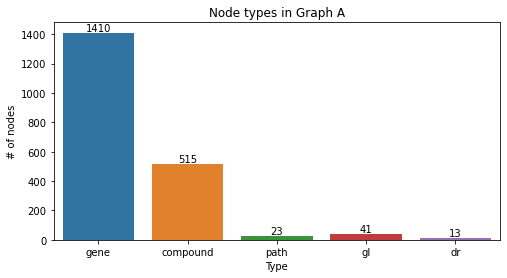

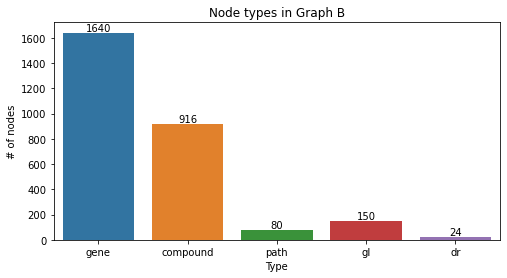

 39%|█████████████████████████████▎                                              | 11579/30000 [19:55<31:55,  9.62it/s]

Graph A:
Graph with 3431 nodes and 8011 edges
Graph B:
Graph with 1381 nodes and 2469 edges
[5, 6, 7, 8, 13, 15, 19, 24, 26, 29, 35, 36]


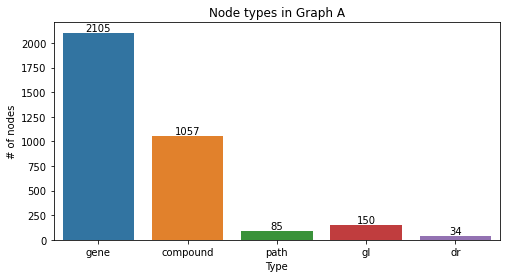

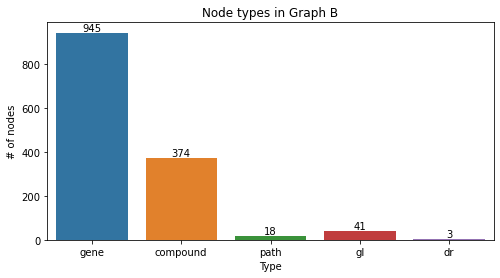

 39%|█████████████████████████████▌                                              | 11688/30000 [20:06<30:41,  9.95it/s]

Graph A:
Graph with 2165 nodes and 4416 edges
Graph B:
Graph with 2647 nodes and 5965 edges
[1, 2, 4, 5, 6, 7, 8, 9, 14, 15, 19, 21, 22, 23, 27, 28, 29, 30, 31, 32, 37, 38]


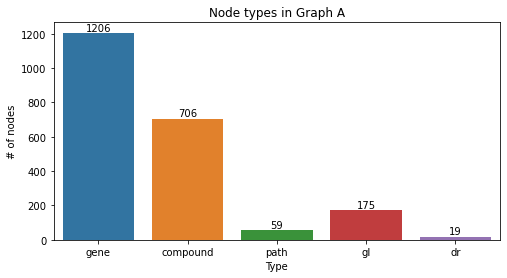

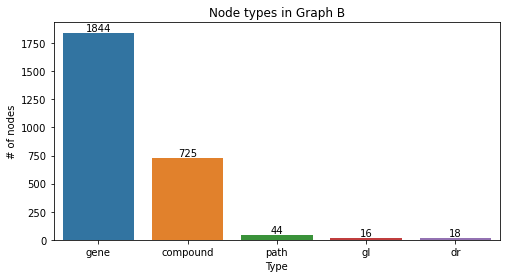

 40%|██████████████████████████████▎                                             | 11954/30000 [20:34<31:40,  9.50it/s]

Graph A:
Graph with 2698 nodes and 6397 edges
Graph B:
Graph with 2114 nodes and 4293 edges
[2, 3, 7, 8, 9, 11, 13, 15, 23, 26, 29, 32, 37, 38]


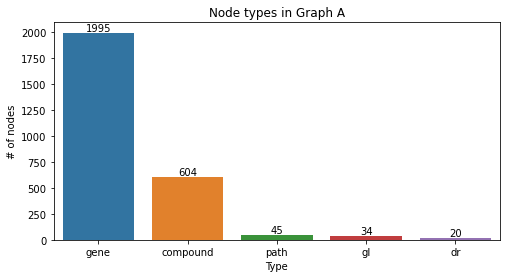

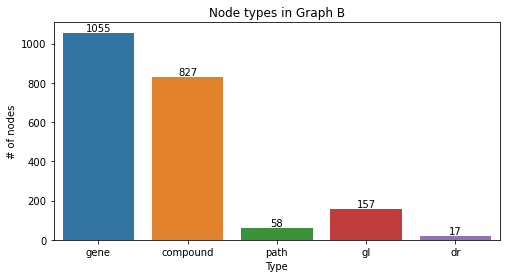

 40%|██████████████████████████████▌                                             | 12050/30000 [20:43<29:12, 10.24it/s]

Graph A:
Graph with 2546 nodes and 5571 edges
Graph B:
Graph with 2266 nodes and 4702 edges
[0, 3, 10, 11, 13, 16, 17, 18, 19, 21, 22, 24, 25, 26, 34, 36, 37, 38]


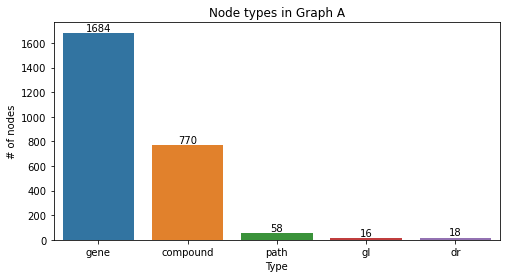

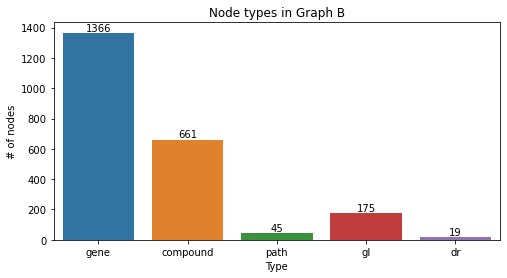

 42%|████████████████████████████████▎                                           | 12738/30000 [21:56<28:08, 10.23it/s]

Graph A:
Graph with 3032 nodes and 6858 edges
Graph B:
Graph with 1780 nodes and 3584 edges
[0, 4, 8, 11, 12, 17, 18, 19, 23, 24, 26, 32, 33, 34, 35, 39]


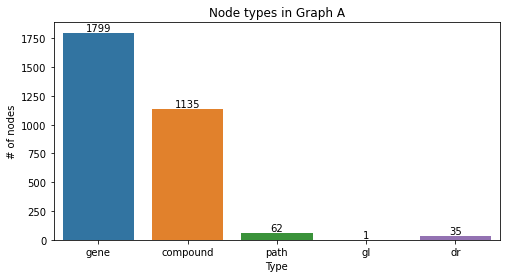

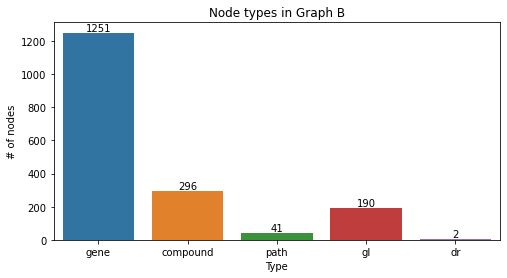

 42%|████████████████████████████████▎                                           | 12742/30000 [21:57<43:33,  6.60it/s]

Graph A:
Graph with 2675 nodes and 5656 edges
Graph B:
Graph with 2137 nodes and 4707 edges
[0, 1, 3, 4, 8, 10, 12, 14, 16, 19, 20, 25, 27, 28, 30, 31, 33, 34, 35, 37]


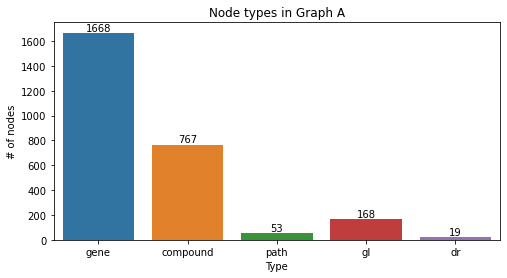

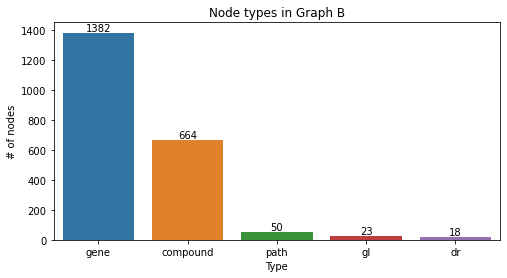

 43%|████████████████████████████████▊                                           | 12931/30000 [22:17<29:11,  9.75it/s]

Graph A:
Graph with 2340 nodes and 5227 edges
Graph B:
Graph with 2472 nodes and 5095 edges
[0, 2, 5, 6, 7, 11, 12, 15, 16, 17, 18, 21, 22, 24, 26, 33, 34, 37, 38, 39]


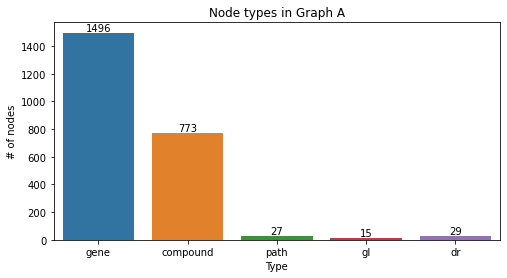

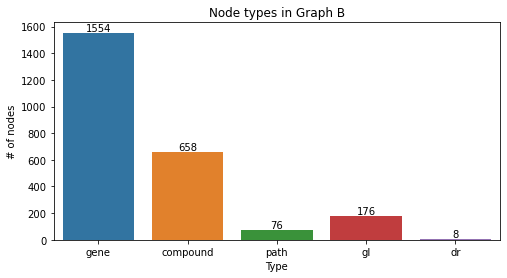

 44%|█████████████████████████████████▎                                          | 13147/30000 [22:39<25:37, 10.96it/s]

Graph A:
Graph with 2096 nodes and 4628 edges
Graph B:
Graph with 2716 nodes and 5735 edges
[2, 5, 6, 7, 9, 11, 12, 13, 15, 17, 18, 20, 21, 22, 23, 26, 29, 33, 36, 38]


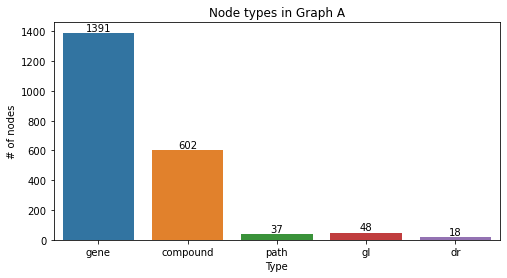

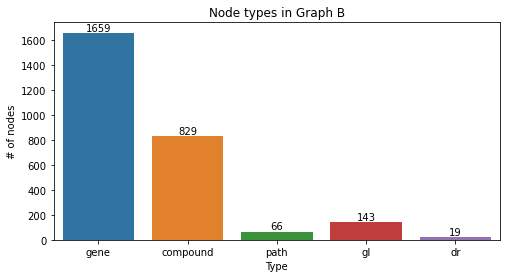

 45%|█████████████████████████████████▊                                          | 13358/30000 [23:00<24:29, 11.33it/s]

Graph A:
Graph with 2744 nodes and 6028 edges
Graph B:
Graph with 2068 nodes and 4264 edges
[2, 7, 10, 11, 15, 17, 18, 21, 23, 29, 33, 34, 36, 37, 38, 39]


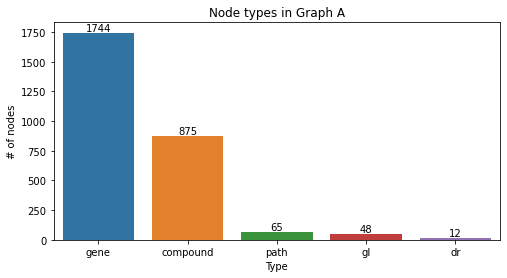

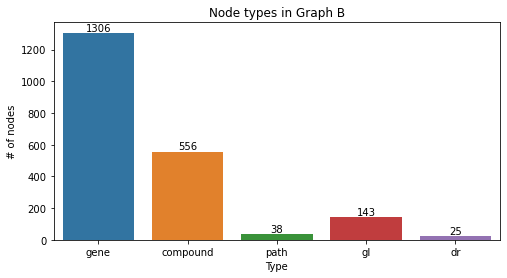

 45%|█████████████████████████████████▉                                          | 13408/30000 [23:05<28:01,  9.87it/s]

Graph A:
Graph with 2512 nodes and 6125 edges
Graph B:
Graph with 2300 nodes and 4253 edges
[0, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 22, 24, 26, 32, 33, 34, 35, 39]


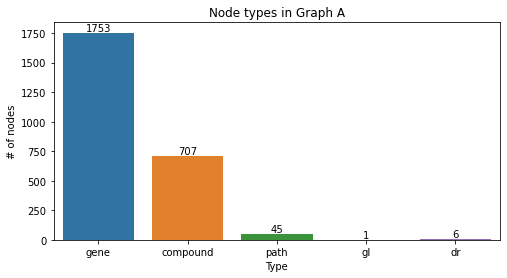

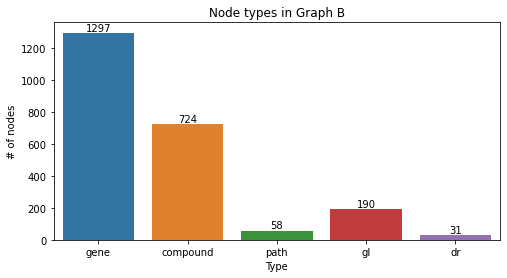

 45%|██████████████████████████████████                                          | 13426/30000 [23:08<28:45,  9.61it/s]

Graph A:
Graph with 1799 nodes and 3368 edges
Graph B:
Graph with 3013 nodes and 6985 edges
[0, 1, 2, 5, 6, 9, 10, 11, 14, 16, 17, 18, 21, 22, 26, 27, 28, 29, 30, 31, 35, 38, 39]


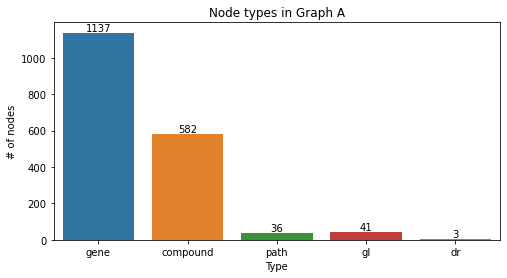

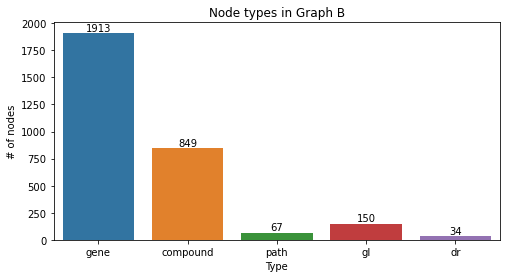

 45%|██████████████████████████████████                                          | 13432/30000 [23:08<32:21,  8.53it/s]

Graph A:
Graph with 3119 nodes and 7580 edges
Graph B:
Graph with 1693 nodes and 3501 edges
[2, 3, 5, 6, 8, 9, 10, 12, 23, 33, 35, 36, 37, 38, 39]


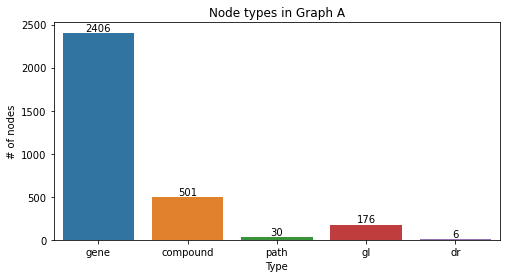

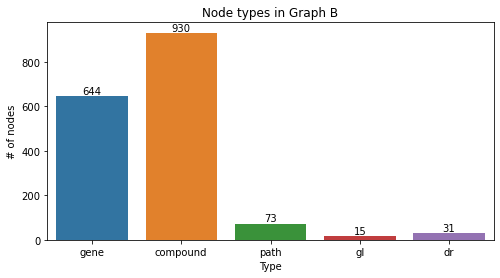

 45%|██████████████████████████████████                                          | 13442/30000 [23:10<36:21,  7.59it/s]

Graph A:
Graph with 1760 nodes and 3103 edges
Graph B:
Graph with 3052 nodes and 7429 edges
[0, 1, 3, 5, 6, 9, 11, 12, 13, 14, 17, 18, 19, 21, 22, 25, 26, 27, 28, 30, 31, 32, 35, 36, 37, 38, 39]


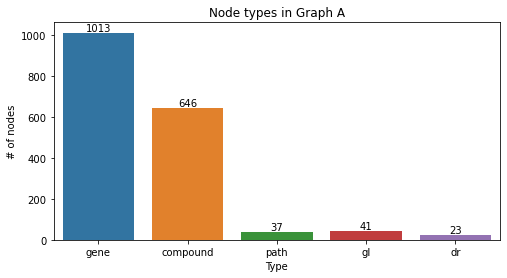

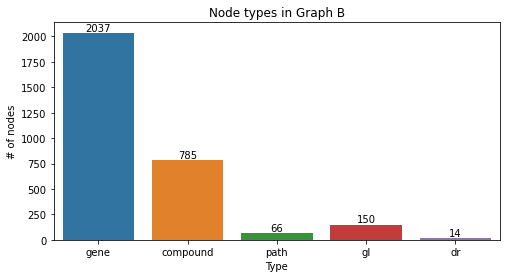

 45%|██████████████████████████████████▎                                         | 13520/30000 [23:18<30:50,  8.91it/s]

Graph A:
Graph with 2324 nodes and 4877 edges
Graph B:
Graph with 2488 nodes and 5299 edges
[1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 22, 23, 24, 27, 28, 29, 30, 31, 33, 34, 36, 37, 38]


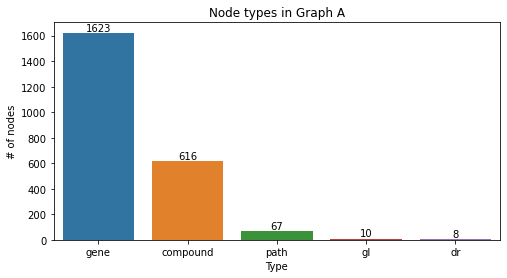

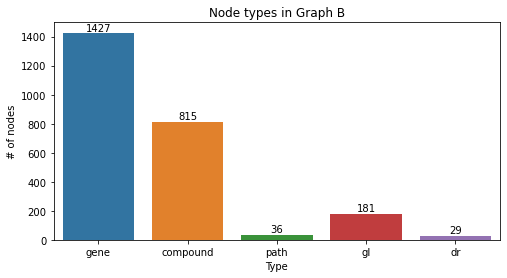

 45%|██████████████████████████████████▌                                         | 13638/30000 [23:30<31:11,  8.74it/s]

Graph A:
Graph with 1505 nodes and 2790 edges
Graph B:
Graph with 3307 nodes and 7722 edges
[0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 14, 16, 17, 18, 20, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 39]


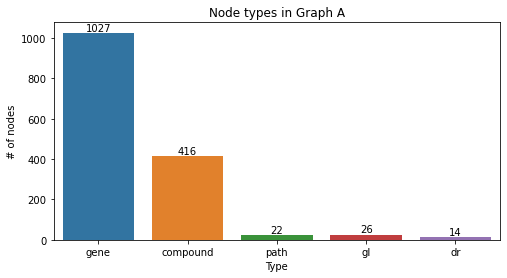

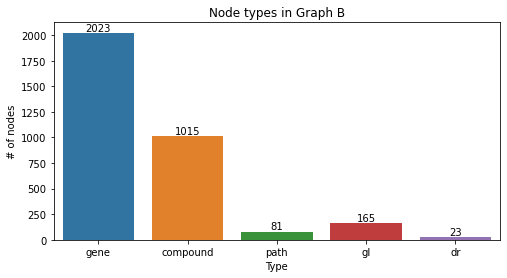

 46%|██████████████████████████████████▊                                         | 13725/30000 [23:40<29:36,  9.16it/s]

Graph A:
Graph with 3296 nodes and 7892 edges
Graph B:
Graph with 1516 nodes and 2677 edges
[2, 4, 6, 7, 8, 15, 16, 20, 24, 29, 32, 37, 39]


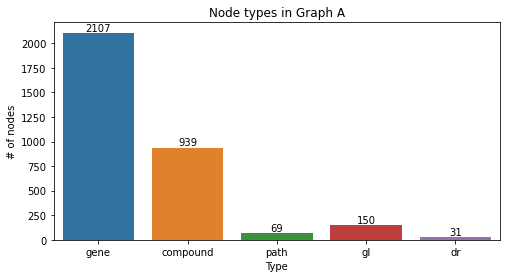

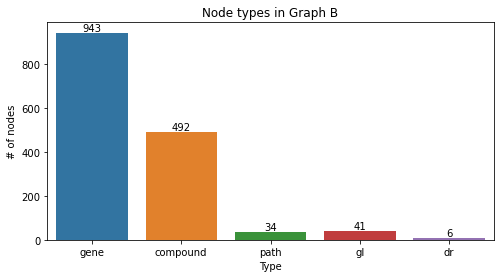

 46%|██████████████████████████████████▊                                         | 13762/30000 [23:43<24:16, 11.15it/s]

Graph A:
Graph with 1831 nodes and 3595 edges
Graph B:
Graph with 2981 nodes and 7472 edges
[0, 1, 4, 6, 7, 10, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 38]


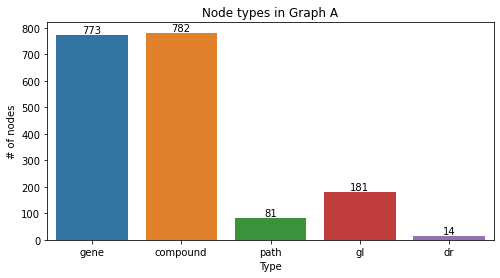

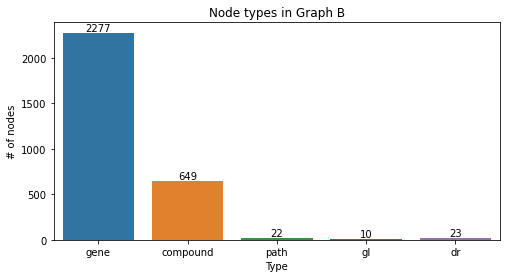

 46%|███████████████████████████████████                                         | 13840/30000 [23:52<24:38, 10.93it/s]

Graph A:
Graph with 2886 nodes and 6345 edges
Graph B:
Graph with 1926 nodes and 4118 edges
[0, 1, 6, 10, 11, 14, 16, 19, 21, 24, 26, 27, 28, 30, 31, 32, 34, 35]


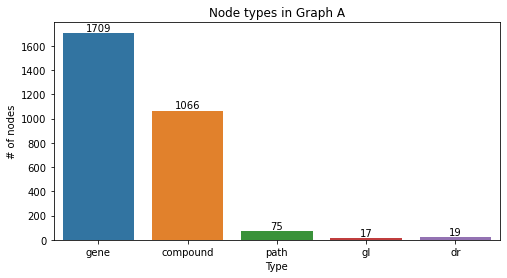

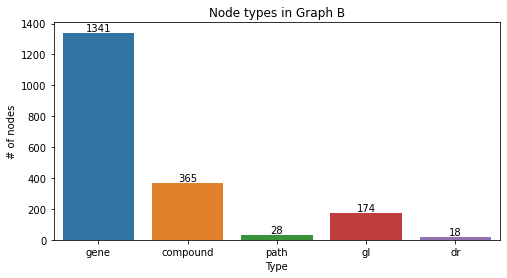

 47%|███████████████████████████████████▋                                        | 14075/30000 [24:15<26:11, 10.14it/s]

Graph A:
Graph with 2696 nodes and 5744 edges
Graph B:
Graph with 2116 nodes and 4633 edges
[0, 1, 3, 4, 12, 14, 16, 19, 20, 22, 23, 24, 27, 28, 29, 30, 31, 32, 37, 38, 39]


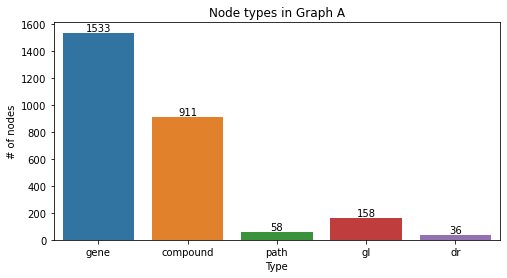

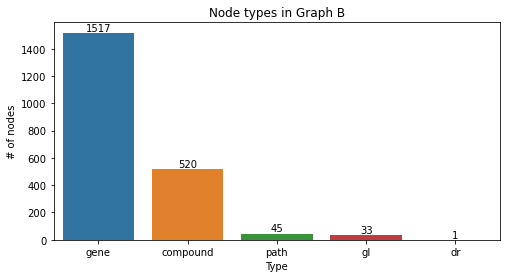

 48%|████████████████████████████████████▎                                       | 14340/30000 [24:44<29:27,  8.86it/s]

Graph A:
Graph with 2311 nodes and 5213 edges
Graph B:
Graph with 2501 nodes and 5153 edges
[2, 3, 4, 5, 11, 12, 13, 16, 17, 18, 20, 22, 24, 26, 32, 34, 35, 36]


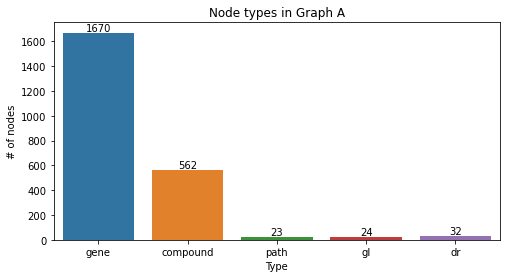

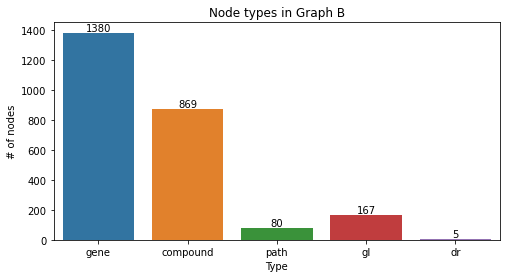

 48%|████████████████████████████████████▎                                       | 14343/30000 [24:45<45:41,  5.71it/s]

Graph A:
Graph with 2603 nodes and 5710 edges
Graph B:
Graph with 2209 nodes and 4552 edges
[0, 2, 7, 8, 10, 12, 15, 16, 17, 18, 21, 22, 23, 25, 33, 34, 35, 37, 38, 39]


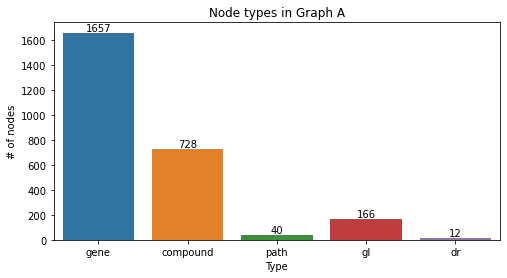

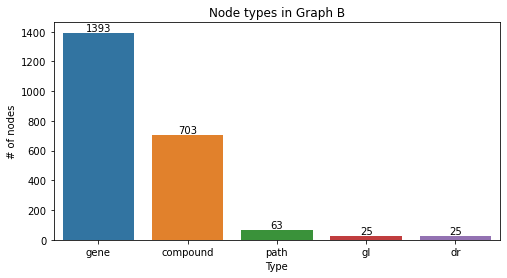

 49%|█████████████████████████████████████                                       | 14622/30000 [25:14<30:33,  8.39it/s]

Graph A:
Graph with 2250 nodes and 4717 edges
Graph B:
Graph with 2562 nodes and 5473 edges
[0, 3, 4, 5, 8, 9, 10, 13, 16, 17, 18, 19, 22, 24, 26, 34, 35, 36, 38]


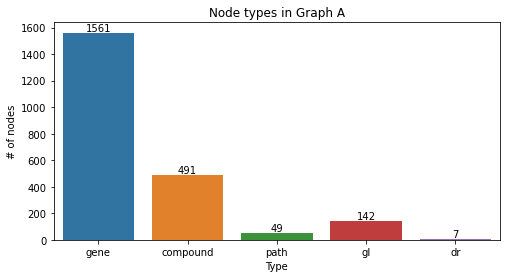

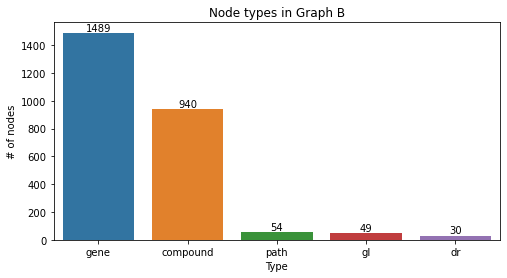

 49%|█████████████████████████████████████▏                                      | 14672/30000 [25:20<25:50,  9.88it/s]

Graph A:
Graph with 1844 nodes and 3951 edges
Graph B:
Graph with 2968 nodes and 6518 edges
[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20, 26, 27, 28, 29, 30, 31, 33, 34, 37, 38, 39]


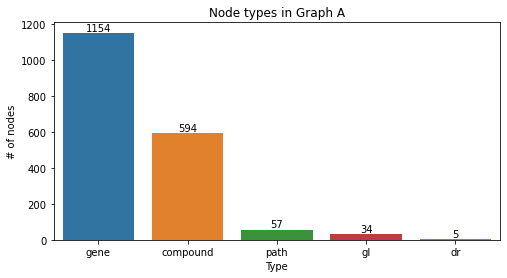

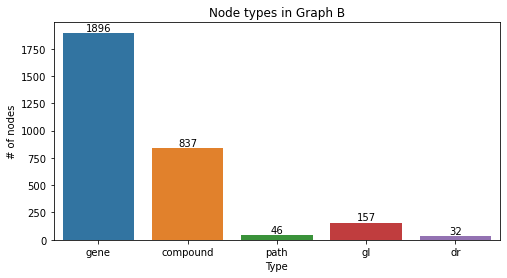

 49%|█████████████████████████████████████▍                                      | 14790/30000 [25:33<29:42,  8.54it/s]

Graph A:
Graph with 2352 nodes and 5213 edges
Graph B:
Graph with 2460 nodes and 5160 edges
[2, 5, 6, 7, 10, 12, 13, 15, 16, 17, 18, 20, 21, 23, 25, 26, 33, 34, 38, 39]


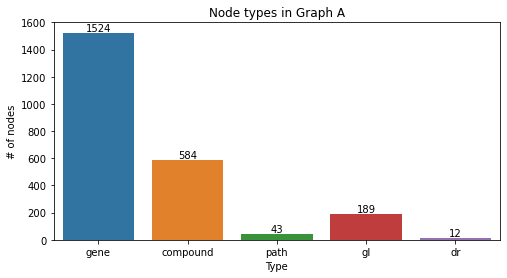

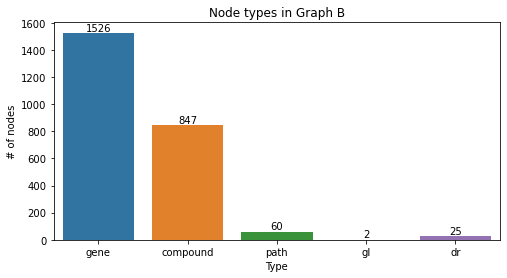

 49%|█████████████████████████████████████▍                                      | 14800/30000 [25:34<25:17, 10.01it/s]

Graph A:
Graph with 2337 nodes and 5088 edges
Graph B:
Graph with 2475 nodes and 5396 edges
[0, 1, 7, 10, 12, 13, 14, 15, 16, 19, 20, 22, 24, 26, 27, 28, 29, 30, 31, 33, 35, 39]


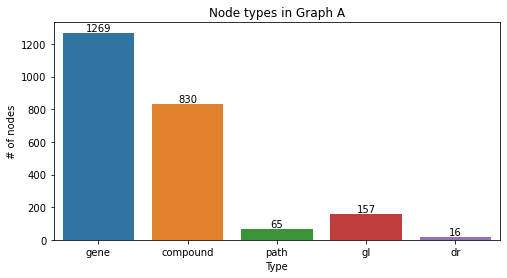

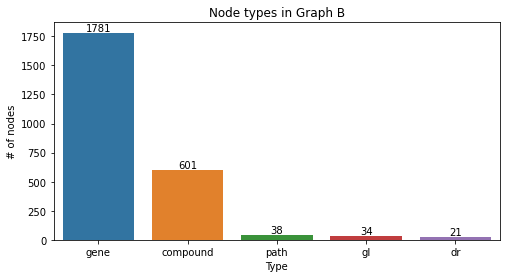

 50%|█████████████████████████████████████▋                                      | 14870/30000 [25:41<23:47, 10.60it/s]

Graph A:
Graph with 2698 nodes and 5015 edges
Graph B:
Graph with 2114 nodes and 5338 edges
[1, 3, 9, 13, 14, 17, 18, 20, 21, 26, 27, 28, 29, 30, 31, 33, 35, 39]


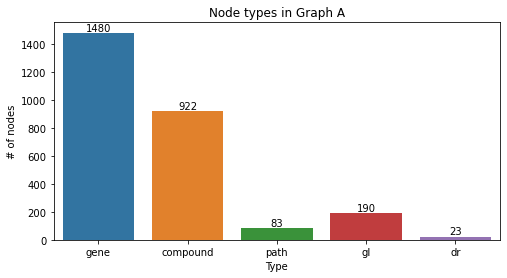

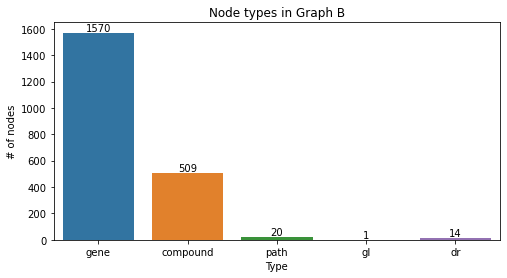

 51%|██████████████████████████████████████▋                                     | 15260/30000 [26:21<24:38,  9.97it/s]

Graph A:
Graph with 2343 nodes and 5673 edges
Graph B:
Graph with 2469 nodes and 4689 edges
[2, 3, 4, 7, 10, 11, 15, 16, 19, 20, 21, 24, 25, 29, 33, 34, 35, 37, 38, 39]


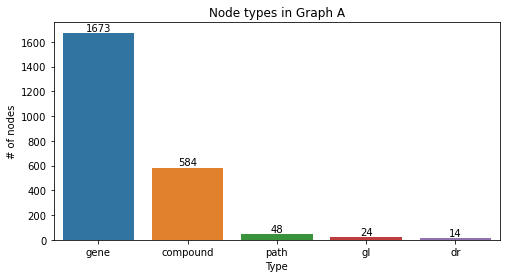

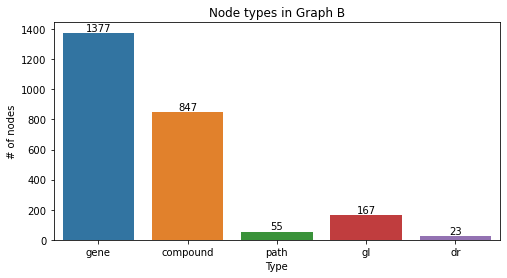

 51%|██████████████████████████████████████▉                                     | 15379/30000 [26:33<21:25, 11.38it/s]

Graph A:
Graph with 1856 nodes and 4779 edges
Graph B:
Graph with 2956 nodes and 5569 edges
[0, 2, 4, 5, 6, 7, 10, 11, 12, 13, 15, 16, 19, 21, 22, 23, 24, 25, 26, 29, 32, 33, 34, 35, 38, 39]


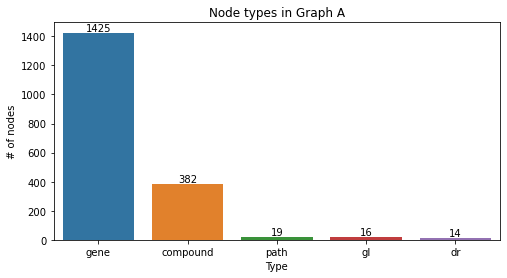

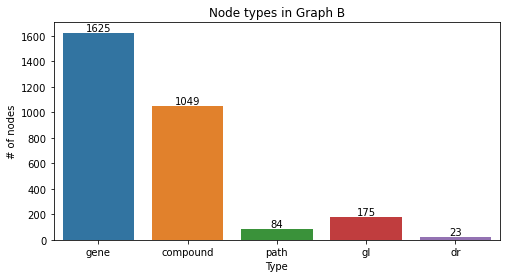

 52%|███████████████████████████████████████▎                                    | 15511/30000 [26:47<27:25,  8.80it/s]

Graph A:
Graph with 2610 nodes and 5731 edges
Graph B:
Graph with 2202 nodes and 4630 edges
[0, 5, 7, 8, 9, 10, 15, 16, 17, 18, 20, 23, 24, 25, 32, 33, 35, 36, 37, 38, 39]


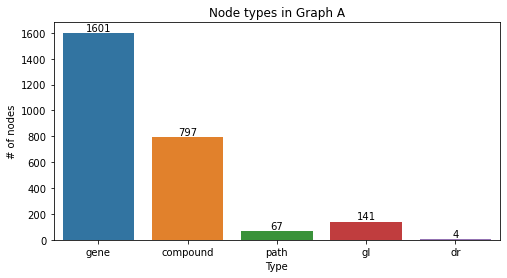

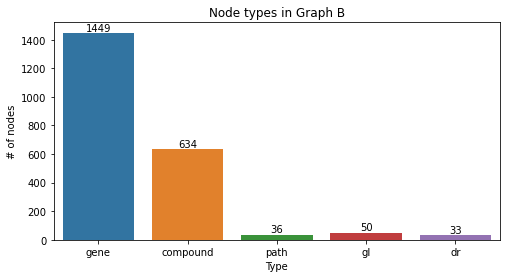

 52%|███████████████████████████████████████▉                                    | 15745/30000 [27:11<23:40, 10.03it/s]

Graph A:
Graph with 2569 nodes and 5535 edges
Graph B:
Graph with 2243 nodes and 4668 edges
[0, 1, 2, 5, 6, 12, 13, 14, 16, 23, 24, 26, 27, 28, 29, 30, 31, 36, 37, 38]


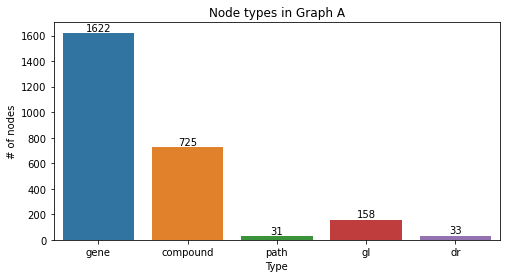

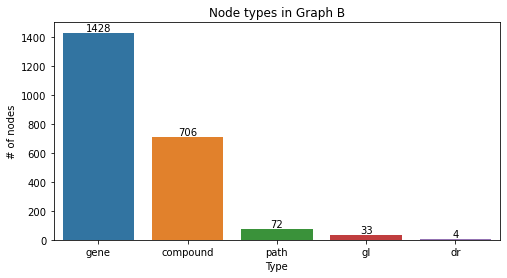

 53%|████████████████████████████████████████▎                                   | 15896/30000 [27:26<23:45,  9.89it/s]

Graph A:
Graph with 1459 nodes and 2684 edges
Graph B:
Graph with 3353 nodes and 8025 edges
[0, 1, 2, 3, 5, 7, 8, 11, 14, 15, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 33, 36, 37, 38]


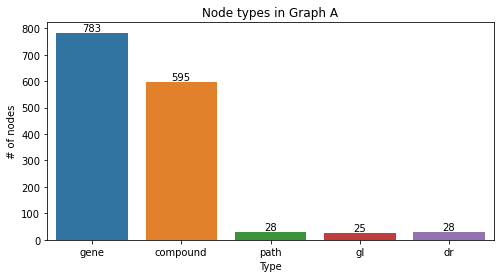

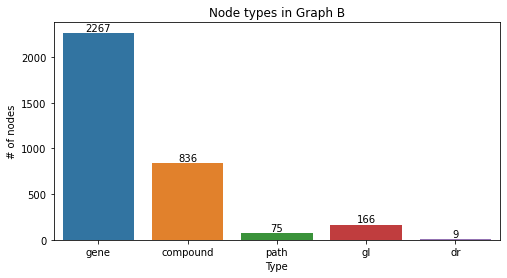

 53%|████████████████████████████████████████▍                                   | 15938/30000 [27:31<23:03, 10.17it/s]

Graph A:
Graph with 2135 nodes and 4567 edges
Graph B:
Graph with 2677 nodes and 5807 edges
[1, 2, 3, 6, 8, 10, 11, 12, 13, 14, 19, 21, 22, 25, 27, 28, 30, 31, 35, 36, 37, 39]


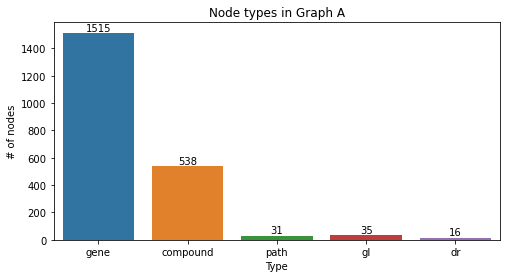

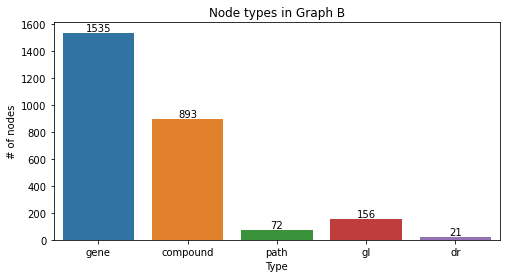

 53%|████████████████████████████████████████▌                                   | 16024/30000 [27:40<25:18,  9.20it/s]

Graph A:
Graph with 1497 nodes and 2678 edges
Graph B:
Graph with 3315 nodes and 7988 edges
[1, 2, 3, 5, 6, 7, 11, 13, 14, 15, 16, 17, 18, 21, 22, 24, 27, 28, 30, 31, 32, 38, 39]


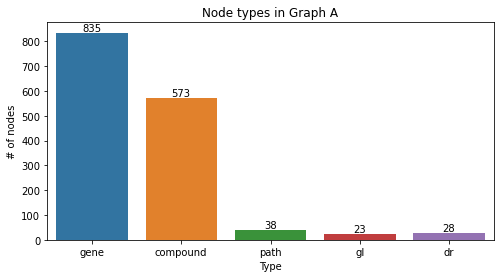

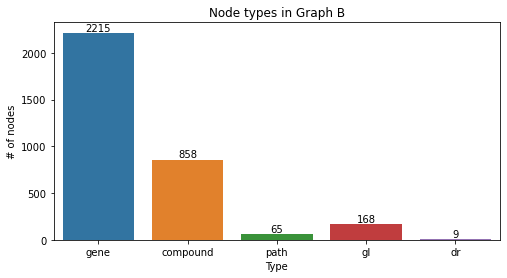

 54%|████████████████████████████████████████▋                                   | 16056/30000 [27:44<20:47, 11.18it/s]

Graph A:
Graph with 2169 nodes and 4014 edges
Graph B:
Graph with 2643 nodes and 6687 edges
[0, 1, 3, 4, 6, 7, 8, 14, 15, 16, 17, 18, 23, 26, 27, 28, 29, 30, 31, 33, 36, 38]


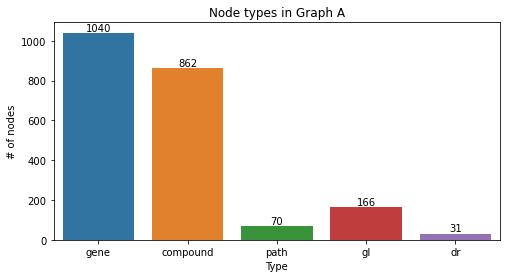

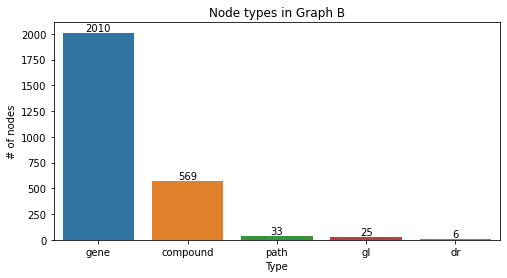

 54%|████████████████████████████████████████▊                                   | 16099/30000 [27:49<21:59, 10.53it/s]

Graph A:
Graph with 2368 nodes and 4776 edges
Graph B:
Graph with 2444 nodes and 5519 edges
[0, 1, 2, 3, 4, 7, 12, 14, 15, 16, 22, 25, 27, 28, 30, 31, 36, 38, 39]


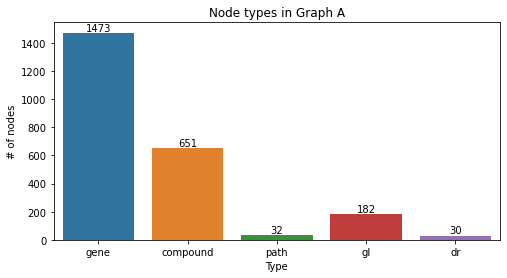

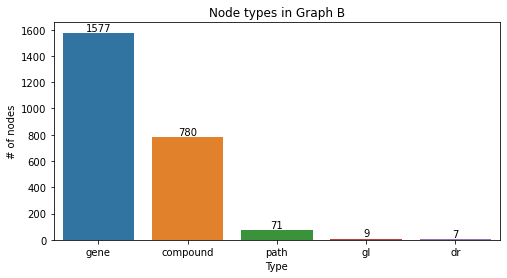

 54%|█████████████████████████████████████████▎                                  | 16318/30000 [28:12<22:13, 10.26it/s]

Graph A:
Graph with 2642 nodes and 6689 edges
Graph B:
Graph with 2170 nodes and 3835 edges
[0, 2, 4, 6, 10, 11, 12, 16, 19, 20, 21, 22, 23, 24, 26, 33, 38]


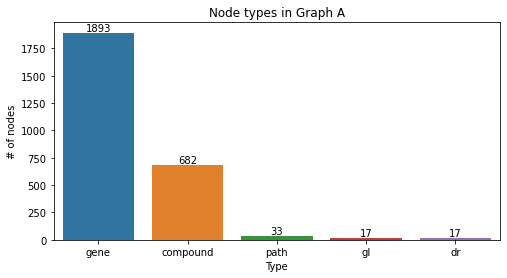

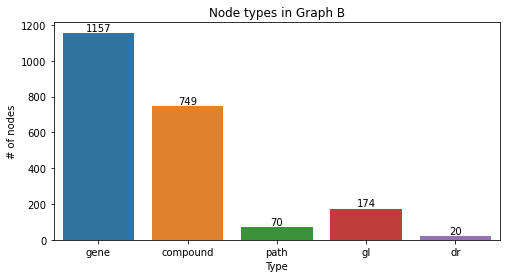

 55%|█████████████████████████████████████████▋                                  | 16448/30000 [28:25<18:10, 12.43it/s]

Graph A:
Graph with 3350 nodes and 8381 edges
Graph B:
Graph with 1462 nodes and 2421 edges
[0, 8, 10, 11, 12, 19, 20, 23, 24, 29, 33, 37, 38, 39]


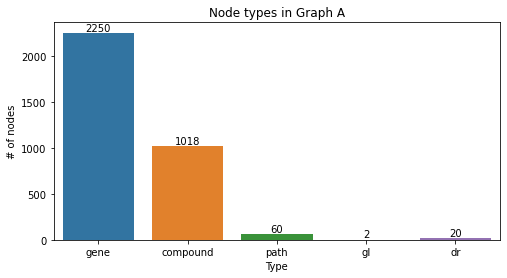

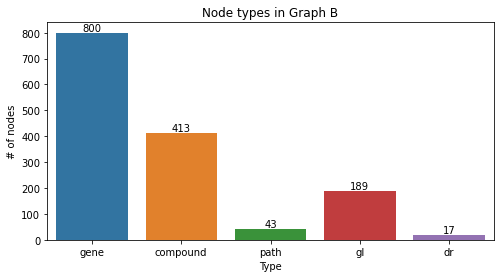

 57%|███████████████████████████████████████████▎                                | 17121/30000 [29:34<23:32,  9.12it/s]

Graph A:
Graph with 1869 nodes and 3604 edges
Graph B:
Graph with 2943 nodes and 7102 edges
[1, 2, 4, 5, 7, 13, 14, 15, 17, 18, 20, 23, 24, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39]


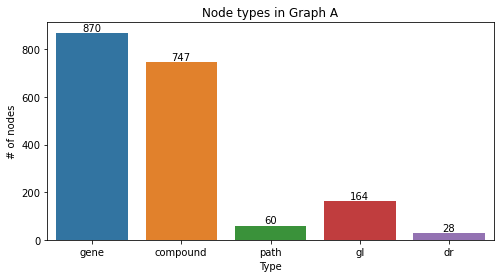

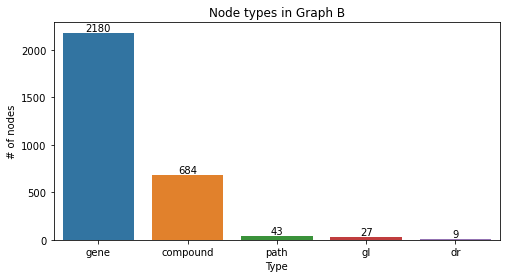

 57%|███████████████████████████████████████████▌                                | 17179/30000 [29:40<21:17, 10.03it/s]

Graph A:
Graph with 2387 nodes and 5428 edges
Graph B:
Graph with 2425 nodes and 4903 edges
[2, 5, 6, 7, 8, 11, 12, 15, 16, 17, 18, 20, 23, 24, 26, 32, 34, 35, 36, 38, 39]


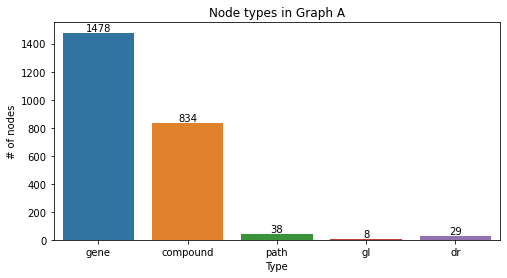

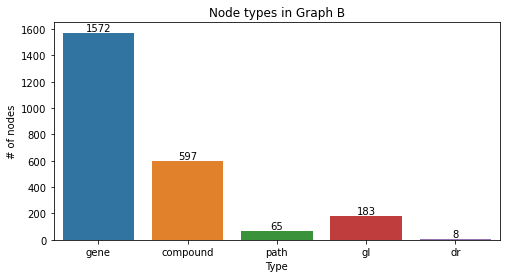

 57%|███████████████████████████████████████████▋                                | 17240/30000 [29:47<28:36,  7.43it/s]

Graph A:
Graph with 2670 nodes and 5728 edges
Graph B:
Graph with 2142 nodes and 4603 edges
[1, 2, 3, 4, 11, 12, 14, 20, 26, 27, 28, 29, 30, 31, 32, 36, 39]


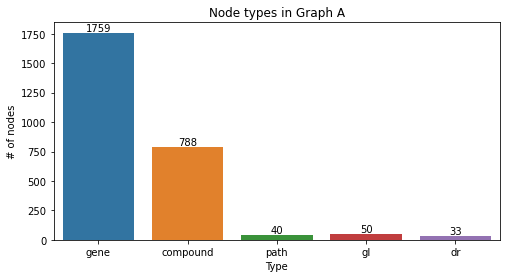

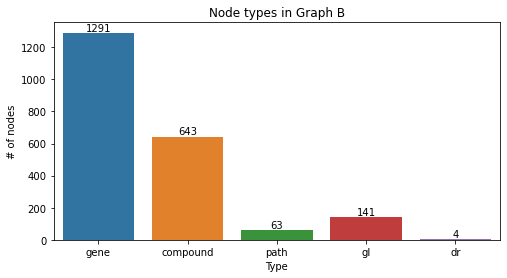

 58%|████████████████████████████████████████████▏                               | 17444/30000 [30:07<21:27,  9.76it/s]

Graph A:
Graph with 3272 nodes and 7702 edges
Graph B:
Graph with 1540 nodes and 2809 edges
[4, 7, 10, 12, 13, 15, 16, 19, 22, 25, 26, 29, 32, 37, 39]


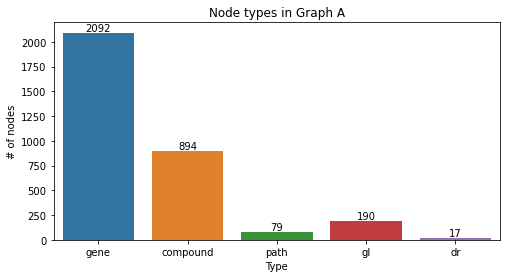

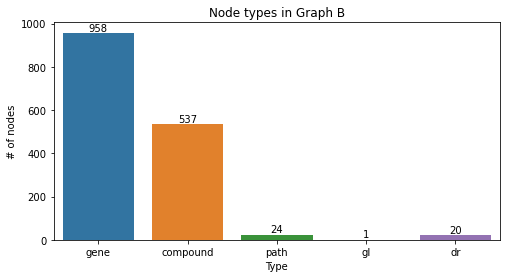

 60%|█████████████████████████████████████████████▋                              | 18012/30000 [31:05<20:10,  9.91it/s]

Graph A:
Graph with 2519 nodes and 5134 edges
Graph B:
Graph with 2293 nodes and 5116 edges
[1, 3, 4, 6, 7, 8, 10, 13, 14, 15, 16, 20, 25, 27, 28, 30, 31, 32, 35, 38, 39]


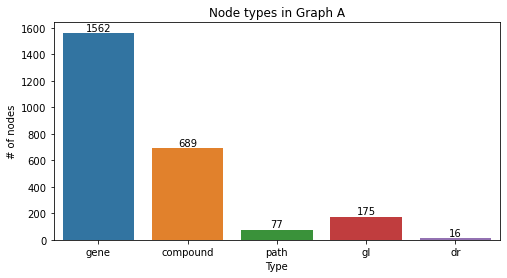

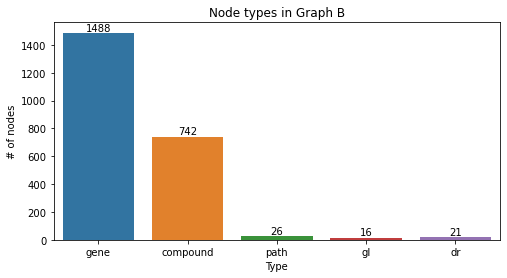

 63%|███████████████████████████████████████████████▉                            | 18899/30000 [32:35<19:37,  9.42it/s]

Graph A:
Graph with 2852 nodes and 6327 edges
Graph B:
Graph with 1960 nodes and 4026 edges
[0, 2, 4, 5, 10, 17, 18, 21, 23, 26, 29, 34, 36, 38, 39]


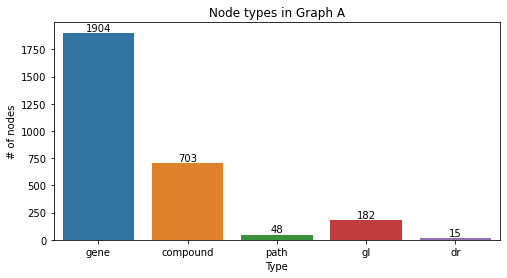

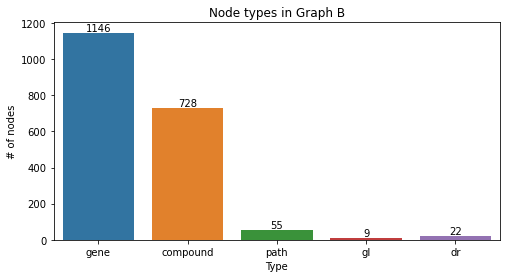

 64%|████████████████████████████████████████████████▉                           | 19293/30000 [33:15<15:33, 11.48it/s]

Graph A:
Graph with 2371 nodes and 4838 edges
Graph B:
Graph with 2441 nodes and 5570 edges
[0, 1, 2, 3, 4, 6, 13, 14, 19, 20, 27, 28, 30, 31, 32, 33, 35, 37, 39]


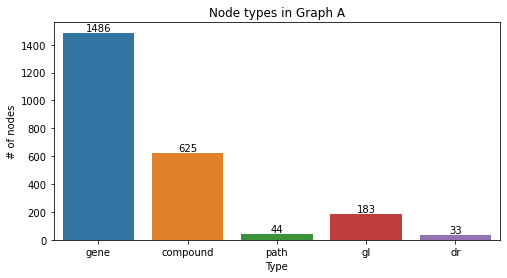

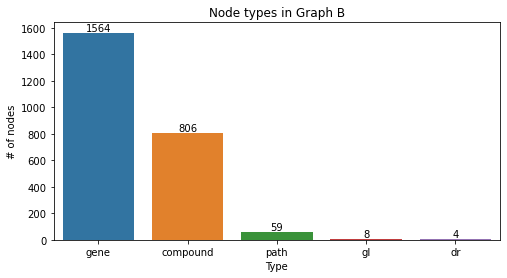

 65%|█████████████████████████████████████████████████▏                          | 19426/30000 [33:30<18:31,  9.51it/s]

Graph A:
Graph with 1663 nodes and 3281 edges
Graph B:
Graph with 3149 nodes and 7358 edges
[0, 1, 2, 7, 8, 11, 13, 14, 15, 16, 17, 18, 20, 22, 24, 25, 27, 28, 30, 31, 32, 33, 36]


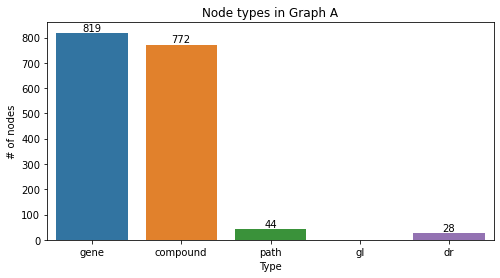

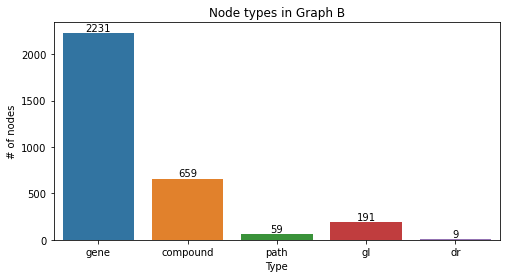

 65%|█████████████████████████████████████████████████▎                          | 19482/30000 [33:36<15:32, 11.28it/s]

Graph A:
Graph with 2251 nodes and 4714 edges
Graph B:
Graph with 2561 nodes and 5678 edges
[2, 3, 7, 8, 9, 10, 13, 15, 17, 18, 20, 22, 32, 33, 34, 37, 39]


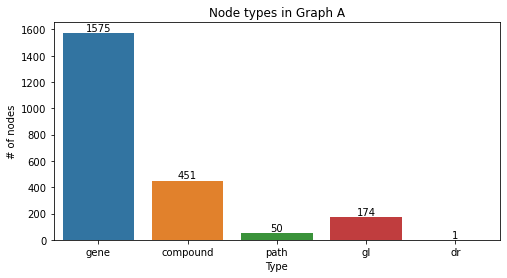

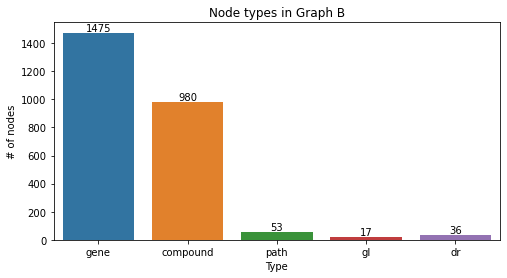

 65%|█████████████████████████████████████████████████▎                          | 19485/30000 [33:36<24:58,  7.02it/s]

Graph A:
Graph with 3778 nodes and 8407 edges
Graph B:
Graph with 1034 nodes and 2252 edges
[6, 13, 16, 17, 18, 22, 23, 26, 29, 34, 36, 38]


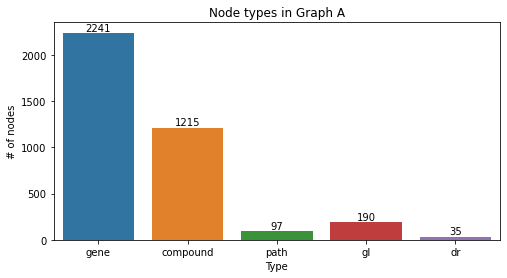

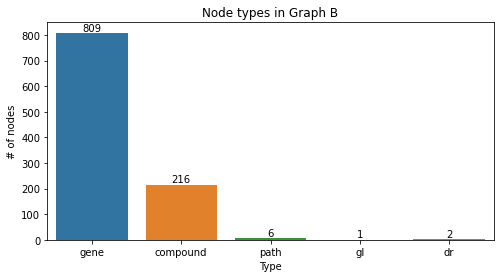

 65%|█████████████████████████████████████████████████▍                          | 19496/30000 [33:38<20:08,  8.69it/s]

Graph A:
Graph with 2472 nodes and 5412 edges
Graph B:
Graph with 2340 nodes and 4995 edges
[0, 1, 6, 8, 9, 11, 12, 13, 14, 16, 19, 21, 22, 24, 26, 27, 28, 29, 30, 31, 33, 35, 37, 39]


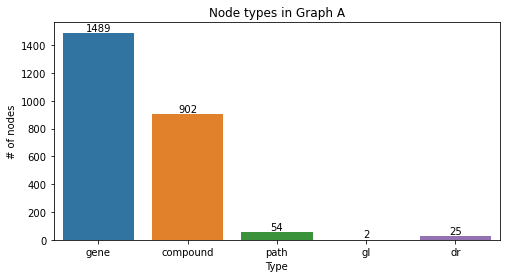

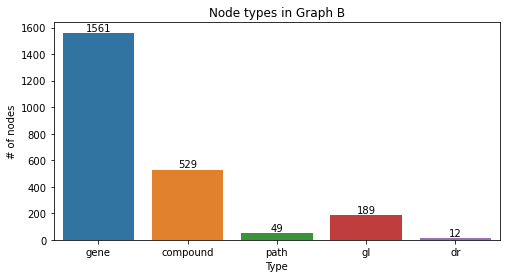

 65%|█████████████████████████████████████████████████▍                          | 19536/30000 [33:42<18:09,  9.60it/s]

Graph A:
Graph with 1974 nodes and 4129 edges
Graph B:
Graph with 2838 nodes and 6186 edges
[0, 2, 3, 5, 9, 10, 13, 16, 17, 18, 19, 20, 21, 23, 26, 33, 34, 35, 36, 39]


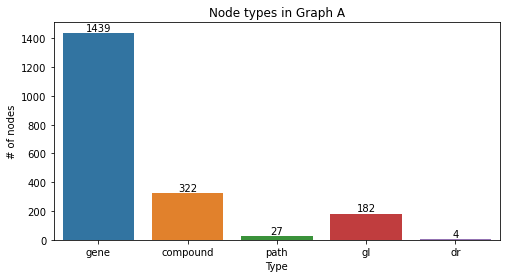

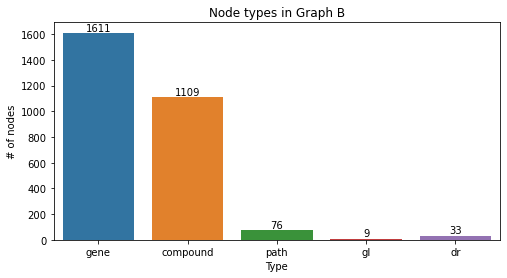

 65%|█████████████████████████████████████████████████▋                          | 19602/30000 [33:50<19:32,  8.87it/s]

Graph A:
Graph with 3271 nodes and 6841 edges
Graph B:
Graph with 1541 nodes and 3452 edges
[0, 1, 5, 9, 13, 14, 21, 22, 25, 27, 28, 30, 31, 34, 37, 39]


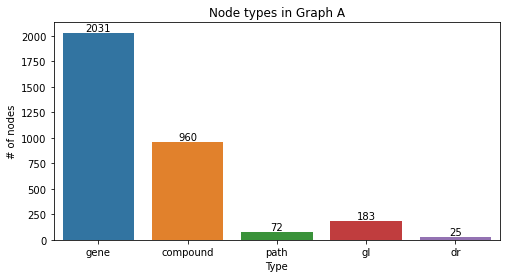

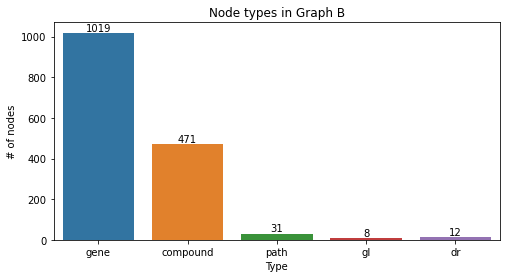

 66%|██████████████████████████████████████████████████                          | 19744/30000 [34:05<16:30, 10.36it/s]

Graph A:
Graph with 2662 nodes and 5787 edges
Graph B:
Graph with 2150 nodes and 4557 edges
[0, 4, 6, 9, 11, 12, 13, 16, 17, 18, 19, 23, 25, 26, 34, 37, 38, 39]


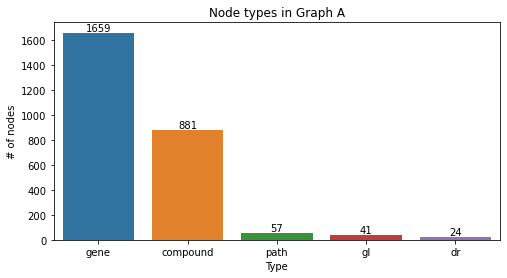

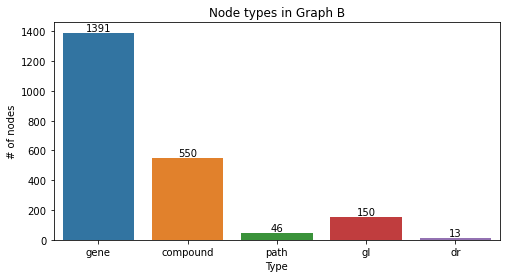

 66%|██████████████████████████████████████████████████▎                         | 19844/30000 [34:15<15:11, 11.14it/s]

Graph A:
Graph with 2725 nodes and 5732 edges
Graph B:
Graph with 2087 nodes and 4585 edges
[1, 4, 5, 6, 7, 8, 10, 13, 14, 15, 16, 25, 26, 27, 28, 30, 31, 33, 34, 37, 38]


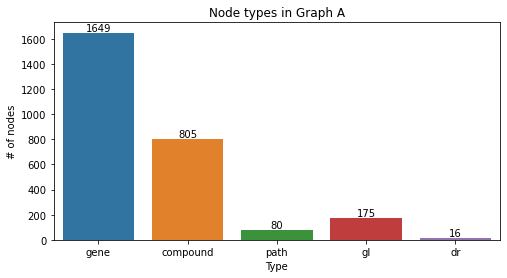

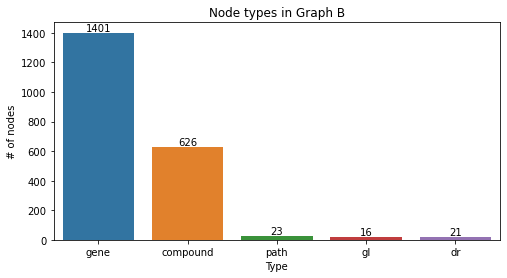

 67%|███████████████████████████████████████████████████▏                        | 20202/30000 [34:50<16:26,  9.94it/s]

Graph A:
Graph with 1927 nodes and 3962 edges
Graph B:
Graph with 2885 nodes and 6310 edges
[1, 2, 3, 4, 6, 7, 11, 12, 13, 14, 15, 16, 20, 22, 27, 28, 29, 30, 31, 33, 35, 37, 38, 39]


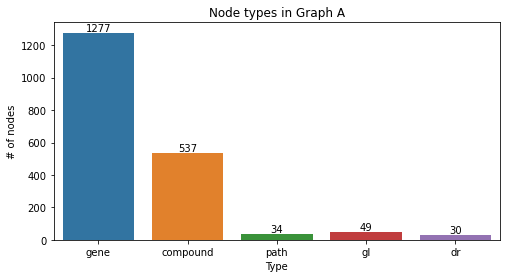

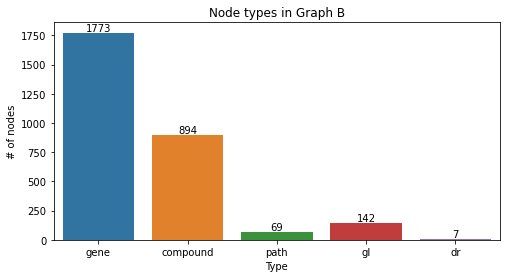

 68%|███████████████████████████████████████████████████▎                        | 20254/30000 [34:55<14:10, 11.46it/s]

Graph A:
Graph with 2110 nodes and 4300 edges
Graph B:
Graph with 2702 nodes and 6010 edges
[1, 2, 3, 7, 9, 10, 14, 15, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37]


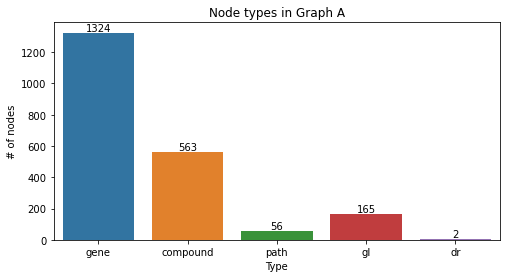

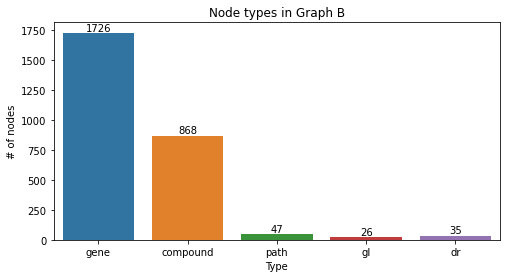

 68%|███████████████████████████████████████████████████▍                        | 20299/30000 [35:00<19:38,  8.23it/s]

Graph A:
Graph with 2191 nodes and 4890 edges
Graph B:
Graph with 2621 nodes and 5513 edges
[0, 1, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, 19, 20, 21, 22, 23, 27, 28, 30, 31, 32]


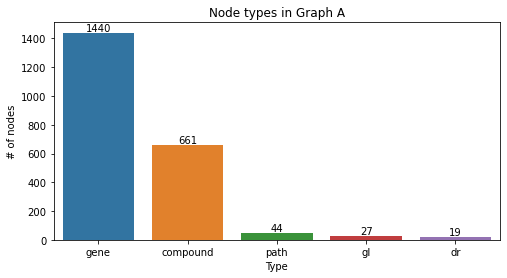

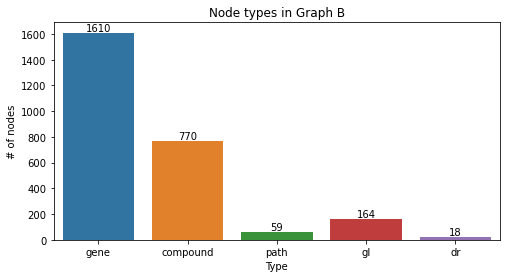

 68%|███████████████████████████████████████████████████▉                        | 20496/30000 [35:20<16:45,  9.46it/s]

Graph A:
Graph with 3001 nodes and 6494 edges
Graph B:
Graph with 1811 nodes and 3825 edges
[0, 1, 2, 6, 11, 14, 20, 25, 27, 28, 30, 31, 36]


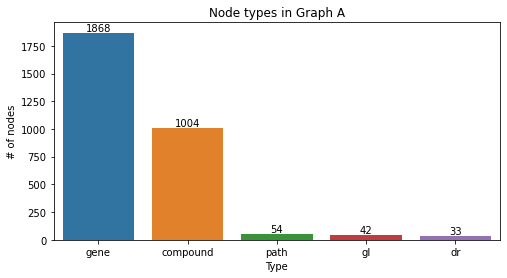

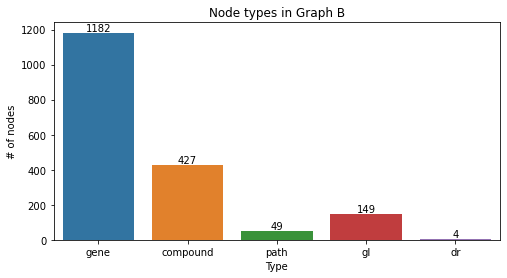

 68%|███████████████████████████████████████████████████▉                        | 20511/30000 [35:22<16:57,  9.33it/s]

Graph A:
Graph with 2435 nodes and 5047 edges
Graph B:
Graph with 2377 nodes and 5248 edges
[0, 5, 6, 7, 9, 10, 13, 15, 16, 17, 18, 19, 21, 25, 32, 36, 38, 39]


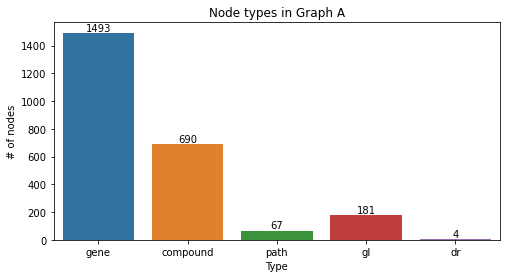

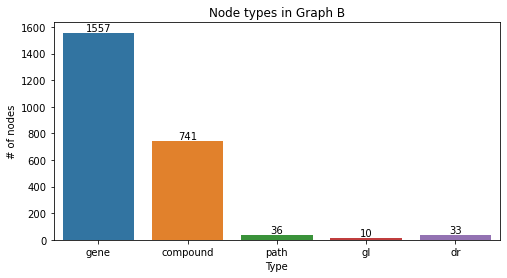

 69%|████████████████████████████████████████████████████▎                       | 20627/30000 [35:34<14:39, 10.66it/s]

Graph A:
Graph with 2094 nodes and 4156 edges
Graph B:
Graph with 2718 nodes and 6272 edges
[0, 1, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 24, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38]


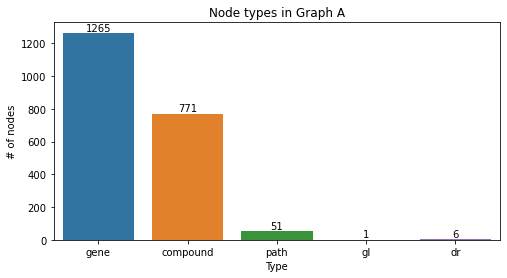

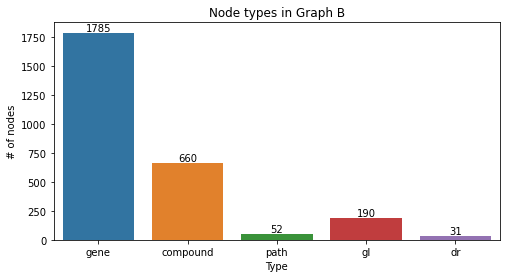

 70%|█████████████████████████████████████████████████████                       | 20969/30000 [36:09<16:53,  8.91it/s]

Graph A:
Graph with 1991 nodes and 4212 edges
Graph B:
Graph with 2821 nodes and 6139 edges
[1, 2, 3, 6, 9, 10, 11, 14, 16, 19, 20, 21, 24, 27, 28, 29, 30, 31, 32, 37, 38]


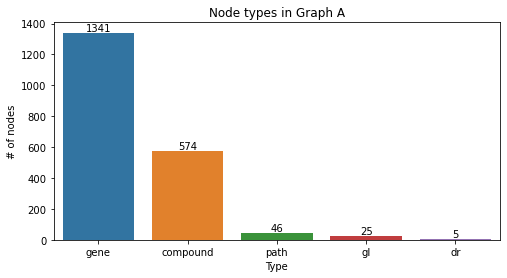

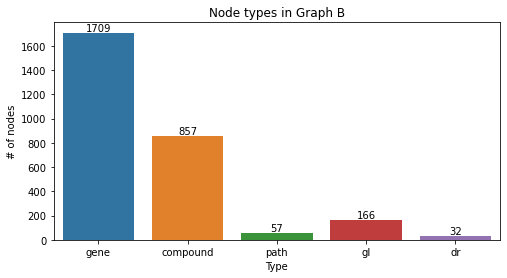

 70%|█████████████████████████████████████████████████████▍                      | 21094/30000 [36:21<14:47, 10.03it/s]

Graph A:
Graph with 2382 nodes and 4822 edges
Graph B:
Graph with 2430 nodes and 5597 edges
[0, 1, 2, 3, 9, 10, 14, 16, 19, 21, 27, 28, 30, 31, 33, 34, 37, 38]


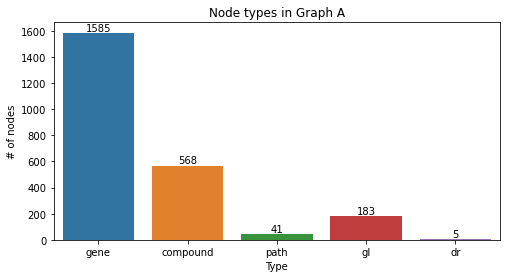

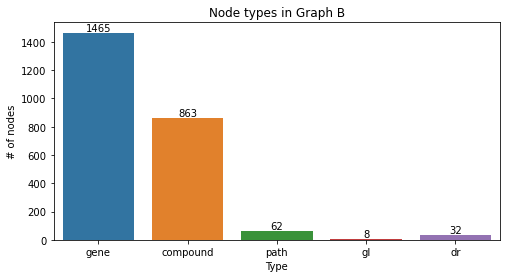

 71%|█████████████████████████████████████████████████████▋                      | 21170/30000 [36:29<15:49,  9.30it/s]

Graph A:
Graph with 1811 nodes and 3582 edges
Graph B:
Graph with 3001 nodes and 6746 edges
[0, 1, 2, 3, 7, 9, 11, 12, 13, 14, 15, 23, 25, 26, 27, 28, 30, 31, 33, 35, 36]


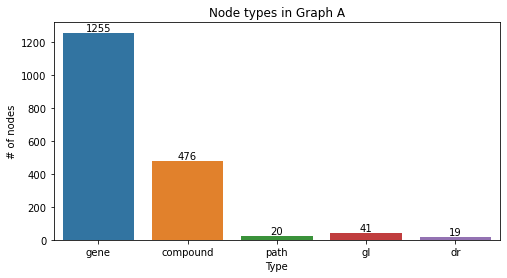

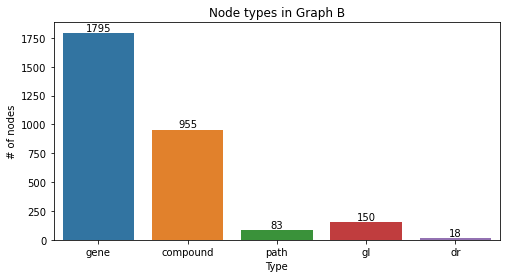

 71%|█████████████████████████████████████████████████████▊                      | 21260/30000 [36:38<17:40,  8.24it/s]

Graph A:
Graph with 1331 nodes and 2594 edges
Graph B:
Graph with 3481 nodes and 7835 edges
[1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 24, 26, 27, 28, 29, 30, 31, 35, 39]


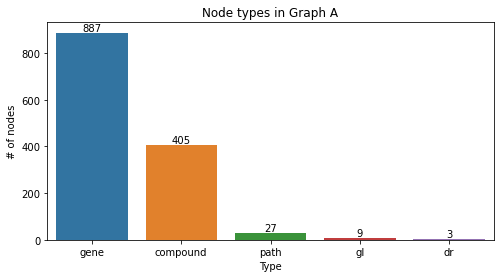

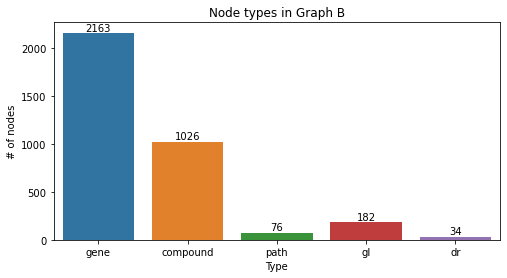

 71%|██████████████████████████████████████████████████████                      | 21326/30000 [36:45<14:34,  9.91it/s]

Graph A:
Graph with 1895 nodes and 4627 edges
Graph B:
Graph with 2917 nodes and 5797 edges
[2, 3, 4, 5, 7, 8, 9, 11, 13, 15, 16, 19, 20, 21, 22, 23, 24, 26, 32, 33, 34, 38, 39]


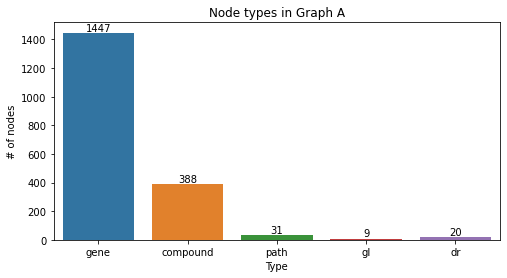

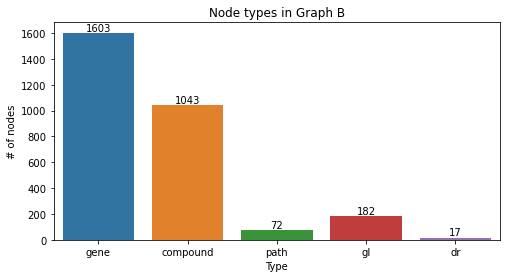

 71%|██████████████████████████████████████████████████████                      | 21328/30000 [36:46<21:49,  6.62it/s]

Graph A:
Graph with 2387 nodes and 5243 edges
Graph B:
Graph with 2425 nodes and 5085 edges
[1, 4, 5, 8, 9, 11, 12, 13, 14, 19, 20, 21, 23, 24, 27, 28, 29, 30, 31, 33, 34, 36, 37, 39]


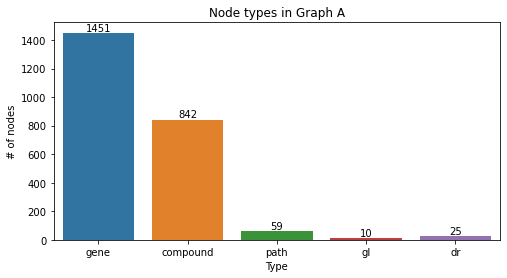

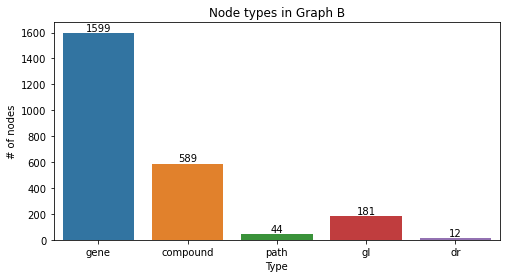

 72%|██████████████████████████████████████████████████████▎                     | 21457/30000 [37:03<20:26,  6.97it/s]

Graph A:
Graph with 2251 nodes and 4664 edges
Graph B:
Graph with 2561 nodes and 5548 edges
[0, 1, 3, 5, 6, 9, 10, 11, 13, 14, 21, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 37, 38, 39]


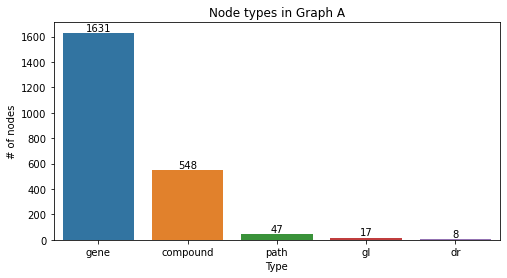

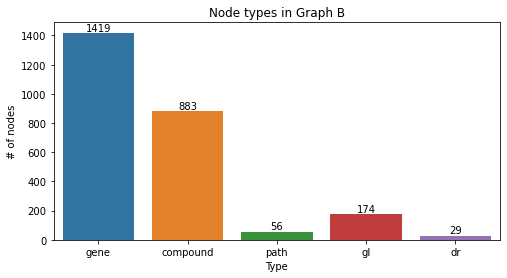

 72%|██████████████████████████████████████████████████████▍                     | 21472/30000 [37:06<21:01,  6.76it/s]

Graph A:
Graph with 1433 nodes and 3217 edges
Graph B:
Graph with 3379 nodes and 7333 edges
[0, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23, 32, 34, 38, 39]


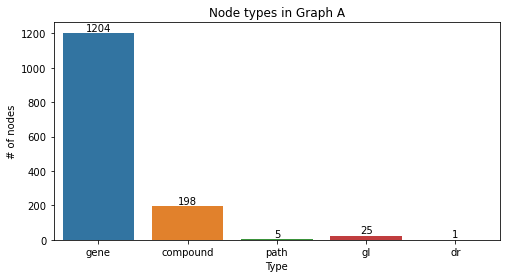

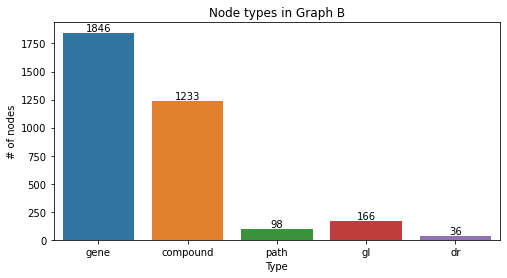

 72%|██████████████████████████████████████████████████████▌                     | 21534/30000 [37:13<15:47,  8.93it/s]

Graph A:
Graph with 1884 nodes and 3816 edges
Graph B:
Graph with 2928 nodes and 6980 edges
[1, 4, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 27, 28, 30, 31, 32, 33, 38]


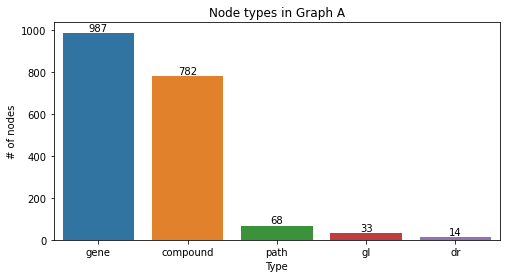

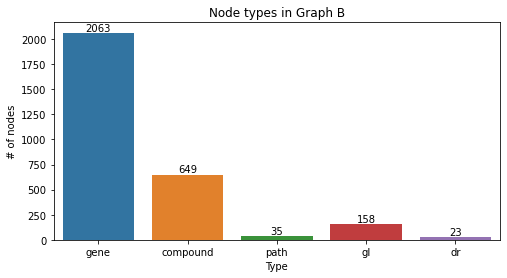

 72%|██████████████████████████████████████████████████████▊                     | 21659/30000 [37:27<14:13,  9.77it/s]

Graph A:
Graph with 2267 nodes and 4765 edges
Graph B:
Graph with 2545 nodes and 5696 edges
[2, 3, 5, 7, 9, 10, 15, 16, 17, 18, 23, 25, 29, 35, 36]


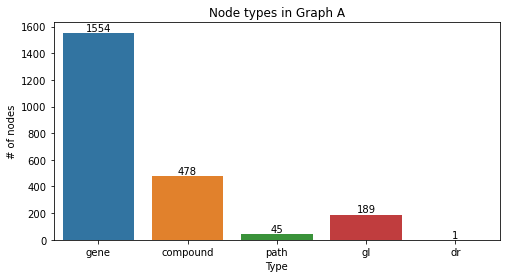

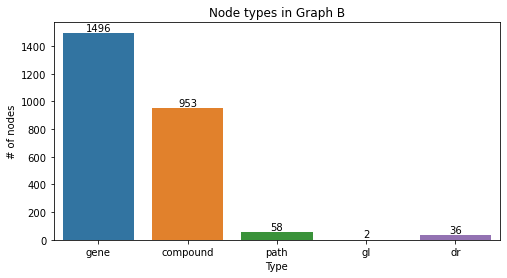

 73%|███████████████████████████████████████████████████████▋                    | 21958/30000 [37:59<13:37,  9.84it/s]

Graph A:
Graph with 1027 nodes and 1785 edges
Graph B:
Graph with 3785 nodes and 9114 edges
[0, 1, 2, 3, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 32, 34, 37, 39]


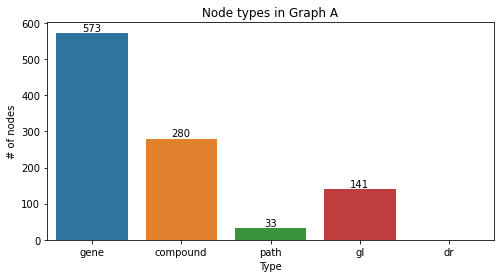

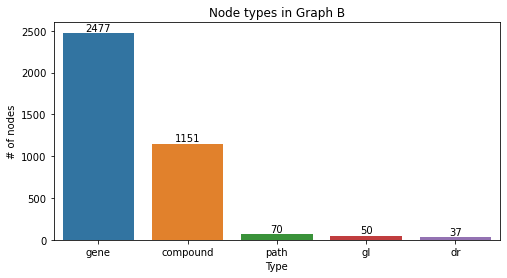

 75%|████████████████████████████████████████████████████████▊                   | 22443/30000 [38:52<12:12, 10.32it/s]

Graph A:
Graph with 2046 nodes and 4332 edges
Graph B:
Graph with 2766 nodes and 5883 edges
[0, 2, 3, 7, 8, 11, 12, 15, 16, 17, 18, 19, 20, 21, 26, 32, 33, 34, 36, 37, 38]


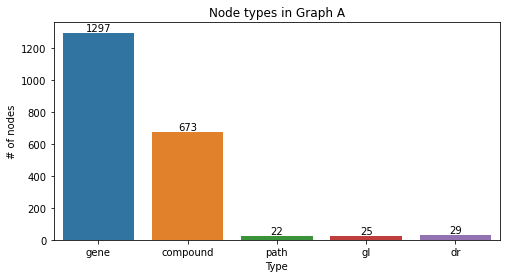

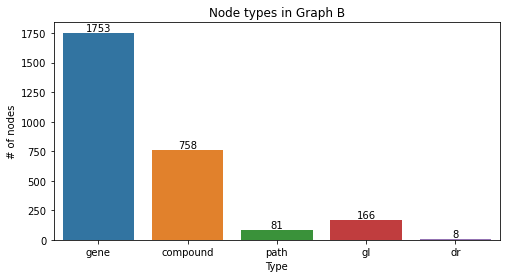

 76%|█████████████████████████████████████████████████████████▍                  | 22665/30000 [39:18<13:07,  9.31it/s]

Graph A:
Graph with 2259 nodes and 4884 edges
Graph B:
Graph with 2553 nodes and 5489 edges
[2, 3, 7, 8, 9, 11, 12, 15, 17, 18, 21, 22, 24, 26, 36, 38, 39]


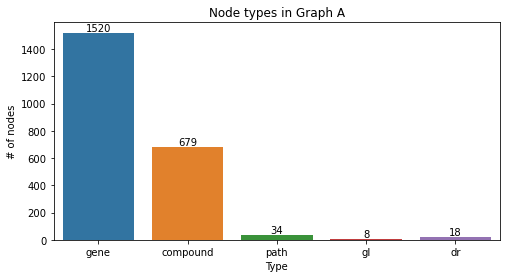

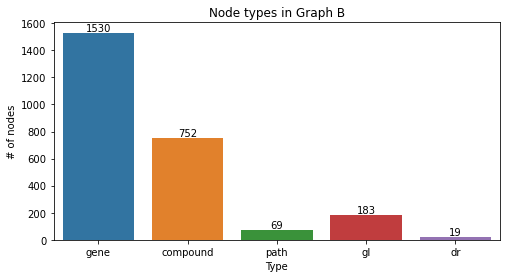

 77%|██████████████████████████████████████████████████████████▎                 | 23003/30000 [39:55<11:14, 10.37it/s]

Graph A:
Graph with 3187 nodes and 6788 edges
Graph B:
Graph with 1625 nodes and 3703 edges
[1, 7, 12, 14, 15, 16, 19, 20, 21, 27, 28, 29, 30, 31, 32, 35, 36, 37, 39]


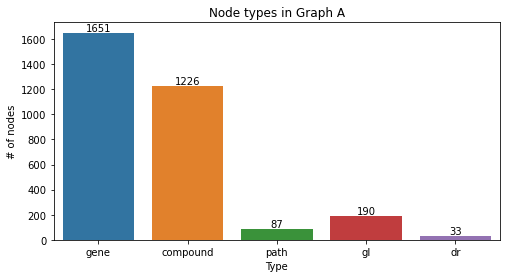

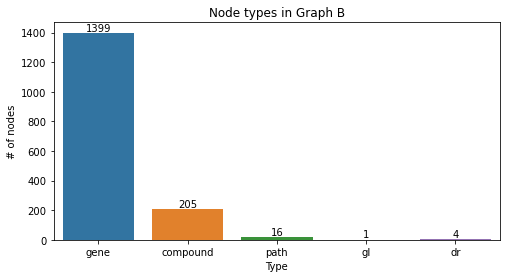

 78%|███████████████████████████████████████████████████████████                 | 23294/30000 [40:25<09:09, 12.20it/s]

Graph A:
Graph with 2863 nodes and 5956 edges
Graph B:
Graph with 1949 nodes and 4468 edges
[1, 5, 7, 9, 12, 14, 15, 19, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 35, 38]


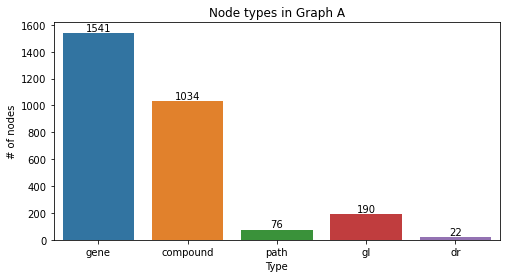

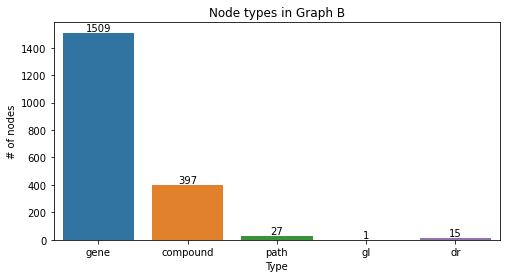

 79%|████████████████████████████████████████████████████████████                | 23696/30000 [41:07<11:12,  9.37it/s]

Graph A:
Graph with 2272 nodes and 5066 edges
Graph B:
Graph with 2540 nodes and 5262 edges
[0, 2, 6, 7, 8, 11, 12, 13, 15, 16, 17, 18, 21, 23, 25, 29, 32, 36, 37]


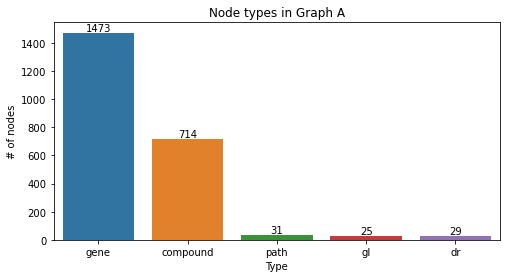

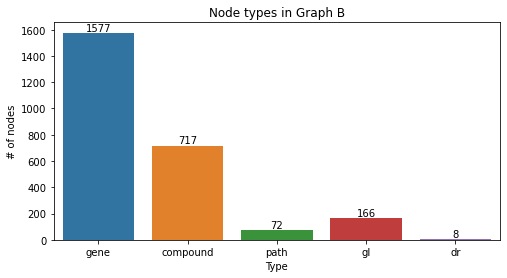

 79%|████████████████████████████████████████████████████████████▎               | 23822/30000 [41:20<10:11, 10.10it/s]

Graph A:
Graph with 2511 nodes and 5137 edges
Graph B:
Graph with 2301 nodes and 5079 edges
[1, 3, 7, 8, 9, 10, 12, 14, 15, 20, 21, 22, 23, 26, 27, 28, 29, 30, 31, 33, 35]


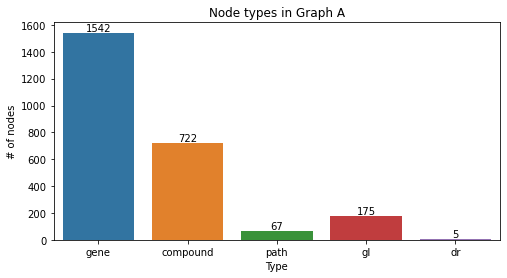

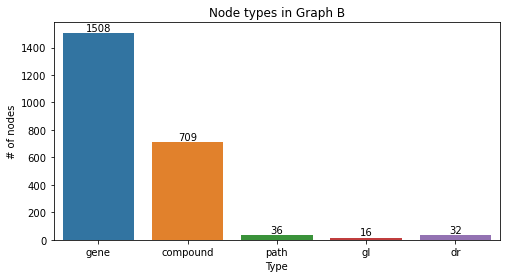

 81%|█████████████████████████████████████████████████████████████▌              | 24290/30000 [42:09<11:35,  8.21it/s]

Graph A:
Graph with 1382 nodes and 3076 edges
Graph B:
Graph with 3430 nodes and 7278 edges
[0, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 29, 32, 33, 35, 37]


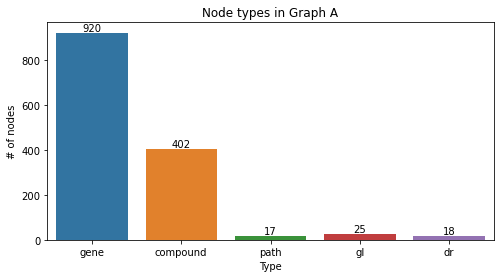

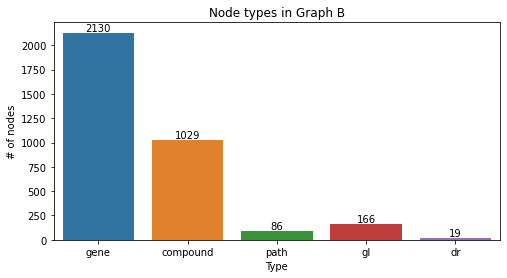

 83%|██████████████████████████████████████████████████████████████▊             | 24817/30000 [43:02<10:08,  8.52it/s]

Graph A:
Graph with 2516 nodes and 5169 edges
Graph B:
Graph with 2296 nodes and 5084 edges
[1, 2, 3, 7, 11, 14, 15, 16, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


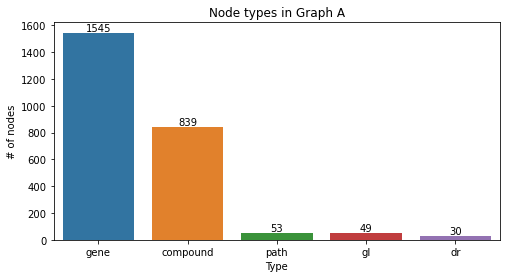

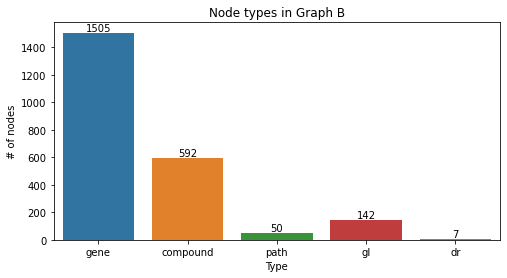

 83%|███████████████████████████████████████████████████████████████▍            | 25026/30000 [43:23<07:15, 11.42it/s]

Graph A:
Graph with 2049 nodes and 3911 edges
Graph B:
Graph with 2763 nodes and 7027 edges
[1, 3, 4, 6, 7, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 36, 37]


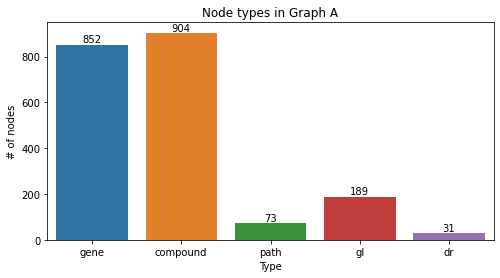

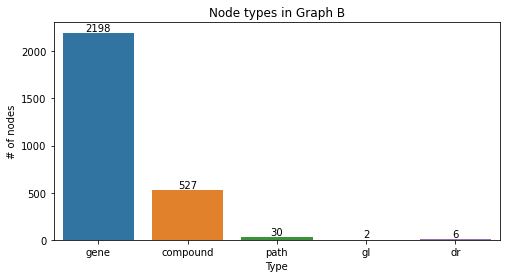

 84%|███████████████████████████████████████████████████████████████▊            | 25172/30000 [43:39<09:08,  8.81it/s]

Graph A:
Graph with 1954 nodes and 4307 edges
Graph B:
Graph with 2858 nodes and 6075 edges
[0, 2, 4, 7, 8, 9, 10, 13, 15, 16, 17, 18, 23, 24, 25, 29, 33, 35, 36, 38, 39]


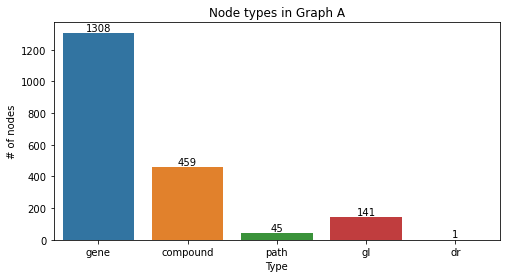

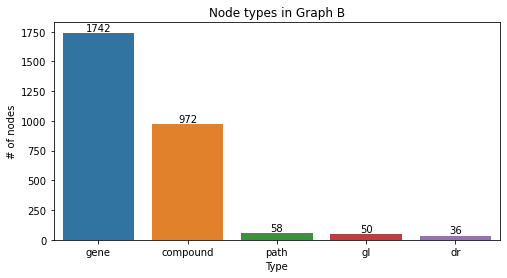

 85%|████████████████████████████████████████████████████████████████▎           | 25398/30000 [44:02<07:12, 10.65it/s]

Graph A:
Graph with 1738 nodes and 3851 edges
Graph B:
Graph with 3074 nodes and 6468 edges
[0, 1, 2, 3, 4, 5, 6, 8, 11, 12, 13, 14, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 36, 38]


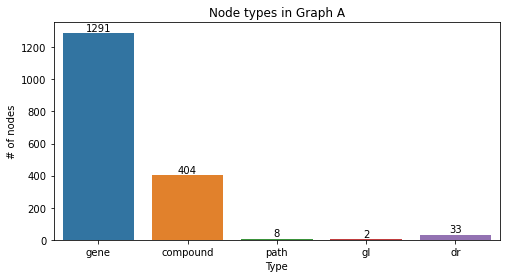

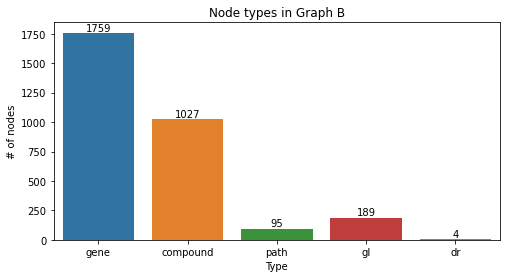

 85%|████████████████████████████████████████████████████████████████▍           | 25432/30000 [44:06<08:18,  9.16it/s]

Graph A:
Graph with 1802 nodes and 3347 edges
Graph B:
Graph with 3010 nodes and 6994 edges
[1, 2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 21, 22, 27, 28, 29, 30, 31, 33, 35, 36, 37, 39]


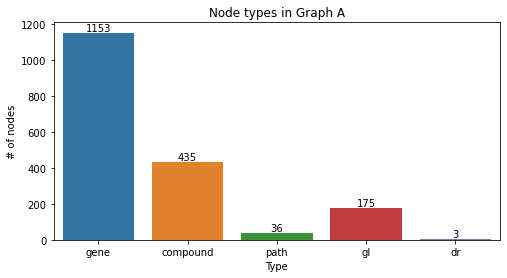

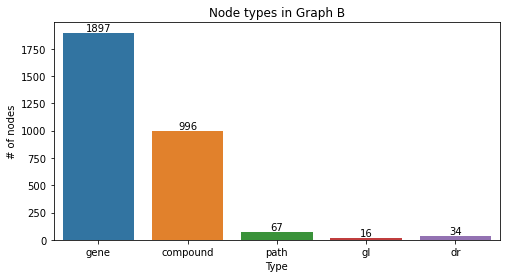

 85%|████████████████████████████████████████████████████████████████▊           | 25603/30000 [44:24<07:29,  9.79it/s]

Graph A:
Graph with 2931 nodes and 7131 edges
Graph B:
Graph with 1881 nodes and 3313 edges
[4, 5, 7, 8, 10, 11, 12, 15, 19, 20, 21, 22, 23, 25, 26, 32, 37, 38]


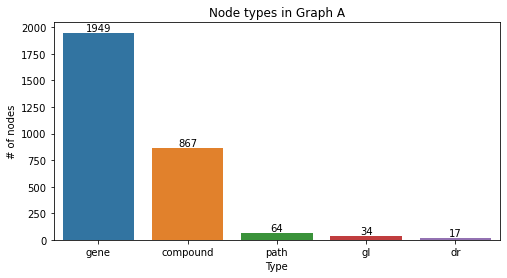

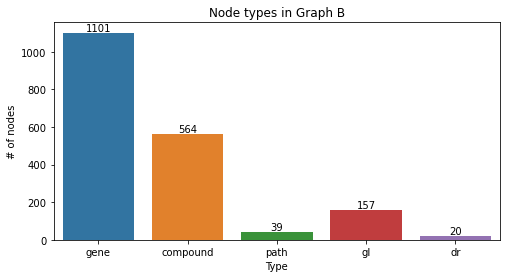

 86%|█████████████████████████████████████████████████████████████████▍          | 25839/30000 [44:48<06:35, 10.51it/s]

Graph A:
Graph with 2810 nodes and 5975 edges
Graph B:
Graph with 2002 nodes and 4454 edges
[1, 4, 7, 8, 12, 13, 14, 15, 19, 22, 24, 27, 28, 30, 31, 33, 36, 39]


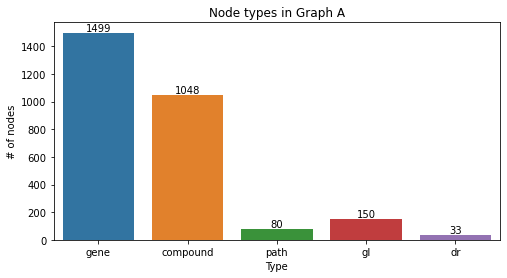

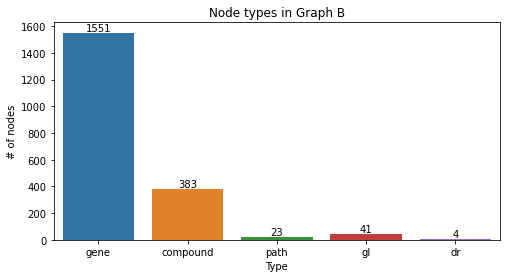

 87%|██████████████████████████████████████████████████████████████████          | 26078/30000 [45:12<07:28,  8.75it/s]

Graph A:
Graph with 1883 nodes and 3888 edges
Graph B:
Graph with 2929 nodes and 6434 edges
[1, 2, 3, 6, 7, 10, 11, 14, 15, 16, 19, 21, 22, 24, 25, 27, 28, 30, 31, 33, 37, 38]


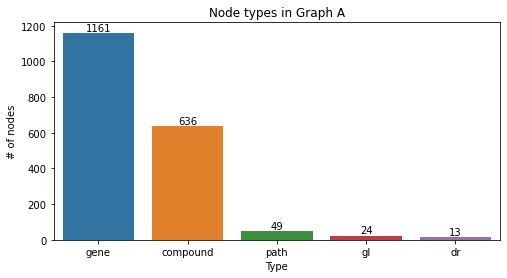

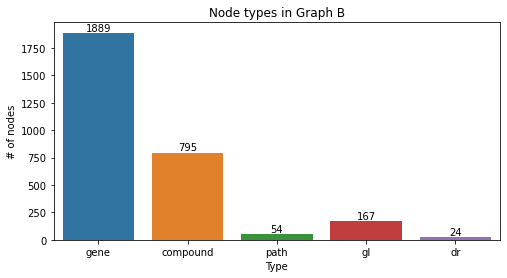

 87%|██████████████████████████████████████████████████████████████████▍         | 26213/30000 [45:26<07:01,  8.99it/s]

Graph A:
Graph with 1436 nodes and 2488 edges
Graph B:
Graph with 3376 nodes and 8309 edges
[1, 2, 3, 4, 6, 7, 9, 10, 14, 15, 16, 17, 18, 21, 23, 24, 25, 27, 28, 30, 31, 32, 34, 35, 38, 39]


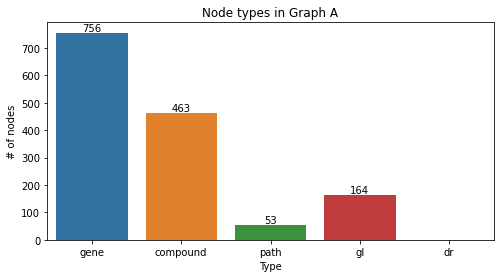

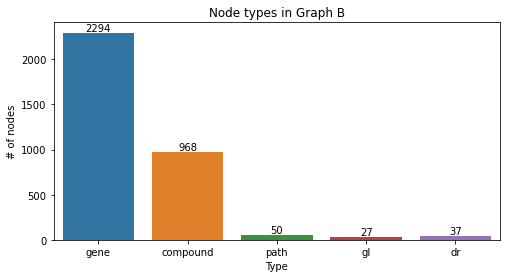

 87%|██████████████████████████████████████████████████████████████████▍         | 26232/30000 [45:29<07:16,  8.63it/s]

Graph A:
Graph with 3040 nodes and 6457 edges
Graph B:
Graph with 1772 nodes and 3923 edges
[0, 3, 9, 12, 13, 16, 17, 18, 23, 26, 29, 34, 37, 38]


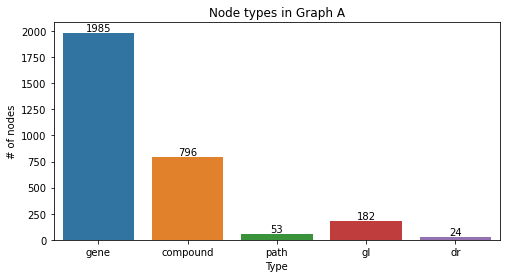

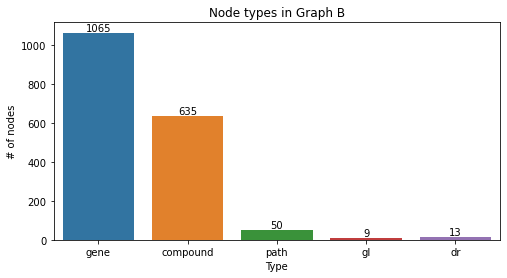

 88%|███████████████████████████████████████████████████████████████████         | 26456/30000 [45:52<05:36, 10.53it/s]

Graph A:
Graph with 1946 nodes and 4841 edges
Graph B:
Graph with 2866 nodes and 5872 edges
[0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 13, 15, 16, 21, 22, 23, 29, 33, 34, 36, 37, 38]


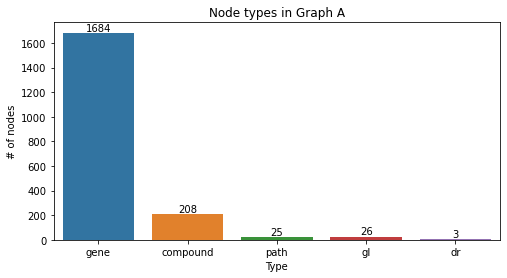

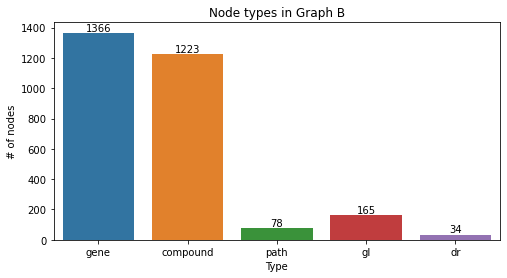

 89%|███████████████████████████████████████████████████████████████████▍        | 26596/30000 [46:06<04:46, 11.86it/s]

Graph A:
Graph with 1861 nodes and 3784 edges
Graph B:
Graph with 2951 nodes and 6468 edges
[0, 3, 4, 5, 6, 7, 8, 9, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 33, 34, 35]


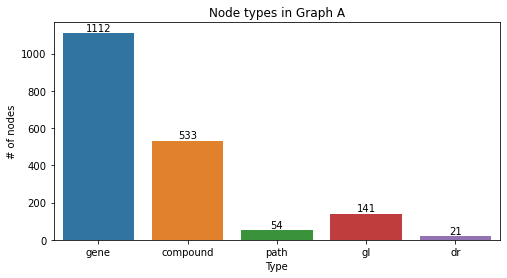

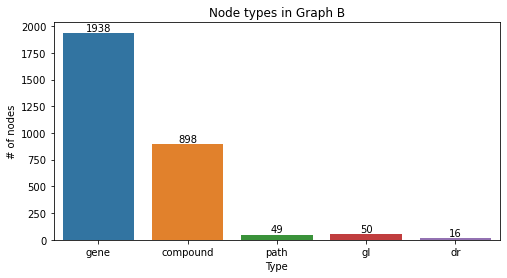

 90%|████████████████████████████████████████████████████████████████████▏       | 26923/30000 [46:39<05:00, 10.24it/s]

Graph A:
Graph with 3274 nodes and 8070 edges
Graph B:
Graph with 1538 nodes and 2827 edges
[2, 4, 5, 6, 10, 12, 13, 20, 21, 26, 34, 36, 38, 39]


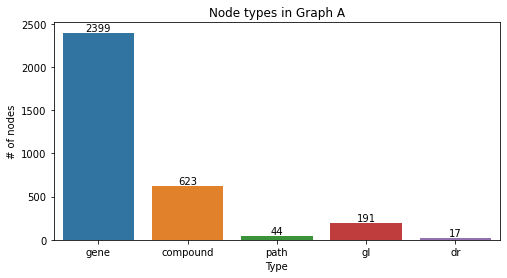

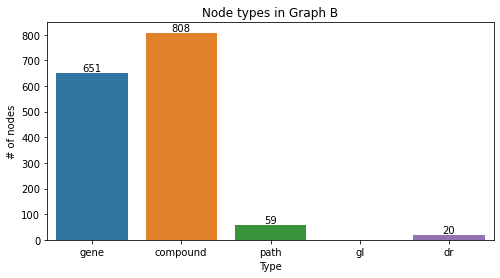

 91%|████████████████████████████████████████████████████████████████████▉       | 27203/30000 [47:10<04:44,  9.85it/s]

Graph A:
Graph with 2140 nodes and 4263 edges
Graph B:
Graph with 2672 nodes and 6617 edges
[1, 2, 7, 14, 15, 16, 17, 18, 19, 20, 24, 25, 27, 28, 29, 30, 31, 32, 34, 38]


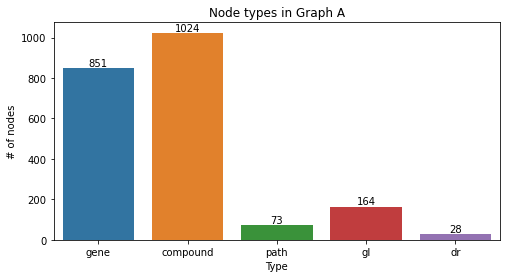

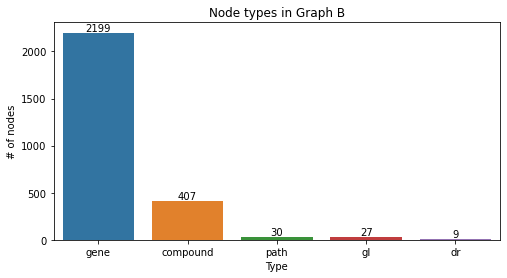

 92%|██████████████████████████████████████████████████████████████████████▏     | 27698/30000 [48:02<03:27, 11.10it/s]

Graph A:
Graph with 2073 nodes and 4159 edges
Graph B:
Graph with 2739 nodes and 6175 edges
[1, 2, 4, 6, 8, 10, 11, 14, 17, 18, 20, 21, 22, 23, 25, 27, 28, 29, 30, 31, 32, 35, 37, 38, 39]


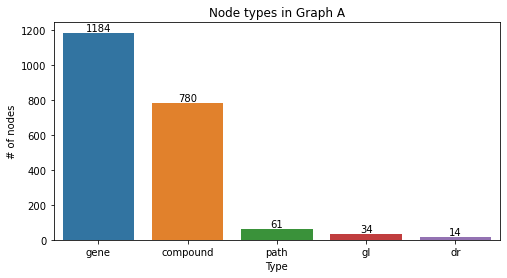

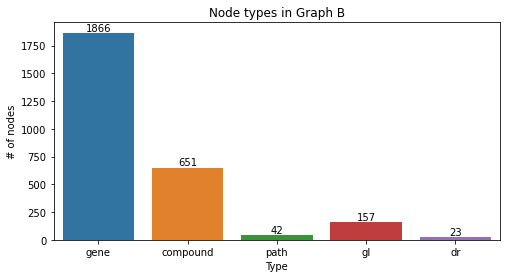

 93%|██████████████████████████████████████████████████████████████████████▍     | 27785/30000 [48:11<05:00,  7.37it/s]

Graph A:
Graph with 2123 nodes and 4521 edges
Graph B:
Graph with 2689 nodes and 5706 edges
[0, 3, 4, 5, 7, 11, 12, 15, 17, 18, 19, 20, 21, 23, 24, 32, 33, 35, 36, 39]


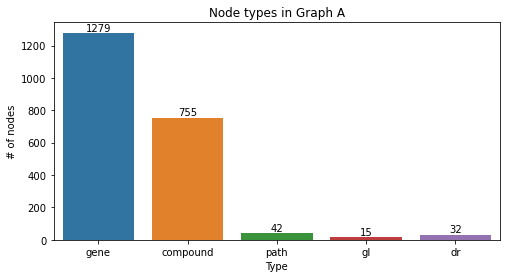

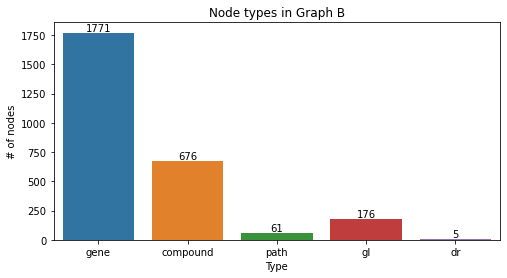

 94%|███████████████████████████████████████████████████████████████████████     | 28070/30000 [48:41<04:01,  7.98it/s]

Graph A:
Graph with 1518 nodes and 2955 edges
Graph B:
Graph with 3294 nodes and 7531 edges
[0, 1, 2, 3, 6, 7, 8, 9, 10, 12, 13, 14, 15, 19, 21, 27, 28, 29, 30, 31, 32, 33, 34]


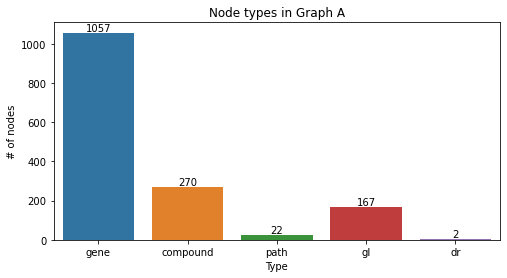

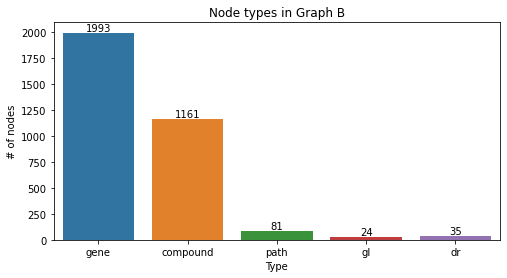

 94%|███████████████████████████████████████████████████████████████████████▋    | 28308/30000 [49:05<02:52,  9.82it/s]

Graph A:
Graph with 2625 nodes and 5662 edges
Graph B:
Graph with 2187 nodes and 4709 edges
[0, 1, 2, 6, 8, 13, 14, 16, 19, 21, 24, 25, 26, 27, 28, 30, 31, 32, 37, 38]


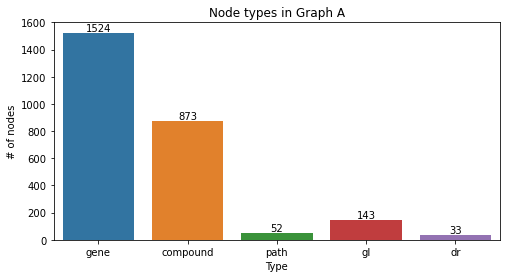

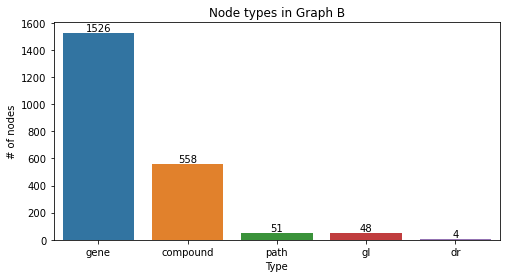

 95%|███████████████████████████████████████████████████████████████████████▊    | 28361/30000 [49:11<02:32, 10.77it/s]

Graph A:
Graph with 2438 nodes and 4592 edges
Graph B:
Graph with 2374 nodes and 6023 edges
[1, 2, 3, 6, 14, 17, 18, 19, 21, 22, 25, 26, 27, 28, 30, 31, 34, 35, 36, 38, 39]


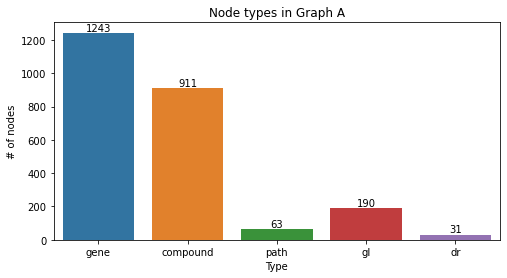

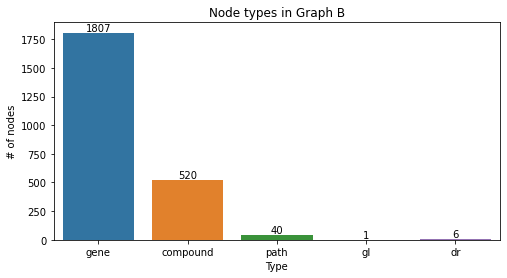

 96%|████████████████████████████████████████████████████████████████████████▋   | 28700/30000 [49:46<02:03, 10.55it/s]

Graph A:
Graph with 2500 nodes and 4986 edges
Graph B:
Graph with 2312 nodes and 5442 edges
[1, 2, 4, 6, 12, 14, 17, 18, 20, 23, 24, 26, 27, 28, 30, 31, 32, 34, 37, 38, 39]


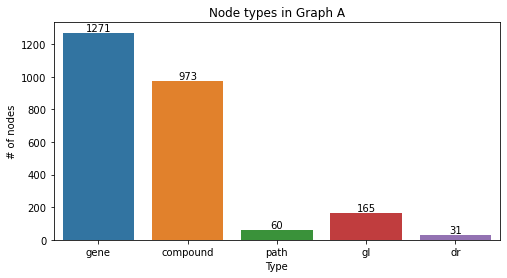

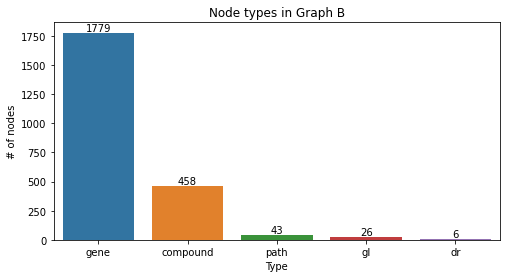

 96%|████████████████████████████████████████████████████████████████████████▊   | 28739/30000 [49:50<01:59, 10.52it/s]

Graph A:
Graph with 2476 nodes and 6237 edges
Graph B:
Graph with 2336 nodes and 4744 edges
[0, 2, 3, 4, 5, 6, 8, 9, 10, 11, 20, 23, 32, 37, 38, 39]


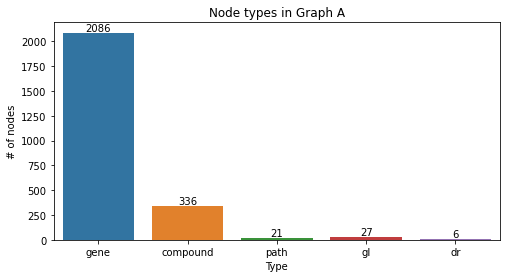

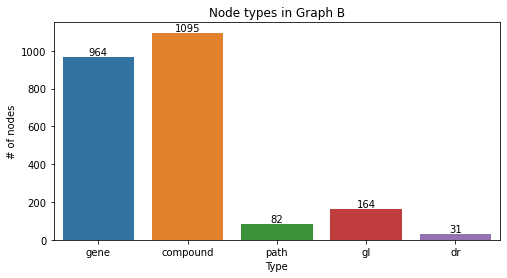

 97%|█████████████████████████████████████████████████████████████████████████▌  | 29019/30000 [50:20<01:35, 10.25it/s]

Graph A:
Graph with 1257 nodes and 2194 edges
Graph B:
Graph with 3555 nodes and 8664 edges
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 17, 18, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 35, 39]


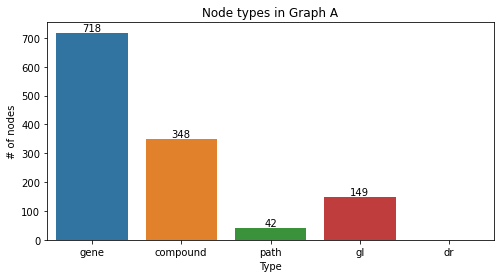

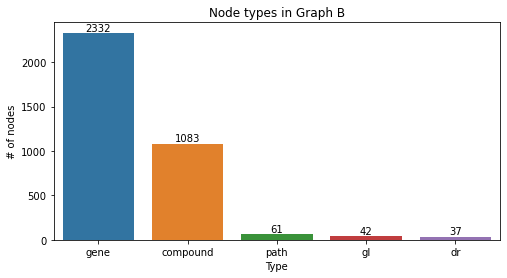

 97%|██████████████████████████████████████████████████████████████████████████  | 29246/30000 [50:45<01:15, 10.03it/s]

Graph A:
Graph with 2483 nodes and 5465 edges
Graph B:
Graph with 2329 nodes and 4882 edges
[1, 2, 5, 8, 11, 12, 13, 14, 16, 19, 21, 22, 26, 27, 28, 29, 30, 31, 35, 36, 37, 38, 39]


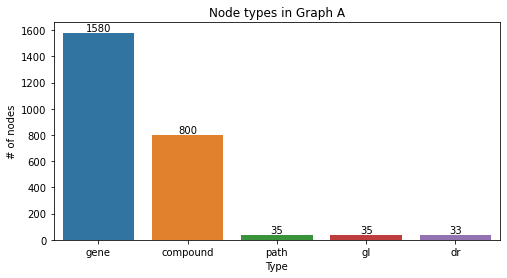

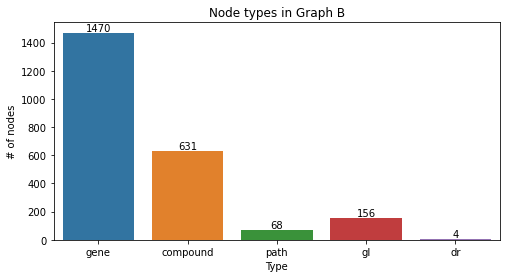

 98%|██████████████████████████████████████████████████████████████████████████  | 29252/30000 [50:46<01:42,  7.33it/s]

Graph A:
Graph with 2649 nodes and 5842 edges
Graph B:
Graph with 2163 nodes and 4489 edges
[0, 6, 8, 9, 10, 12, 13, 16, 17, 18, 19, 23, 24, 25, 26, 33, 34, 35, 36, 37, 39]


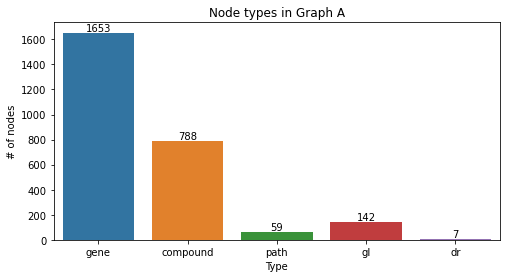

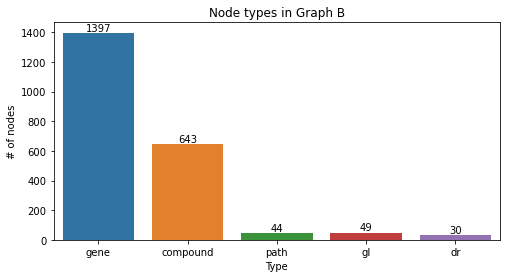

 98%|██████████████████████████████████████████████████████████████████████████▍ | 29398/30000 [51:01<01:01,  9.76it/s]

Graph A:
Graph with 2176 nodes and 4774 edges
Graph B:
Graph with 2636 nodes and 5486 edges
[2, 3, 4, 5, 8, 11, 12, 13, 16, 17, 18, 19, 20, 21, 25, 34]


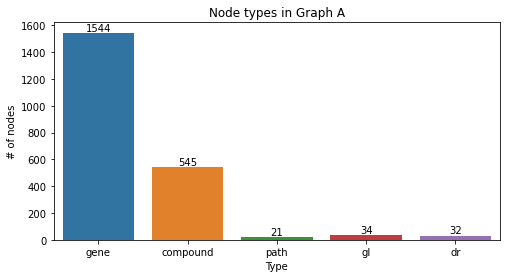

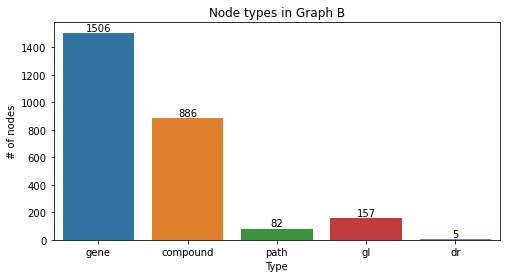

 99%|███████████████████████████████████████████████████████████████████████████ | 29628/30000 [51:24<00:43,  8.61it/s]

Graph A:
Graph with 2050 nodes and 4142 edges
Graph B:
Graph with 2762 nodes and 6294 edges
[1, 2, 3, 6, 7, 8, 9, 14, 15, 16, 19, 21, 22, 24, 25, 27, 28, 29, 30, 31, 34, 37, 38, 39]


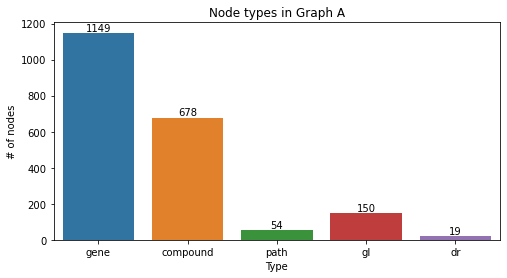

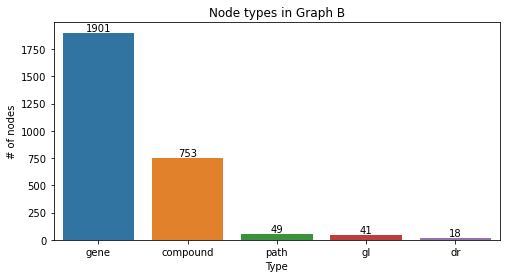

 99%|███████████████████████████████████████████████████████████████████████████ | 29648/30000 [51:26<00:30, 11.64it/s]

Graph A:
Graph with 2583 nodes and 5801 edges
Graph B:
Graph with 2229 nodes and 4682 edges
[0, 1, 10, 11, 13, 14, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 38, 39]


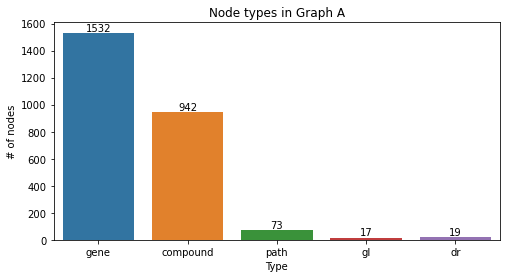

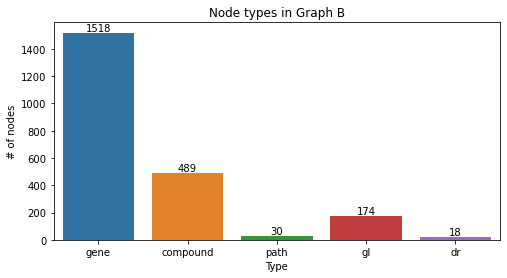

100%|███████████████████████████████████████████████████████████████████████████▊| 29943/30000 [51:57<00:06,  9.14it/s]

Graph A:
Graph with 2312 nodes and 5150 edges
Graph B:
Graph with 2500 nodes and 5137 edges
[0, 2, 7, 11, 12, 13, 15, 16, 17, 18, 20, 21, 23, 25, 29, 32, 34, 35, 36]


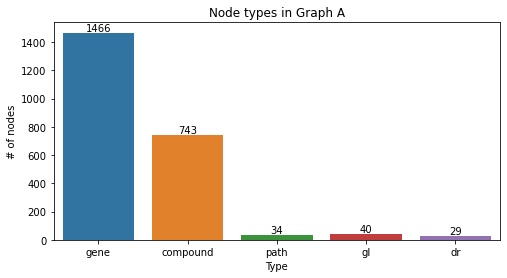

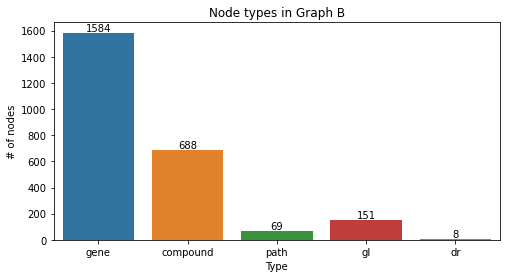

100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [52:03<00:00,  9.60it/s]


In [6]:
# Try to split main graph into 2 connected Graphs:
# 1. Randomly assign each partition in Graph A or Graph B
# 2. If both Graphs are connected, print their node types and selection of partitions
# 3. Manually decide the best split (most balanced split)

valid_selection = []
for tries in tqdm(range(0,30000)):
    G_A = G_undirected_main.copy()
    selection = []
    
    for i in range(0,40):
        if bool(random.randint(0, 1)):
            selection.append(i)
        
    for i in selection:
        for node in partition:
            if partition[node] == i:
                G_A.remove_node(node)
                
    
    if nx.is_connected(G_A):
        
        G_B = G_undirected_main.copy()
        nodes = list(G_A.nodes)

        for node in nodes:
             G_B.remove_node(node)
                
        if nx.is_connected(G_B):
            print("Graph A:")
            print(G_A)
            print("Graph B:")
            print(G_B)
            print(selection)
            valid_selection = selection
            
            # === node types Graph A ===
            types = list(nx.get_node_attributes(G_A, 'type').values())
            plt.figure(figsize=(8,4))
            plt.title("Node types")
            ax = sns.countplot(x=types, order = ["gene", "compound", "path","gl", "dr"])
            for container in ax.containers:
                ax.bar_label(container)
            ax.set(xlabel="Type", ylabel = "# of nodes", title = "Node types in Graph A")
            plt.show()


            # === node types Graph B ===
            types = list(nx.get_node_attributes(G_B, 'type').values())
            plt.figure(figsize=(8,4))
            plt.title("Node types")
            ax = sns.countplot(x=types, order = ["gene", "compound", "path","gl", "dr"])
            for container in ax.containers:
                ax.bar_label(container)
            ax.set(xlabel="Type", ylabel = "# of nodes", title = "Node types in Graph B")
            plt.show()
    

Graph A:
Graph with 2526 nodes and 5375 edges
Connected: True
Graph B:
Graph with 2286 nodes and 4887 edges
Connected: True
------------
Common nodes in both Graphs:

------------


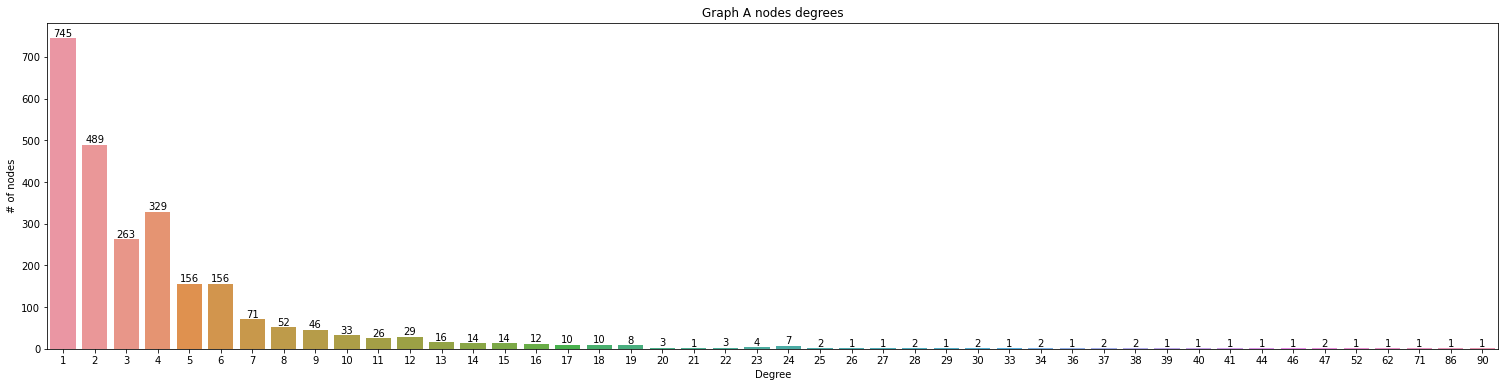

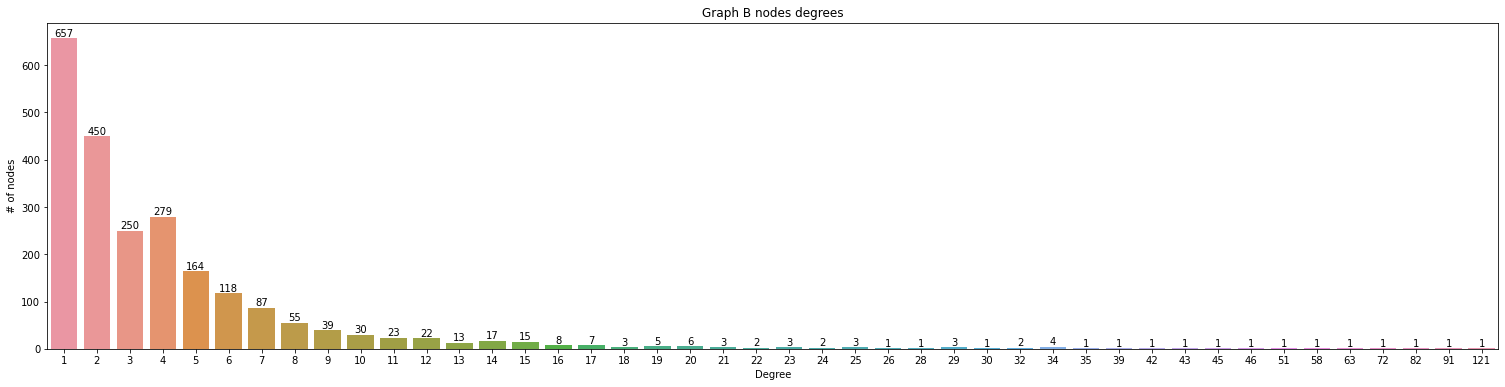

In [14]:
# Manually select a list of partitions to split the dataset
valid_selection = [1, 2, 3, 4, 5, 6, 14, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 36, 38]

G_A = G_undirected_main.copy()

for i in valid_selection:
    for node in partition:
        if partition[node] == i:
            G_A.remove_node(node)

print("Graph A:")
print(G_A)
print("Connected: "+str(nx.is_connected(G_A)))            
            
G_B = G_undirected_main.copy()
nodes = list(G_A.nodes)

for node in nodes:
     G_B.remove_node(node)
        
print("Graph B:")
print(G_B)
print("Connected: "+str(nx.is_connected(G_B)))   

# Check if any nodes contained in both Graphs
print("------------\nCommon nodes in both Graphs:\n")
for node in G_A.nodes:
    if node in G_B.nodes:
        print(node)
print("------------")

# Compare nodes degrees for each Graph
degrees = []

for node in G_A.nodes:
    degrees.append(G_A.degree[node])
        
        
plt.figure(figsize=(26,6))
ax = sns.countplot(x=degrees)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Degree", ylabel = "# of nodes", title = "Graph A nodes degrees")
plt.draw()

degrees = []

for node in G_B.nodes:
    degrees.append(G_B.degree[node])
        
        
plt.figure(figsize=(26,6))
ax = sns.countplot(x=degrees)
for container in ax.containers:
    ax.bar_label(container)
ax.set(xlabel="Degree", ylabel = "# of nodes", title = "Graph B nodes degrees")
plt.draw()

In [15]:
# Save exact nodes split for later use if needed
save_version = 'v6'

df_nodes_A = pd.DataFrame(G_A.nodes)
df_nodes_A.to_csv('Hops Dataset '+save_version+' - Nodes A.csv',index=False)

df_nodes_B = pd.DataFrame(G_B.nodes)
df_nodes_B.to_csv('Hops Dataset '+save_version+' - Nodes B.csv',index=False)

In [16]:
# Find shortest path (= Hops) based on original total Graph
visited_nodes = []
Hops_A = []

for node1 in tqdm(G_A.nodes):
    for node2 in G_A.nodes:
        if node2 in visited_nodes:
            continue
        l = nx.shortest_path_length(G_undirected_main, source = node1, target = node2)
        Hops_A.append([G_A.nodes[node1]['full name'], G_A.nodes[node2]['full name'], l])
    
    visited_nodes.append(node1)

print("Total Graph A dataset rows:")    
print(len(Hops_A))

100%|██████████████████████████████████████████████████████████████████████████████| 2526/2526 [06:25<00:00,  6.56it/s]

Total Graph A dataset rows:
3191601


In [17]:
# Find shortest path (= Hops) based on original total Graph
visited_nodes = []
Hops_B = []

for node1 in tqdm(G_B.nodes):
    for node2 in G_B.nodes:
        if node2 in visited_nodes:
            continue
        l = nx.shortest_path_length(G_undirected_main, source = node1, target = node2)
        Hops_B.append([G_B.nodes[node1]['full name'], G_B.nodes[node2]['full name'], l])
    
    visited_nodes.append(node1)

print("Total Graph B dataset rows:")    
print(len(Hops_B))

100%|██████████████████████████████████████████████████████████████████████████████| 2286/2286 [04:36<00:00,  8.25it/s]

Total Graph B dataset rows:
2614041


In [18]:
# All data to csv: HEAD - TAIL - HOPS
df_Hops_A = pd.DataFrame(Hops_A,columns = ["Head", "Tail", "Hops"])
df_Hops_A.to_csv('Hops Dataset '+save_version+' - A.csv', index=False)

df_Hops_B = pd.DataFrame(Hops_B,columns = ["Head", "Tail", "Hops"])
df_Hops_B.to_csv('Hops Dataset '+save_version+' - B.csv', index=False)

<AxesSubplot:xlabel='Hops', ylabel='Count'>

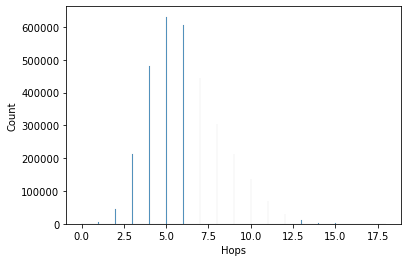

In [19]:
# SAMPLE Stratified Graph A

df_sub = df_Hops_A.groupby('Hops', group_keys=False).apply(lambda x: x.sample(min(len(x), 100000)))
df_sub.to_csv('Hops Dataset 100K '+save_version+' - A.csv', index=False)

sns.histplot(df_Hops_A["Hops"])

<AxesSubplot:xlabel='Hops', ylabel='Count'>

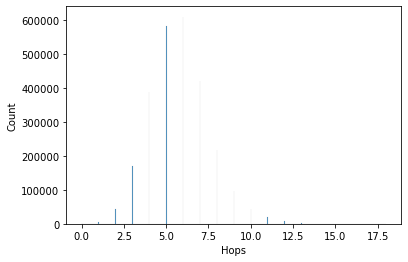

In [20]:
# SAMPLE Stratified Graph B

df_sub = df_Hops_B.groupby('Hops', group_keys=False).apply(lambda x: x.sample(min(len(x), 100000)))
df_sub.to_csv('Hops Dataset 100K '+save_version+' - B.csv', index=False)

sns.histplot(df_Hops_B["Hops"])